In [17]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)


/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [18]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())


data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)



In [ ]:
# from tqdm import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from mamba_lens.input_dependent_hooks import clean_hooks
from tqdm import tqdm

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': True
}
BATCH_SIZE = 30

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched


# consider what happens if we are only ablating some edges:
# todo
global alpha
alpha = 1

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    #print(f"running cache with alpha {alpha} and layer {layer}") 
    # the first one is embed, so layer+1
    # this patches all edges going into this one
    # actually, see the above note,
    # only apply the embed diff, do this to all layers
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    #print(f"running fwd with alpha {alpha} and layer {layer}") 
    # the first one is embed, so layer+1
    # this patches all edges going into this one
    # actually, see the above note,
    # only apply the embed diff, do this to all layers
    # actually, once we make diffs be (-current forward pass layer_output + corrupted) then it's fine to do this
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha
    #patched = layer_input + diffs[:layer+1].sum(dim=0)
    #unpatched = layer_input
    # alpha * layer_input + alpha*diffs + layer_input - alpha*layer_input
    # they cancel out and it's just
    # layer_input + alpha*diffs
    #return alpha * patched + (1-alpha)*unpatched

def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B]
    attr = (grad*upstream_diffs).sum(dim=-1).sum(dim=-1)
    # [B, N_upstream]
    attr = attr.T.clone().detach()
    attributions[batch_start:batch_end,:layer+1,layer+1] += attr

B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)

input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]


for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'

    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=[embed_name] + output_names, **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=[embed_name] + output_names, **model_kwargs)
    
    batch_size,L,D = unpatched_layer_outputs[output_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    # backward pass to compute grad of diff
    torch.set_grad_enabled(True)
    
    
    corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]

    

    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                                   layer=-1,
                                   cached_outputs=cached_outputs))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                                    layer=layer,
                                    cached_outputs=cached_outputs)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                      cached_outputs=cached_outputs,
                      corrupted_outputs=corrupted_outputs,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          cached_outputs=cached_outputs,
                          corrupted_outputs=corrupted_outputs,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        corrupted_outputs.grad = None
        corrupted_outputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0]
        )
        print(f"alpha {alpha} metric {metric}")
        # run backward pass, which adds to attributions
        metric.backward()

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)




0 30
alpha 0.0 metric 1.0
alpha 0.25 metric 0.38701924681663513
alpha 0.5 metric 0.08319268375635147
alpha 0.75 metric 0.010667526163160801
alpha 1.0 metric -1.895362089499031e-08
30 60
alpha 0.0 metric 1.0
alpha 0.25 metric 0.38052916526794434
alpha 0.5 metric 0.08248379081487656
alpha 0.75 metric 0.010522770695388317
alpha 1.0 metric 1.0289740259850078e-07
60 90


torch.Size([800, 20])


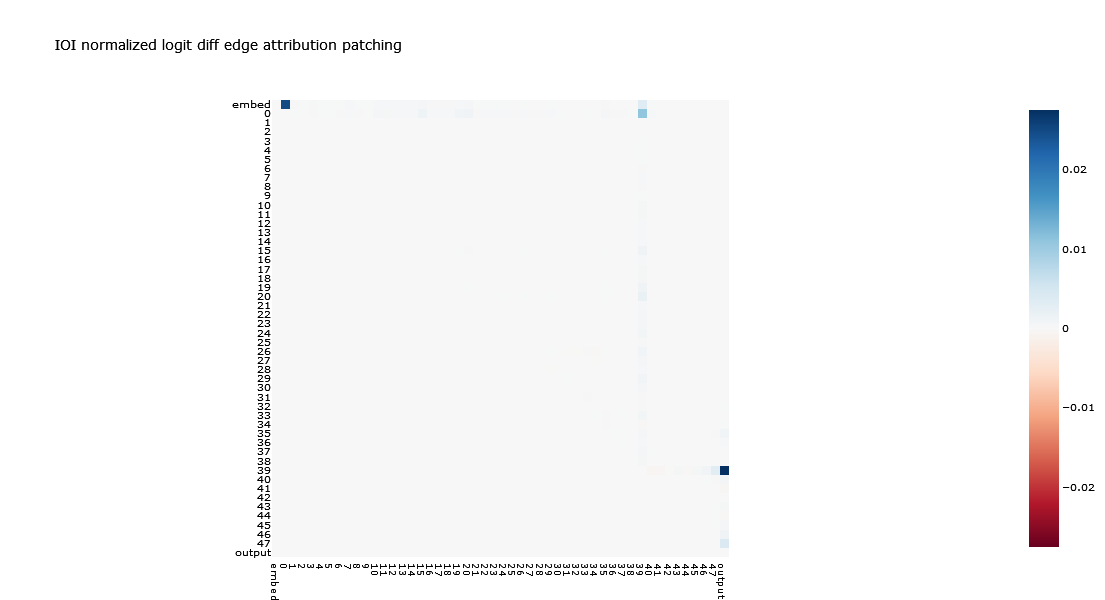

In [40]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


layer_names = list(map(str, range(model.cfg.n_layers)))
layer_names = ['embed'] + layer_names + ['output']
imshow(attributions.mean(dim=0), x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='IOI normalized logit diff edge attribution patching')

In [84]:
from functools import partial

eval_kwargs = {
    "fast_ssm": True,
    "fast_conv": True
}

def test_graph(keeping_edges):
    edges_patching = []
    keeping_edges_set = set(keeping_edges)
    
    
    for i in range(model.cfg.n_layers):
        edge = ('embed', i)
        if not edge in keeping_edges_set:
            edges_patching.append(edge)
        for j in range(i+1, model.cfg.n_layers):
            edge = (i,j)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)
        edge = (i, 'output')
        if not edge in keeping_edges_set:
            edges_patching.append(edge)
    
    storage = {}
    clean_hooks(model)

    metrics = []
    accs = []
    for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
        batch_size = batch_end-batch_start
        clean_hooks(model)
        unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
        corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
        # get only the last token position (logit for next predicted token)
        unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]

        global cache
        cache = {}
        def caching_hook(
            x,
            hook):
            global cache
            cache[hook.name] = x
        
        # for every edge (i->j) that we patch, we should:
        # to compute the input for layer j:
        # subtract current forward pass output of layer i
        # and add cached corrupted output of layer i
        # that has the effect of removing whatever that layer might have outputted
        # and instead, the outputs from that 
        def patching_hook(
            x,
            hook,
            edge_input_hook):
            global cache
            return x - cache[edge_input_hook] + corrupted_layer_outputs[edge_input_hook]

        # need to handle the embed -> i, i->j, and j->output
        def get_edge_input_hook(input_layer):
            if input_layer == 'embed':
                return f'hook_embed'
            else:
                return f'blocks.{input_layer}.hook_out_proj'

        def get_edge_output_hook(output_layer):
            if output_layer == 'output':
                return f'blocks.{model.cfg.n_layers-1}.hook_out_proj'
            else:
                return f'blocks.{output_layer}.hook_layer_input'
        hooks = []
        for input_layer, output_layer in edges_patching:            
            hooks.append((get_edge_output_hook(output_layer), partial(patching_hook, edge_input_hook=get_edge_input_hook(input_layer))))
        hooks.append((get_edge_input_hook('embed'), caching_hook))
        for layer in range(model.cfg.n_layers):
            hooks.append((get_edge_input_hook(layer), caching_hook))
        
        clean_hooks(model)
        patched_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=hooks, **model_kwargs)
        # get only the last token position (logit for next predicted token)
        patched_logits = patched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        
        metric, acc = normalized_logit_diff_metric(
            patched_logits=patched_logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0],
            also_return_acc=True
        )
    
        metrics.append(metric.item())
        accs.append(acc.item())

    metric, acc = torch.mean(torch.tensor(metrics)), torch.mean(torch.tensor(accs))
    return metric, acc


# mean over all batches
attrs = attributions.mean(dim=0)
edges = []
# embed -> i
for i in range(model.cfg.n_layers):
    edges.append((attrs[0,i], 'embed', i))
# i -> j
for i in range(model.cfg.n_layers):
    for j in range(i+1, model.cfg.n_layers):
        edges.append((attrs[i+1,j+1], i, j))
# j -> output
for j in range(model.cfg.n_layers):
    edges.append((attrs[j,-1], j, 'output'))

# they can have positive or negative effect, either matters for the circuit
# 10 iters:
# needs top 248 for 0.9 acc thresh when abs
# needs top 227 for 0.9 acc thresh when no abs
# 30 iters:
# needs top 249 for 0.9 acc thresh when abs
# needs top 243 for 0.9 acc thresh when no abs

# after we fix things:
# flipping 1.0 and zero by subtracting max_diff and multiplying by negative one:
# no abs needs negative or almost all edges)
# 1 iters:
# needs top 299 for 0.9 acc thresh when abs (also 299 for restored normalized logit diff)
# needs top 325 for 0.9 acc thresh when no abs (Also 335)
# 5 iters:
# needs top 204 for 0.9 acc thresh when abs (also 204)
# needs top 180 for 0.9 acc thresh when no abs (also 180)
# 10 iters:
# needs top 200 for 0.9 acc thresh when abs
# needs top 183 for 0.9 acc thresh when no abs
# 30 iters:
# needs top 195 for 0.9 acc thresh when abs
# needs top 181 for 0.9 acc thresh when no abs

#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda x: x[0])

edges_with_improvements = []
    
prev_metric = 0

# binary search for minimum number of edges that passes desired threshold
pos = len(edges)//2
jump_size = len(edges)//4

import math
def test_pos(pos):
    edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:pos]]
    metric, acc = test_graph(edges_to_keep)
    print(f"testing pos {pos} got metric {metric} and acc {acc}")
    return acc.item()

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.85

cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:cutoff]]
scores = [score for (score, in_edge, out_edge) in edges[:cutoff]]
print(f"keeping top {cutoff} edges {edges_to_keep}")
metric, acc = test_graph(edges_to_keep)
print(f"got metric {metric} and acc {acc}")    
    
'''
for i in range(0, len(edges), 1):
    score, layer_input, layer_output = edges[i]
    edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:i]]
    print(f"keeping top {i} edges {edges_to_keep}")
    metric, acc = test_graph(edges_to_keep)
    edges_with_improvements.append((layer_input, layer_output, score, metric, acc))
    if acc > 0.9: break # arbitrary "good enough" threshold
'''

testing pos 612 got metric 0.24366746842861176 and acc 0.0595238171517849
testing pos 918 got metric 0.25247910618782043 and acc 0.07380952686071396
testing pos 1071 got metric 0.994648277759552 and acc 0.997619092464447
testing pos 994 got metric 0.2521282732486725 and acc 0.07619047909975052


KeyboardInterrupt: 

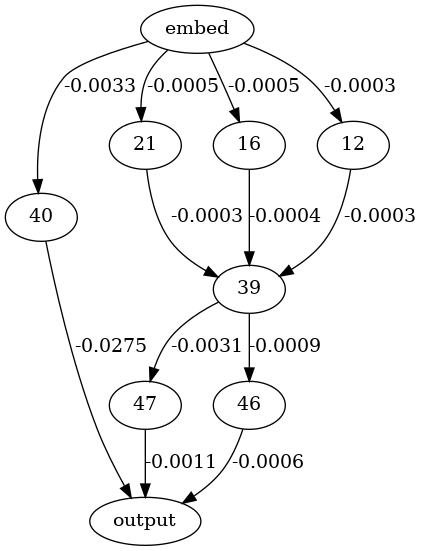

/home/dev/mamba_interp/pruned dot 0.85.png

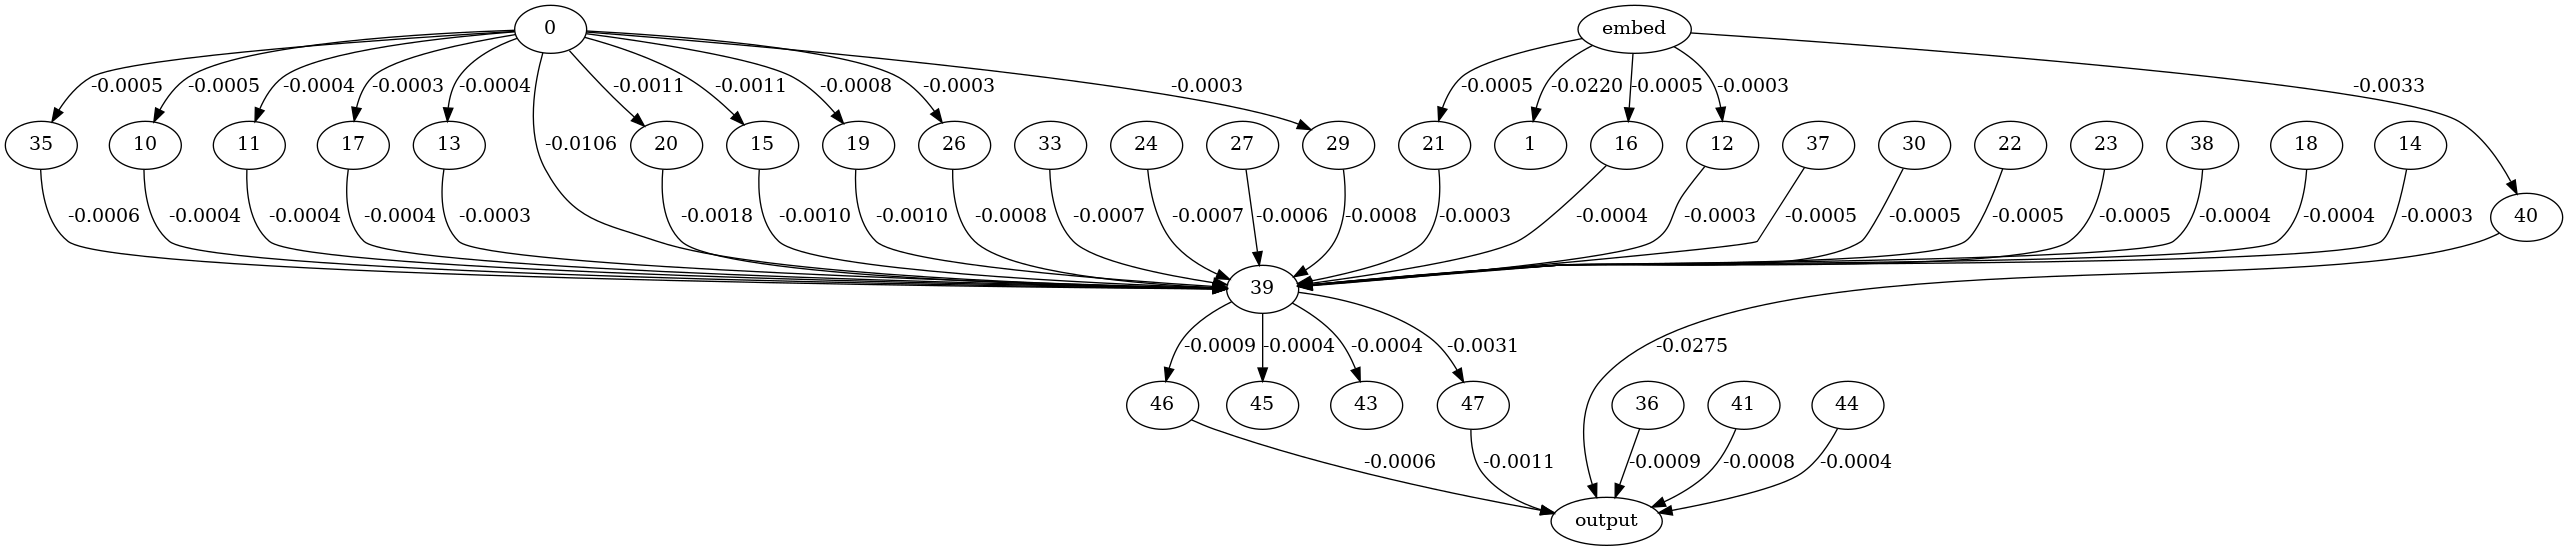

/home/dev/mamba_interp/dot 0.85.png

In [80]:
'''
import graphviz
from IPython.display import Image, display, clear_output, FileLink

attrib_dot = graphviz.Digraph('Attributions')
metric_dot = graphviz.Digraph('Metric improvements')
acc_dot = graphviz.Digraph('Acc improvements')
all_dot = graphviz.Digraph('All improvements')
prev_acc = 0
prev_metric = 0

def top_4_digits(f):
    return "{:.4f}".format(f)

def update(metric_thresh, stats_to_display):
    with output:
        clear_output()
        for input_layer, output_layer, attrib, metric, acc in edges_with_improvements:
            if metric >= metric_thresh:
                print(f"graph has accuracy {acc.item()}")
                break
            input_layer_str = str(input_layer)
            output_layer_str = str(output_layer)
            metric_improvement = metric - prev_metric
            acc_improvement = acc - prev_acc
            attrib_str = top_4_digits(attrib.item())
            attrib_dot.edge(input_layer_str, output_layer_str, label=attrib_str)
            metric_str = top_4_digits(metric_improvement.item())
            metric_dot.edge(input_layer_str, output_layer_str, label=metric_str)
            acc_str = top_4_digits(acc_improvement.item())
            acc_dot.edge(input_layer_str, output_layer_str, label=acc_str)
            all_dot.edge(input_layer_str, output_layer_str, label=f"t:{attrib_str},m:{metric_str},a:{acc_str}")
        
        for name, dot in zip(['attrib_dot', 'metric_dot', 'acc_dot', 'all_dot'], [attrib_dot, metric_dot, acc_dot, all_dot]):
            if stats_to_display == name:
                dot.render(name, format="png") # it automatically appends png
                display(Image(filename=name + ".png"))
                display(FileLink(name + ".png"))




import ipywidgets

output = ipywidgets.Output()

display(ipywidgets.interactive(update, metric_thresh=sorted(list(set([m.item() for _, _, _, m, _ in edges_with_improvements]))), stats_to_display=['attrib_dot', 'metric_dot', 'acc_dot', 'all_dot']))
display(output)
'''
import networkx as nx
def get_nx_graph(edges) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    G = nx.DiGraph()
    for score, (edge_input, edge_output) in edges:
        G.add_edge(str(edge_input), str(edge_output))
    return G

def prune_edges(edges, input_node, output_node):
    import networkx as nx
    G = get_nx_graph(edges=edges)
    connected_edges = []
    for score, (edge_input, edge_output) in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(edge_input))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(edge_output), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        if connected_to_input and connected_to_output:
            connected_edges.append((score, (edge_input, edge_output)))
    return connected_edges


import graphviz
from IPython.display import Image, display, clear_output, FileLink

def top_4_digits(f):
    return "{:.4f}".format(f)

pruned_edges = prune_edges(list(zip(scores, edges_to_keep)), input_node='embed', output_node='output')

pruned_dot = graphviz.Digraph('graph')
for score, (i,o) in pruned_edges:
    pruned_dot.edge(str(i),str(o), label=top_4_digits(score))
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))




dot = graphviz.Digraph('graph')
for score, (i,o) in zip(scores, edges_to_keep):
    dot.edge(str(i),str(o), label=top_4_digits(score))
#metric, acc = test_graph([x[1] for x in pruned_edges])
#print(f"pruned graph gets metric {metric} and acc {acc}")
#metric, acc = test_graph(edges_to_keep)
#print(f"unpruned graph gets metric {metric} and acc {acc}")
output_name = f'dot {ACC_THRESH}'
dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

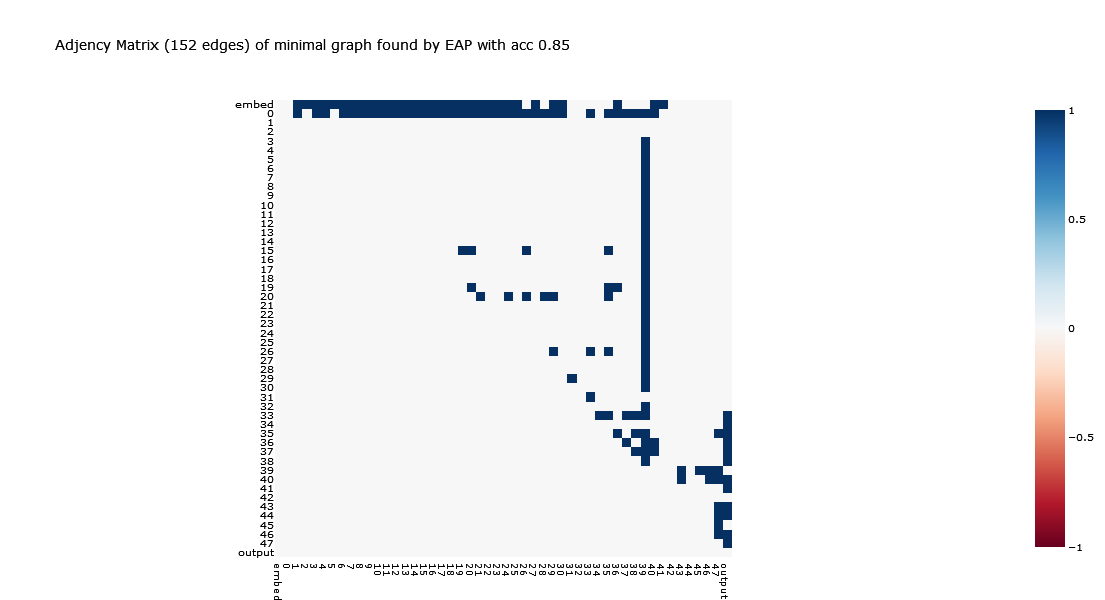

In [61]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig
import torch

adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2])
for i,o in edges_to_keep:
    adjacency_matrix[edge_to_i(i),edge_to_i(o)] = 1
layer_names = ['embed'] + list(map(str, range(model.cfg.n_layers))) + ['output']
imshow(adjacency_matrix, x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title=f'Adjency Matrix ({len(edges_to_keep)} edges) of minimal graph found by EAP with acc {ACC_THRESH}')

In [ ]:
# import acdc

from transformer_lens.hook_points import HookPoint
from acdc import Edge, ACDCConfig, LOG_LEVEL_INFO, LOG_LEVEL_DEBUG, run_acdc, ACDCEvalData

global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []

B,L = data.data.size()

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def layer_node(layer):
    return f'{layer}'

# direct connection from embed to output
edges.append(Edge(
        input_node=INPUT_NODE,
        input_hook=(INPUT_HOOK, storage_hook),
        output_node=OUTPUT_NODE,
        output_hook=(OUTPUT_HOOK, resid_patching_hook),
))

for layer in layers:
    # edge from embed to layer input
    edges.append(Edge(
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=layer_node(layer),
            output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
    ))

    # edge from some other earlier layer to this layer
    for other_layer in layers:
        if other_layer < layer:
            edges.append(Edge(
                    input_node=layer_node(other_layer),
                    input_hook=(f'blocks.{other_layer}.hook_out_proj', storage_hook),
                    output_node=layer_node(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
            ))

    # edge from layer output to final layer output
    edges.append(Edge(
            input_node=layer_node(layer),
            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, resid_patching_hook),
    ))

model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
}

def normalized_logit_diff_metric(data: ACDCEvalData):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
        
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)

# set all edges to checked and patching
for edge in edges:
    # EAP doesn't consider these ones
    if not edge.input_node == INPUT_NODE and not edge.output_node == OUTPUT_NODE:
        edge.patching = True
        edge.checked = True

# now unset all the ones that EAP found
for input_layer, output_layer in edges_to_keep:
    input_node = layer_node(input_layer)
    output_node = layer_node(output_layer)
    found = False
    for edge in edges:
        if edge.input_node == input_node and edge.output_node == output_node:
            edge.patching = False
            edge.checked = False
            found = True
            break
    if not found:
        raise ValueError(f"Could not find edge {input_layer, output_layer} with attr {score}")            




from acdc import get_most_recent_checkpoint
from typing import Any
import os
import wandb

job_name_text = "attr patching ioi.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False


cfg = ACDCConfig(
    ckpt_directory = wandb_id,
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=normalized_logit_diff_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = False,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = False,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)



wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")


class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)


num edges 279


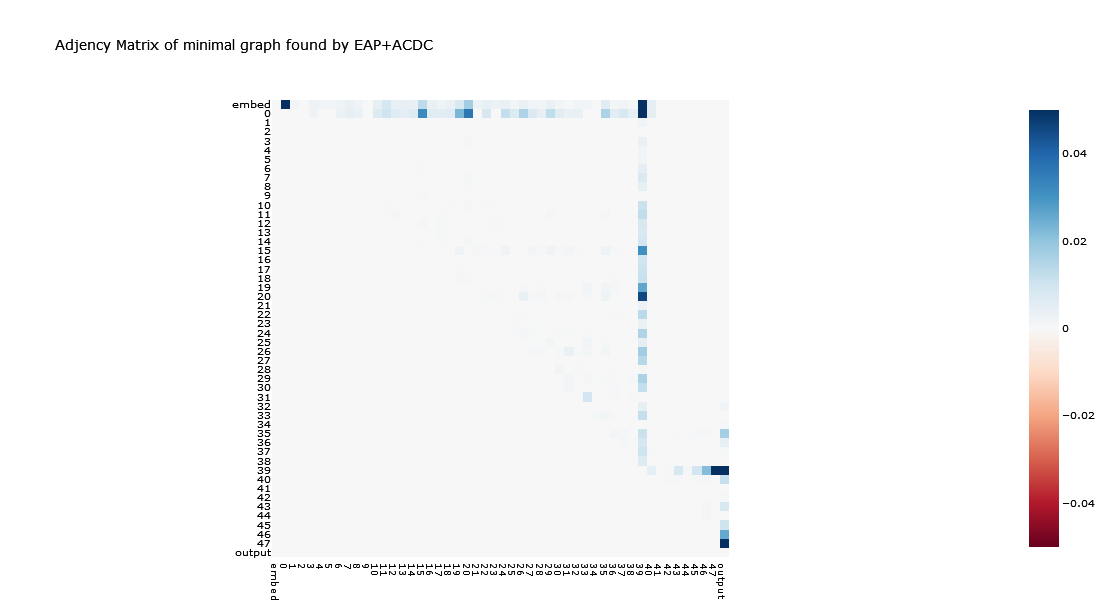

In [47]:
    
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2])
nodes = [INPUT_NODE] + [layer_node(layer) for layer in range(model.cfg.n_layers)] + [OUTPUT_NODE]
layer_names = ['embed'] + [str(i) for i in range(model.cfg.n_layers)] + ['output']
def node_to_i(node):
    return nodes.index(node)

num_edges = 0
for edge in result_edges:
    if edge.checked and not edge.patching:
        num_edges += 1
        adjacency_matrix[node_to_i(edge.input_node), node_to_i(edge.output_node)] = min(0.05,edge.score_diff_when_patched)
print(f"num edges {num_edges}")
imshow(adjacency_matrix, x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='Adjency Matrix of minimal graph found by EAP+ACDC')






starting new run qxd30tuf


all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
final output:


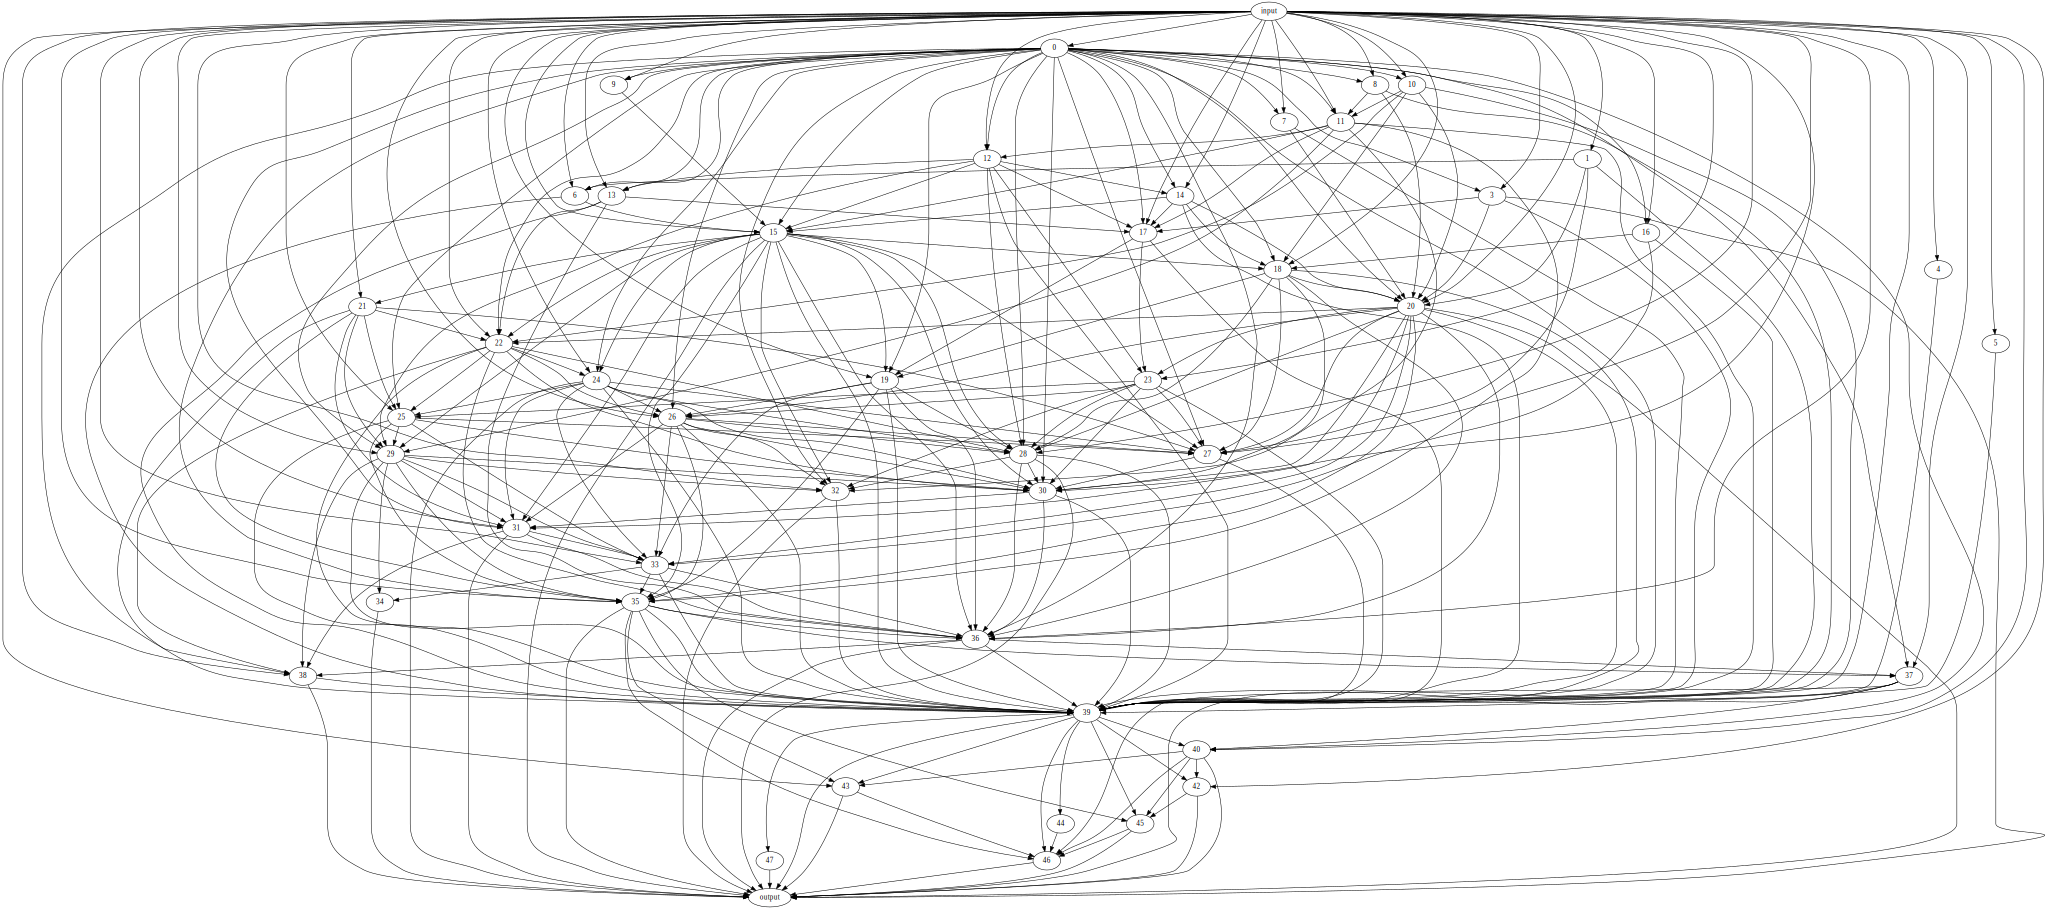

final score 0.8534050583839417
saved to checkpoint qxd30tuf/checkpoint 0 final.pkl
all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 946 edges, keeping 0 edges, 279 remain
patching 946 edges, keeping 0 edges, 279 remain
baseline score 0.8534050583839417
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8534], device='cuda:0')
keeping edge edge  3 -> output (('blocks.3.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8533636927604675 which has diff 4.1365623474121094e-05 > 1e-05
patching 946 edges, keeping 1 edges, 278 remain
baseline score 0.8534050583839417
[1, 

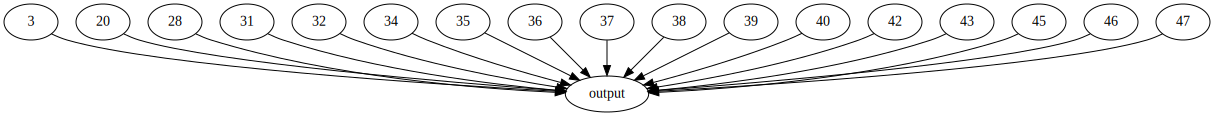

saved to checkpoint qxd30tuf/checkpoint 0.pkl
patching 948 edges, keeping 17 edges, 260 remain
patching 948 edges, keeping 17 edges, 260 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8526], device='cuda:0')
keeping edge edge  35 -> 46 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8525691032409668 which has diff 0.0008314251899719238 > 1e-05
patching 948 edges, keeping 18 edges, 259 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8534], device='cuda:0')
keeping edge edge  37 -> 46 (('blocks.37.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8533627390861511 which has diff 3.7789344787597656e-05 > 1e-05
patching 948 edges, keeping

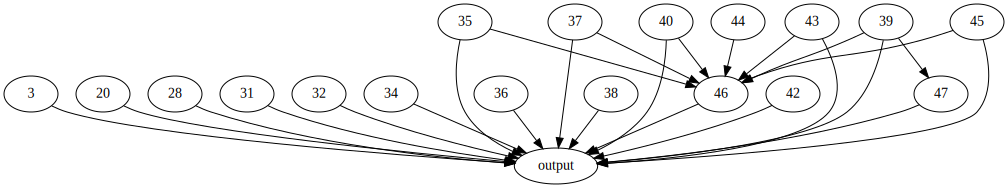

saved to checkpoint qxd30tuf/checkpoint 1.pkl
patching 948 edges, keeping 25 edges, 252 remain
patching 948 edges, keeping 25 edges, 252 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8533], device='cuda:0')
keeping edge edge  input -> 43 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.853299081325531 which has diff 0.00010144710540771484 > 1e-05
patching 948 edges, keeping 26 edges, 251 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8530], device='cuda:0')
keeping edge edge  35 -> 43 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8529843091964722 which has diff 0.00041621923446655273 > 1e-05
patching 948 edges, keeping 27 

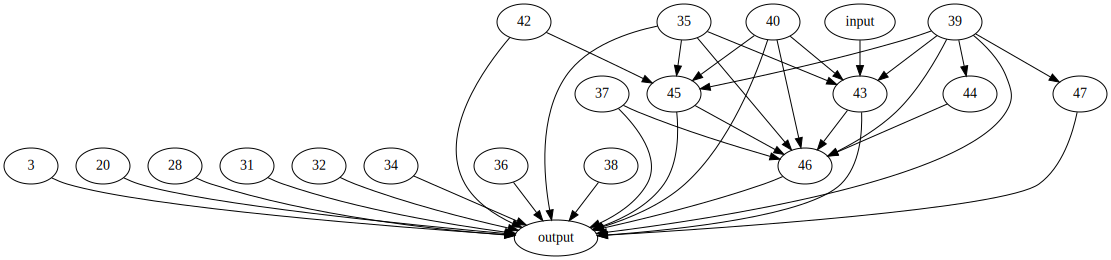

saved to checkpoint qxd30tuf/checkpoint 2.pkl
patching 948 edges, keeping 34 edges, 243 remain
patching 948 edges, keeping 34 edges, 243 remain
baseline score 0.8534005284309387
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8533], device='cuda:0')
keeping edge edge  input -> 42 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8533457517623901 which has diff 5.4776668548583984e-05 > 1e-05
patching 948 edges, keeping 35 edges, 242 remain
baseline score 0.8534005284309387
[1, 1] sized edge sets remaining
got scores tensor([0.8529], device='cuda:0')
keeping edge edge  39 -> 42 (('blocks.39.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8528805375099182 which has diff 0.0005199909210205078 > 1e-05
patching 948 edges, keeping 36 edges, 241 remain
baseline score 0.8

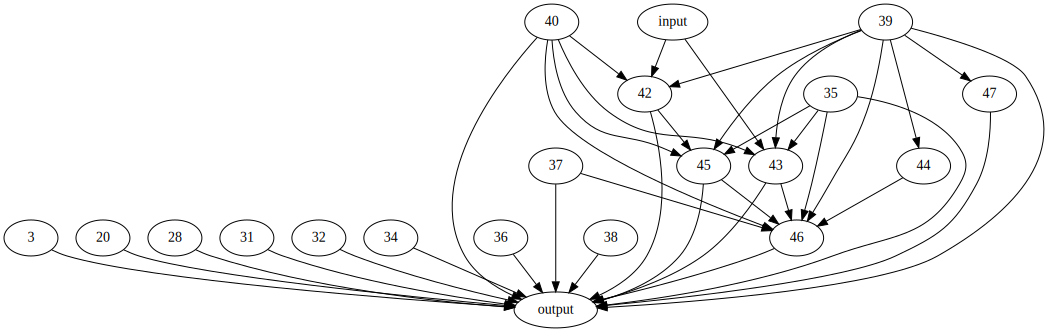

saved to checkpoint qxd30tuf/checkpoint 3.pkl
patching 948 edges, keeping 37 edges, 240 remain
patching 948 edges, keeping 37 edges, 240 remain
baseline score 0.8534005284309387
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8486], device='cuda:0')
keeping edge edge  input -> 40 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8485956192016602 which has diff 0.0048049092292785645 > 1e-05
patching 948 edges, keeping 38 edges, 239 remain
baseline score 0.8534005284309387
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8483], device='cuda:0')
keeping edge edge  0 -> 40 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.848347544670105 which has diff 0.00505298376083374 > 1e-05
patching 948 edges, keeping 39 edges, 238 remain
baseline score 0.8

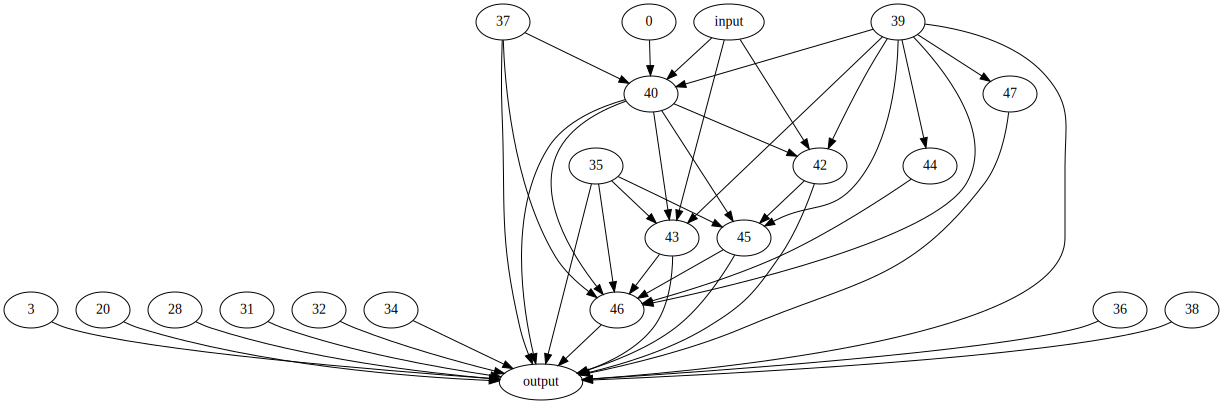

saved to checkpoint qxd30tuf/checkpoint 4.pkl
patching 948 edges, keeping 41 edges, 236 remain
patching 948 edges, keeping 41 edges, 236 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.7458], device='cuda:0')
keeping edge edge  input -> 39 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.7457640171051025 which has diff 0.10763651132583618 > 1e-05
patching 948 edges, keeping 42 edges, 235 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.4956], device='cuda:0')
keeping edge edge  0 -> 39 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', <

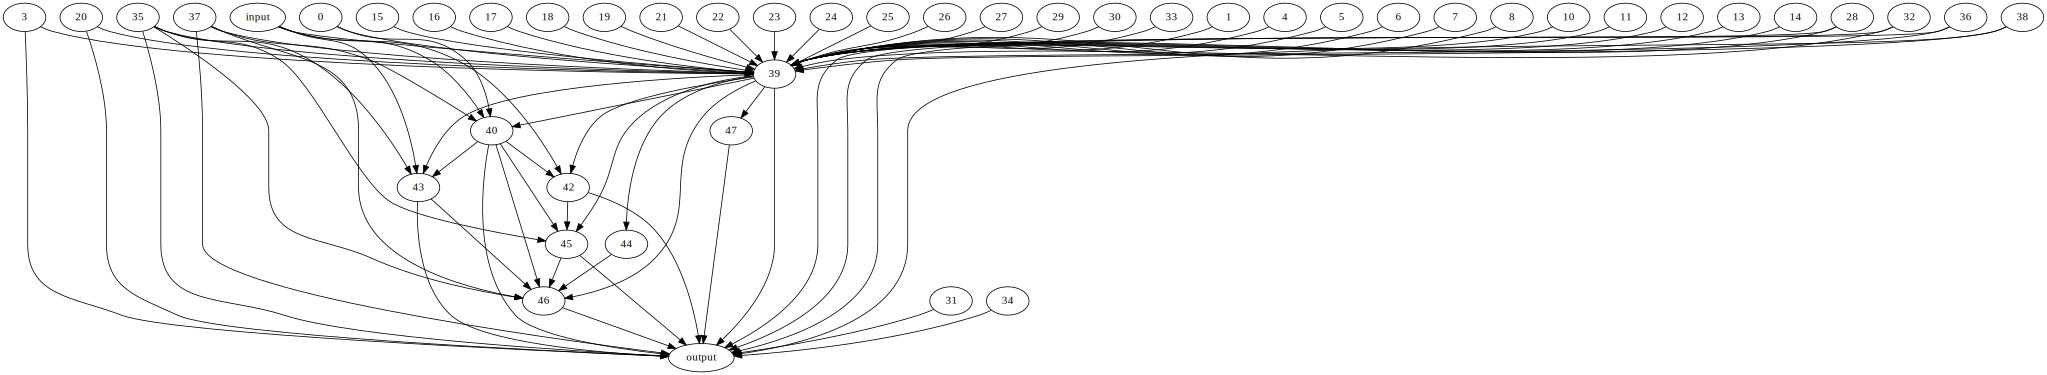

saved to checkpoint qxd30tuf/checkpoint 5.pkl
patching 948 edges, keeping 77 edges, 200 remain
patching 948 edges, keeping 77 edges, 200 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8515], device='cuda:0')
keeping edge edge  input -> 37 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.851521909236908 which has diff 0.0018786191940307617 > 1e-05
patching 948 edges, keeping 78 edges, 199 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8449], device='cuda:0')
keeping edge edge  0 -> 37 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8448701500892639 which has diff 0.008530378341674805 > 1e-05
patching 948 edges, keeping 79

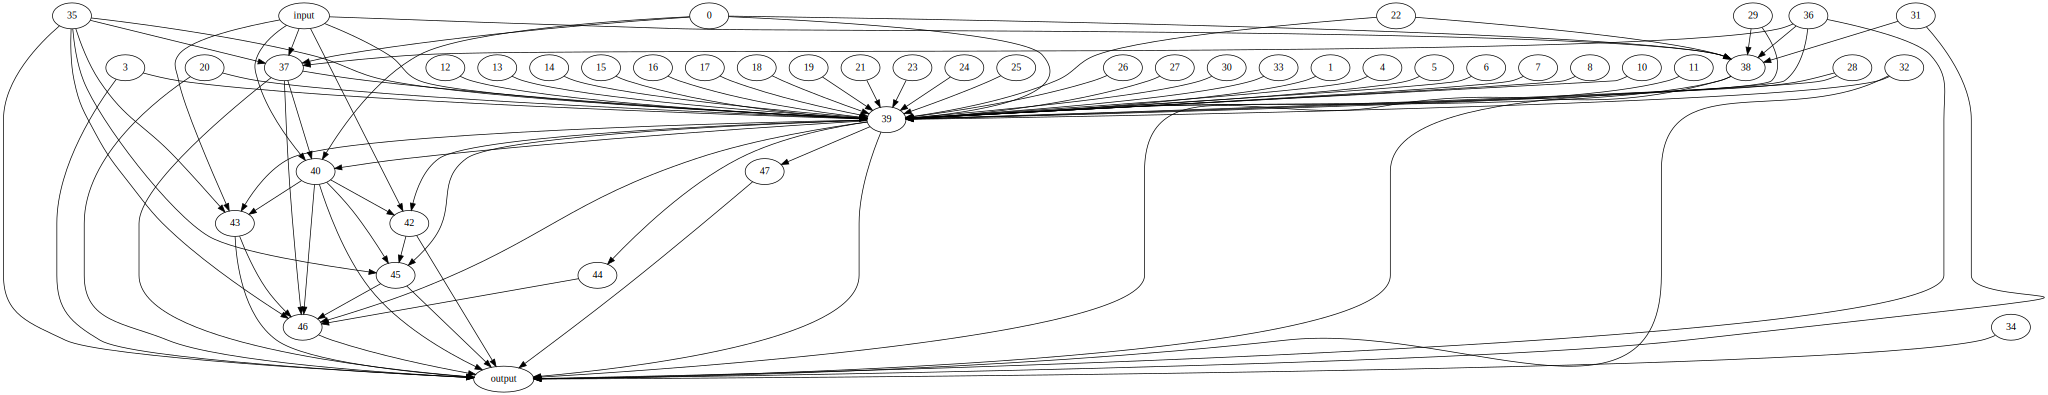

saved to checkpoint qxd30tuf/checkpoint 6.pkl
patching 948 edges, keeping 87 edges, 190 remain
patching 948 edges, keeping 87 edges, 190 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 36 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8520836234092712 which has diff 0.0013169050216674805 > 1e-05
patching 948 edges, keeping 88 edges, 189 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8478], device='cuda:0')
keeping edge edge  0 -> 36 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8478036522865295 which has diff 0.00559687614440918 > 1e-05
patching 948

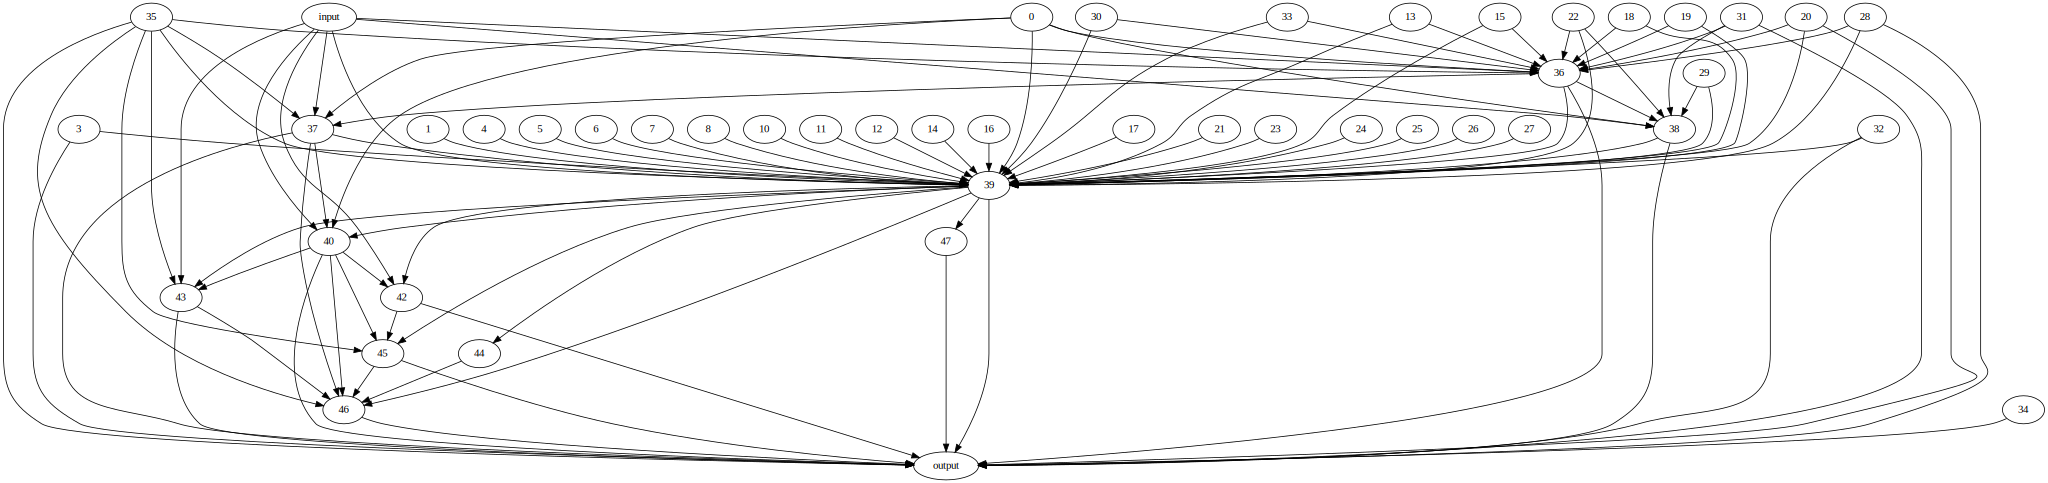

saved to checkpoint qxd30tuf/checkpoint 7.pkl
patching 948 edges, keeping 100 edges, 177 remain
patching 948 edges, keeping 100 edges, 177 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8532], device='cuda:0')
keeping edge edge  29 -> 34 (('blocks.29.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8532461524009705 which has diff 0.00015437602996826172 > 1e-05
patching 948 edges, keeping 101 edges, 176 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8524], device='cuda:0')
keeping edge edge  33 -> 34 (('blocks.33.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8524401783943176 which has diff 0.0009603500366210938 > 

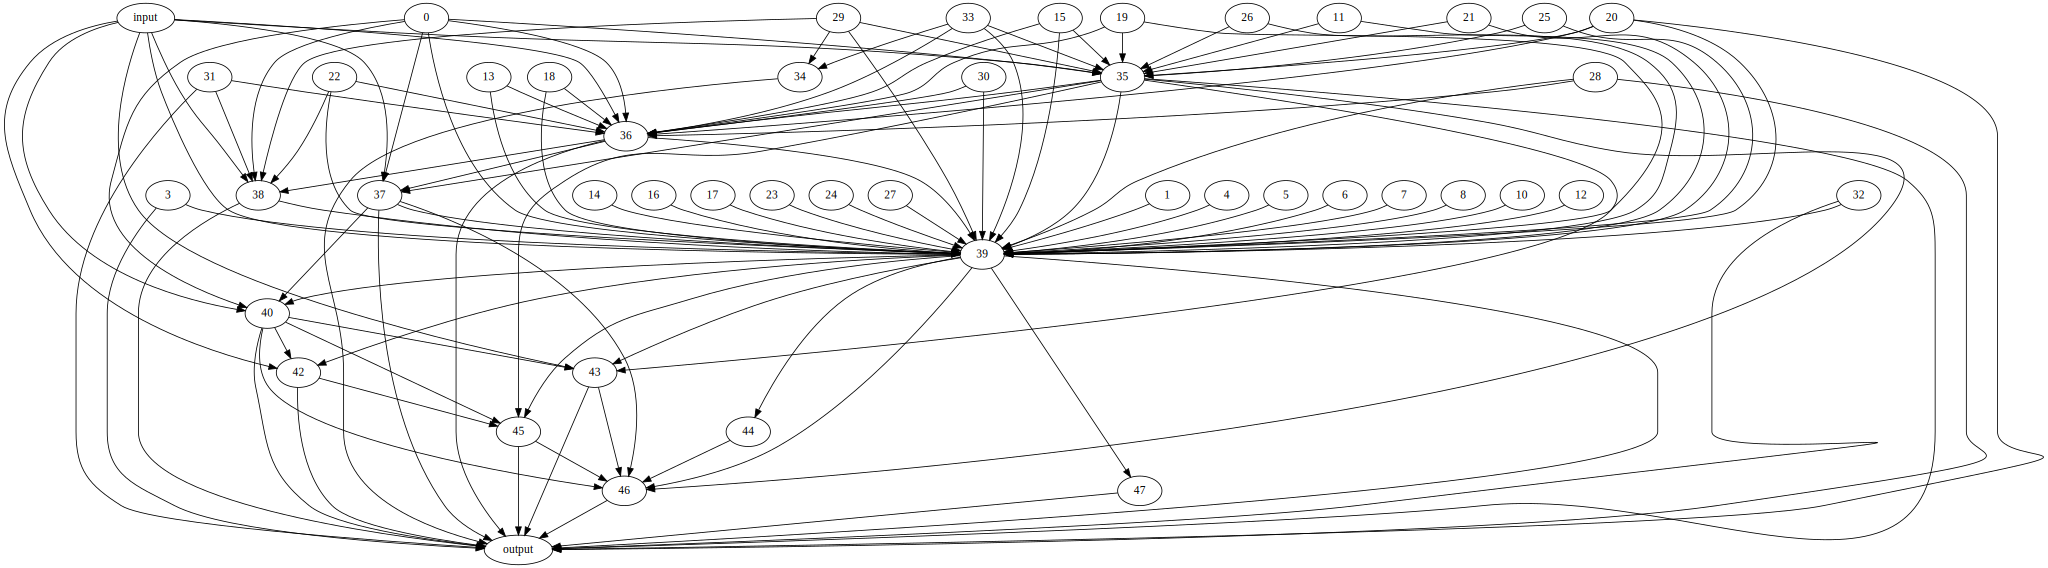

saved to checkpoint qxd30tuf/checkpoint 8.pkl
patching 948 edges, keeping 113 edges, 164 remain
patching 948 edges, keeping 113 edges, 164 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8522], device='cuda:0')
keeping edge edge  input -> 32 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521581292152405 which has diff 0.0012423992156982422 > 1e-05
patching 948 edges, keeping 114 edges, 163 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8503], device='cuda:0')
keeping edge edge  0 -> 32 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8502621054649353 which has diff 0.00313842296

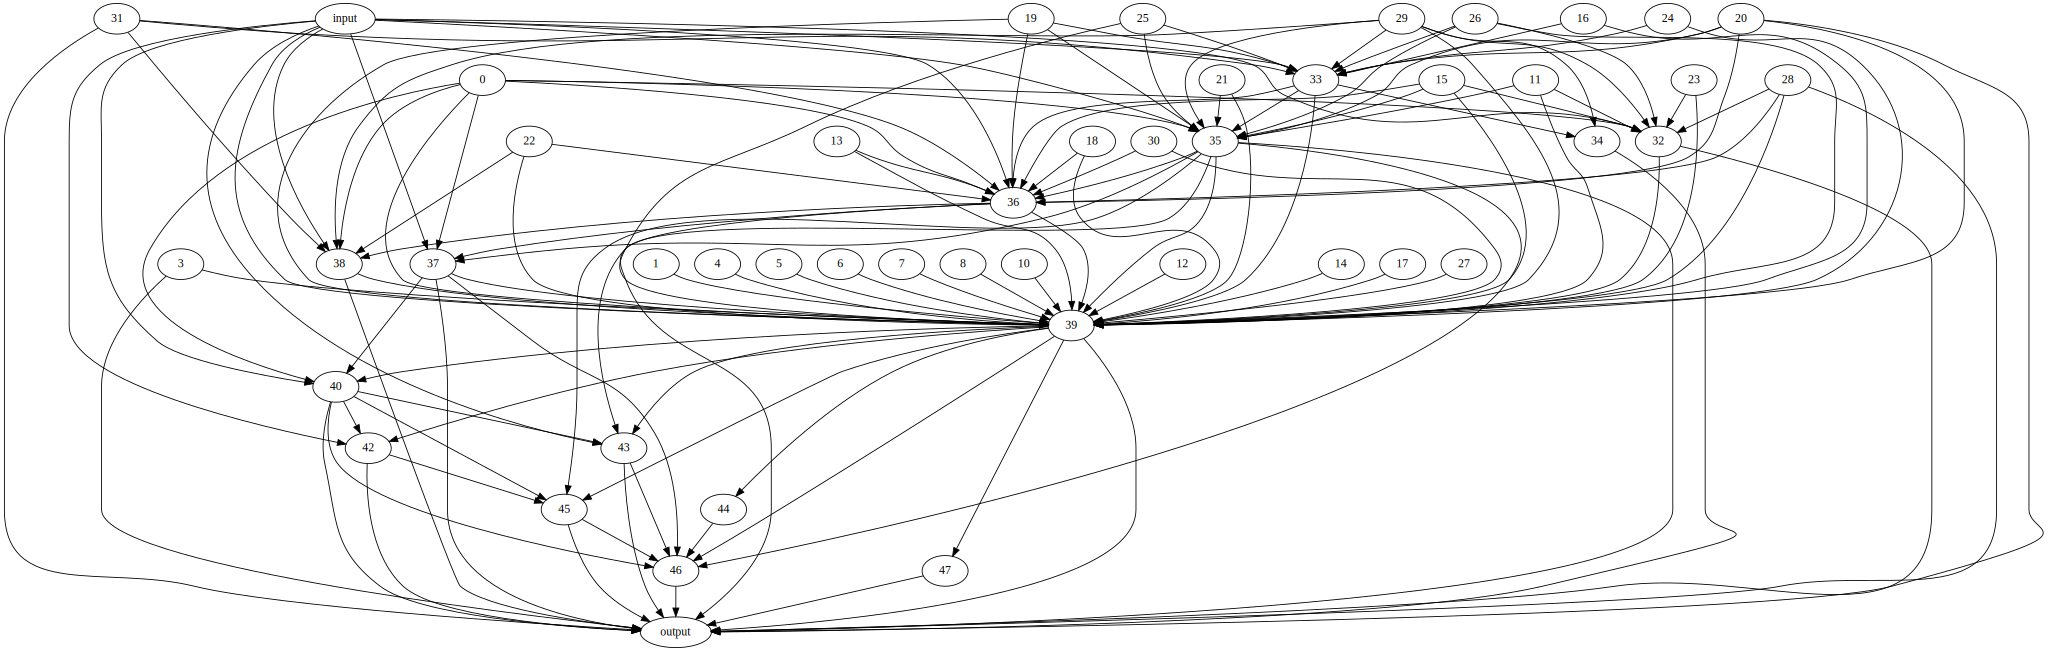

saved to checkpoint qxd30tuf/checkpoint 9.pkl
patching 948 edges, keeping 130 edges, 147 remain
patching 948 edges, keeping 130 edges, 147 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda:0')
keeping edge edge  input -> 31 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8528454303741455 which has diff 0.0005550980567932129 > 1e-05
patching 948 edges, keeping 131 edges, 146 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8499], device='cuda:0')
keeping edge edge  0 -> 31 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8499212265014648 which has diff 0.003479301929473877 > 1e-05
patching 948 edges, keeping 132 

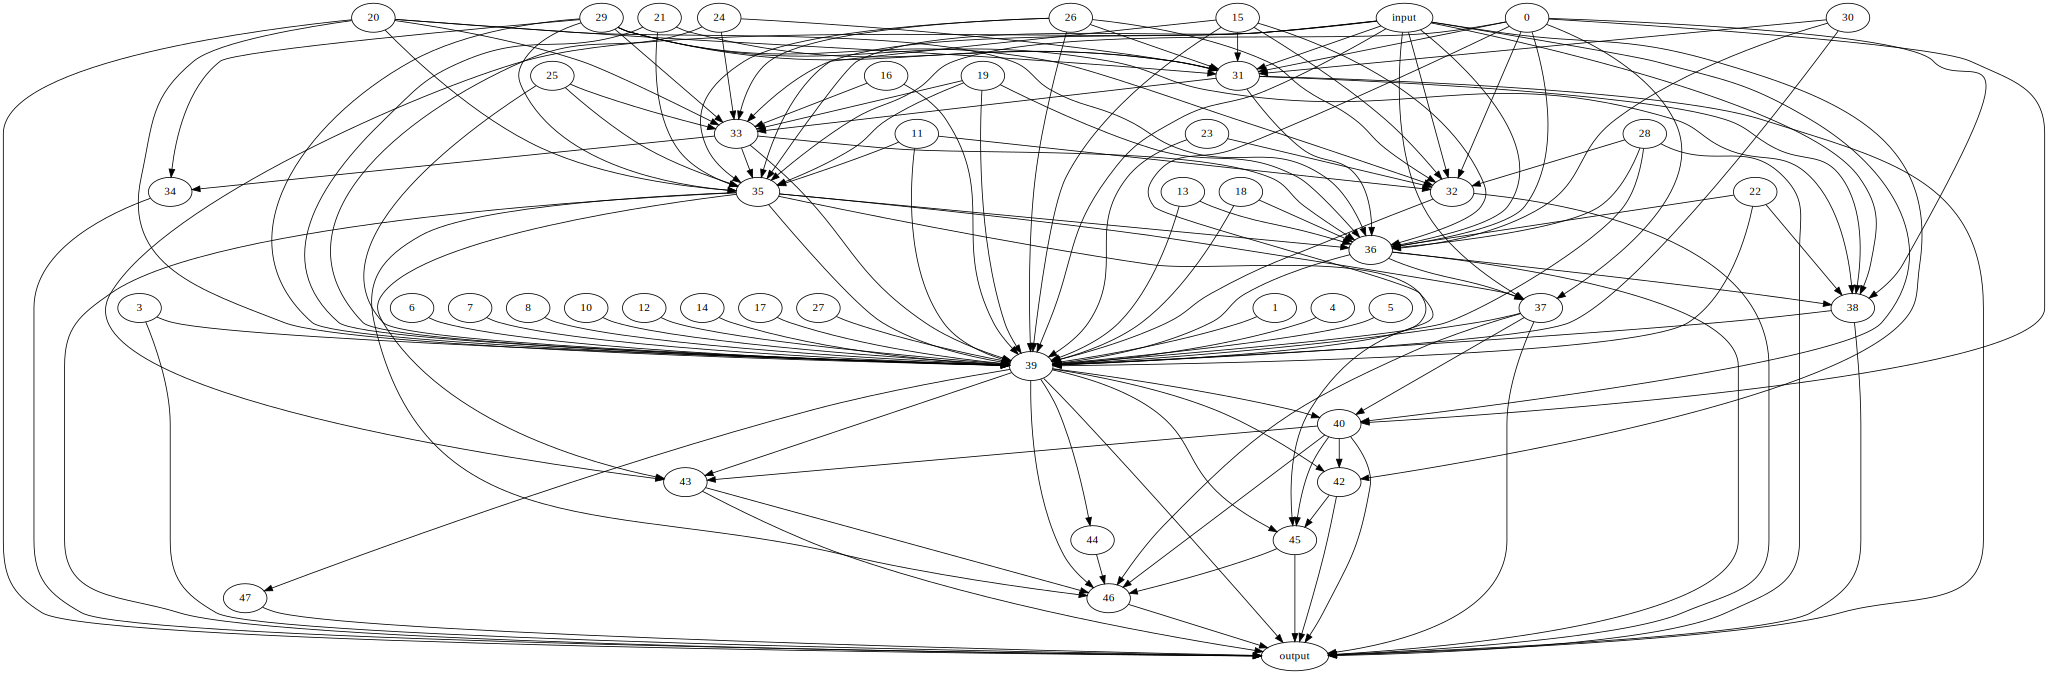

saved to checkpoint qxd30tuf/checkpoint 10.pkl
patching 948 edges, keeping 139 edges, 138 remain
patching 948 edges, keeping 139 edges, 138 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8520], device='cuda:0')
keeping edge edge  input -> 30 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8520423769950867 which has diff 0.0013581514358520508 > 1e-05
patching 948 edges, keeping 140 edges, 137 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8476], device='cuda:0')
keeping edge edge  0 -> 30 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8476080298423767 which has diff 0.005792498588562012 > 1e-05
patchin

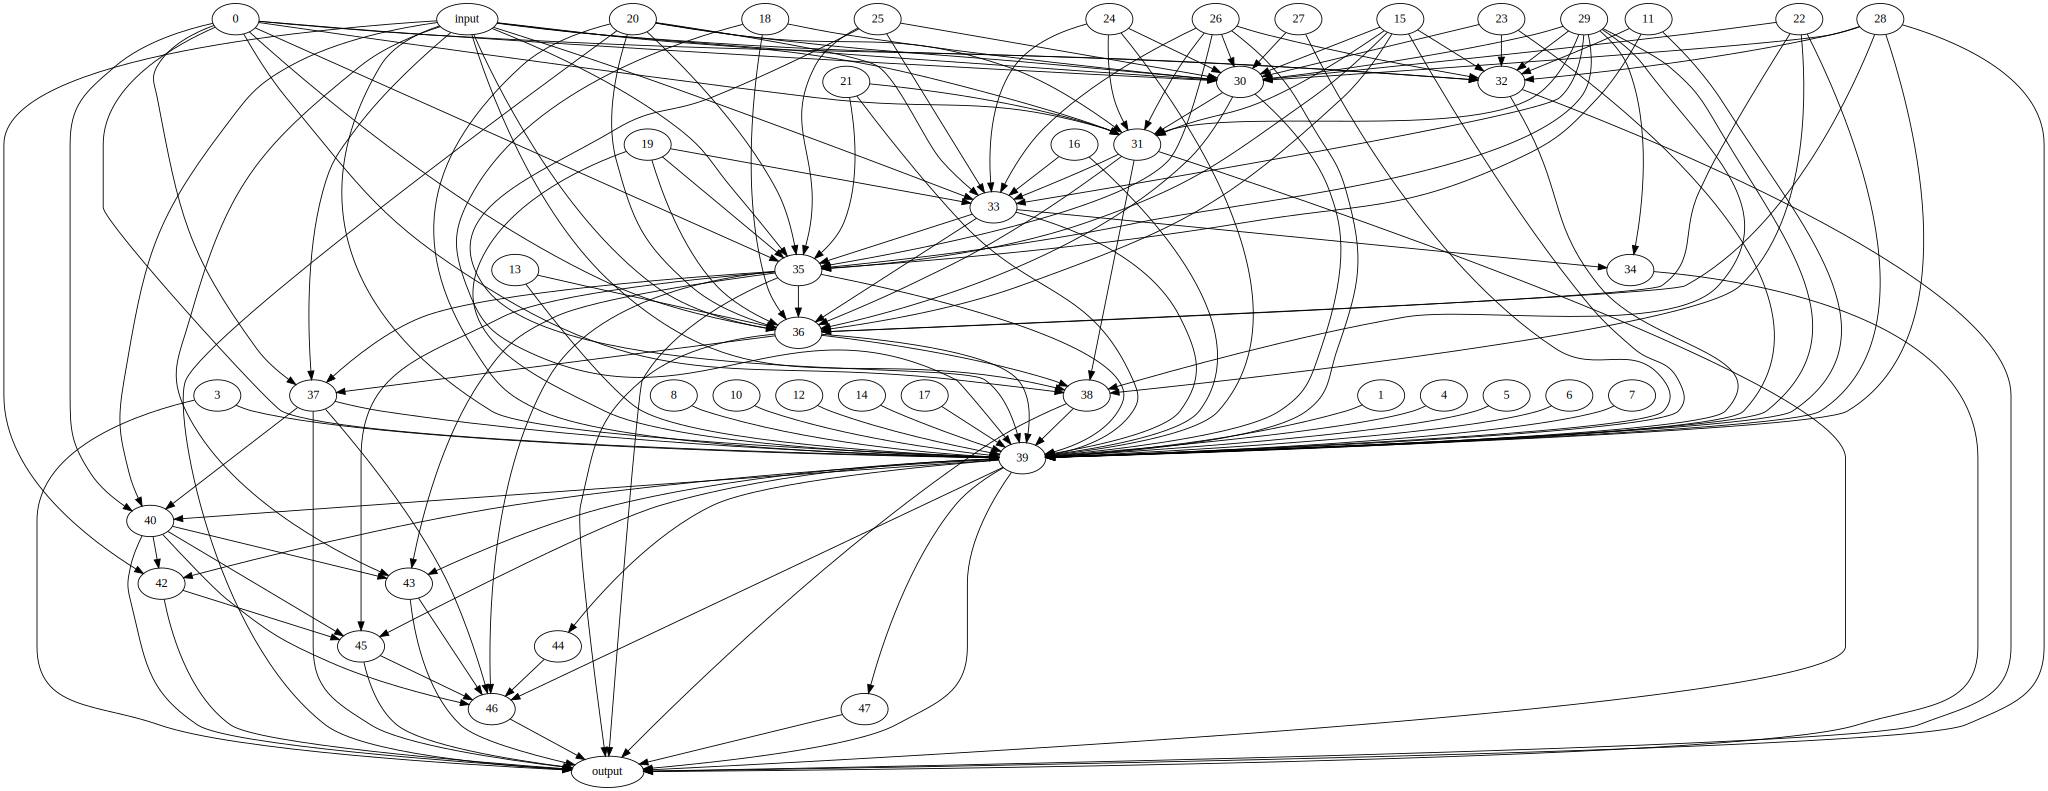

saved to checkpoint qxd30tuf/checkpoint 11.pkl
patching 948 edges, keeping 152 edges, 125 remain
patching 948 edges, keeping 152 edges, 125 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8515], device='cuda:0')
keeping edge edge  input -> 27 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8514745235443115 which has diff 0.0019260048866271973 > 1e-05
patching 948 edges, keeping 153 edges, 124 remain
baseline score 0.8534005284309387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8459], device='cuda:0')
keeping edge edge  0 -> 27 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f

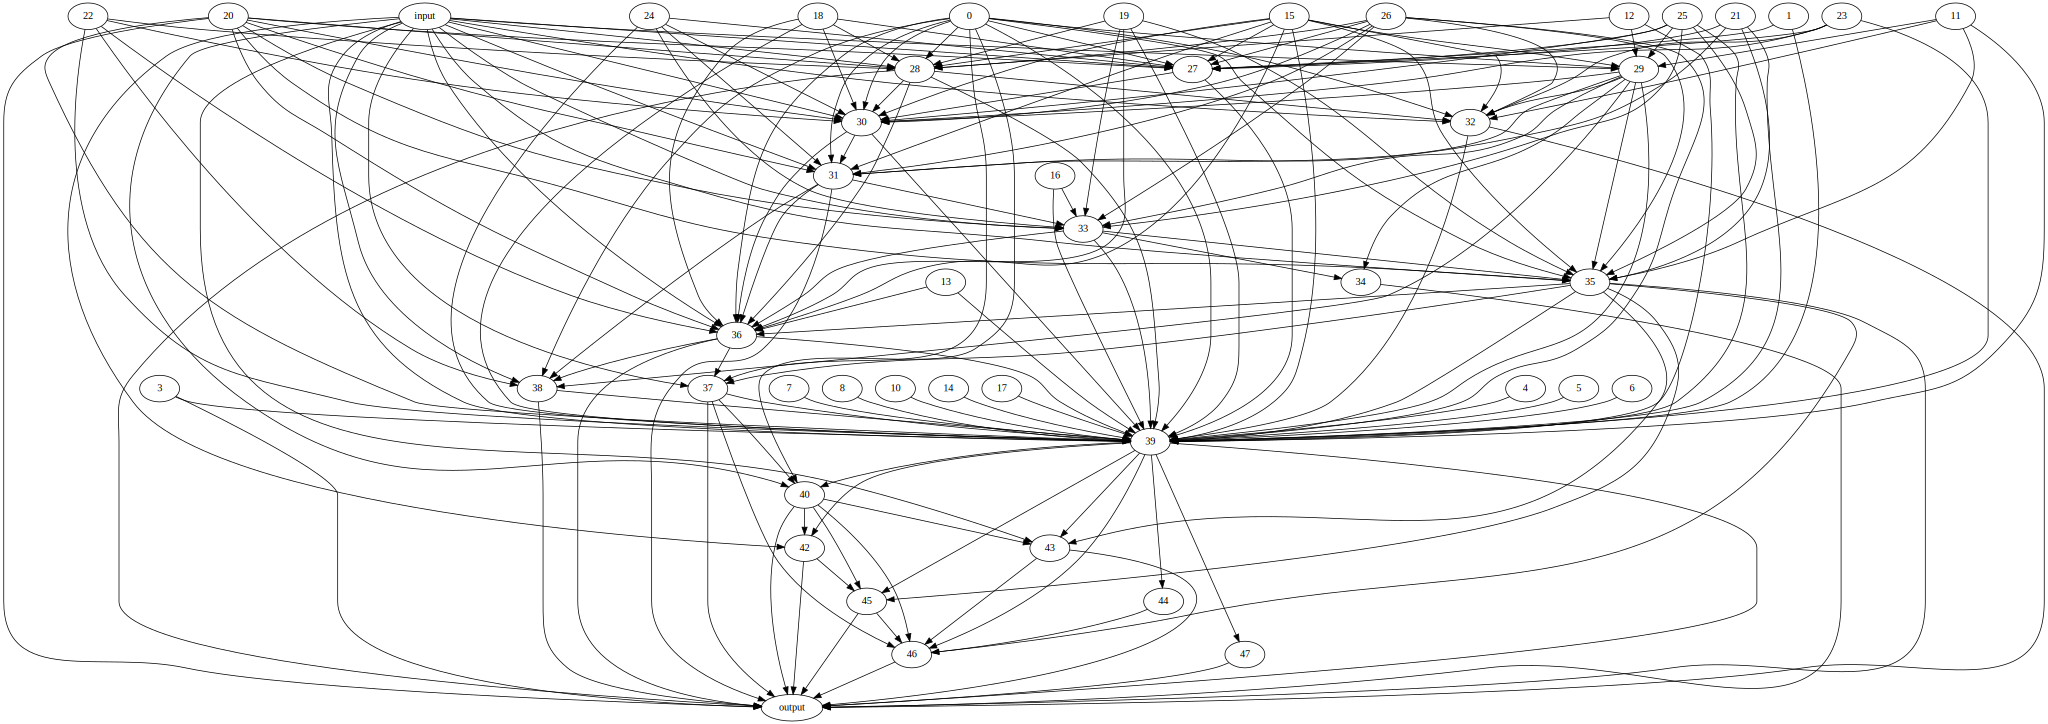

saved to checkpoint qxd30tuf/checkpoint 12.pkl
patching 951 edges, keeping 178 edges, 96 remain
patching 951 edges, keeping 178 edges, 96 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 25 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521130084991455 which has diff 0.0013832449913024902 > 1e-05
patching 951 edges, keeping 179 edges, 95 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8464], device='cuda:0')
keeping edge edge  0 -> 25 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8463645577430725 which has diff 0.007131695747375488 > 1e-05
patching 951

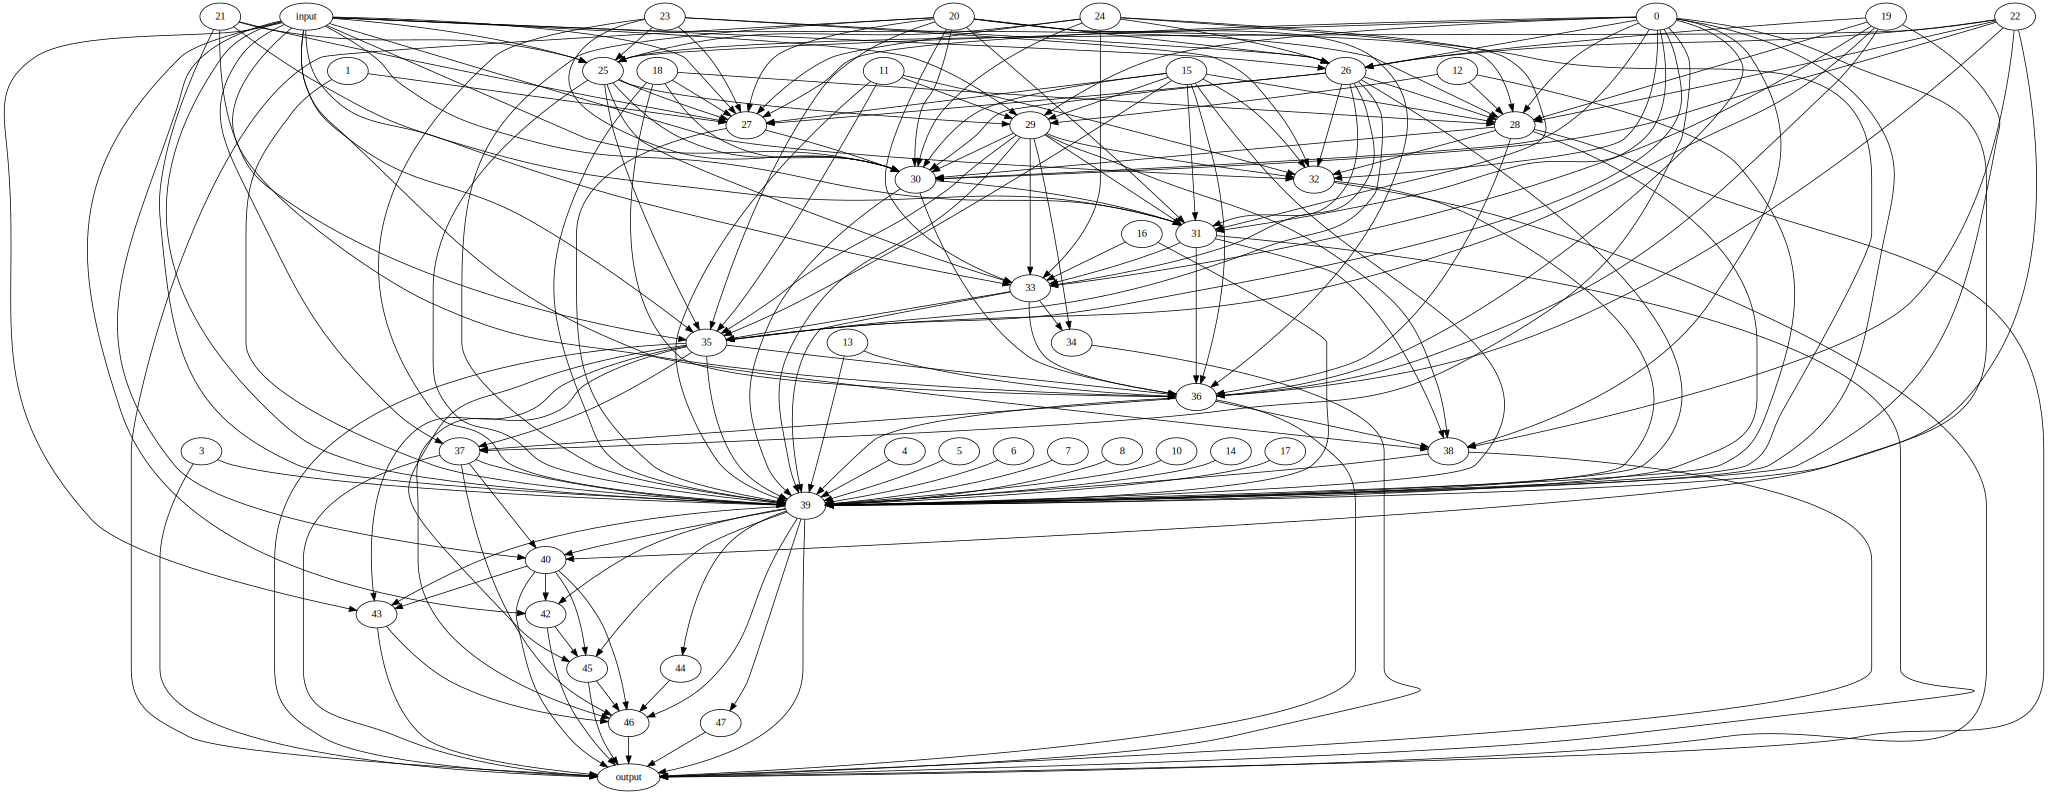

saved to checkpoint qxd30tuf/checkpoint 13.pkl
patching 951 edges, keeping 191 edges, 83 remain
patching 951 edges, keeping 191 edges, 83 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8503], device='cuda:0')
keeping edge edge  input -> 23 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8503088355064392 which has diff 0.003187417984008789 > 1e-05
patching 951 edges, keeping 192 edges, 82 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8529], device='cuda:0')
keeping edge edge  12 -> 23 (('blocks.12.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8529137969017029 which has diff 0.0005824565887451172 > 1e-05
patching 951 edges, keeping 193 edges, 8

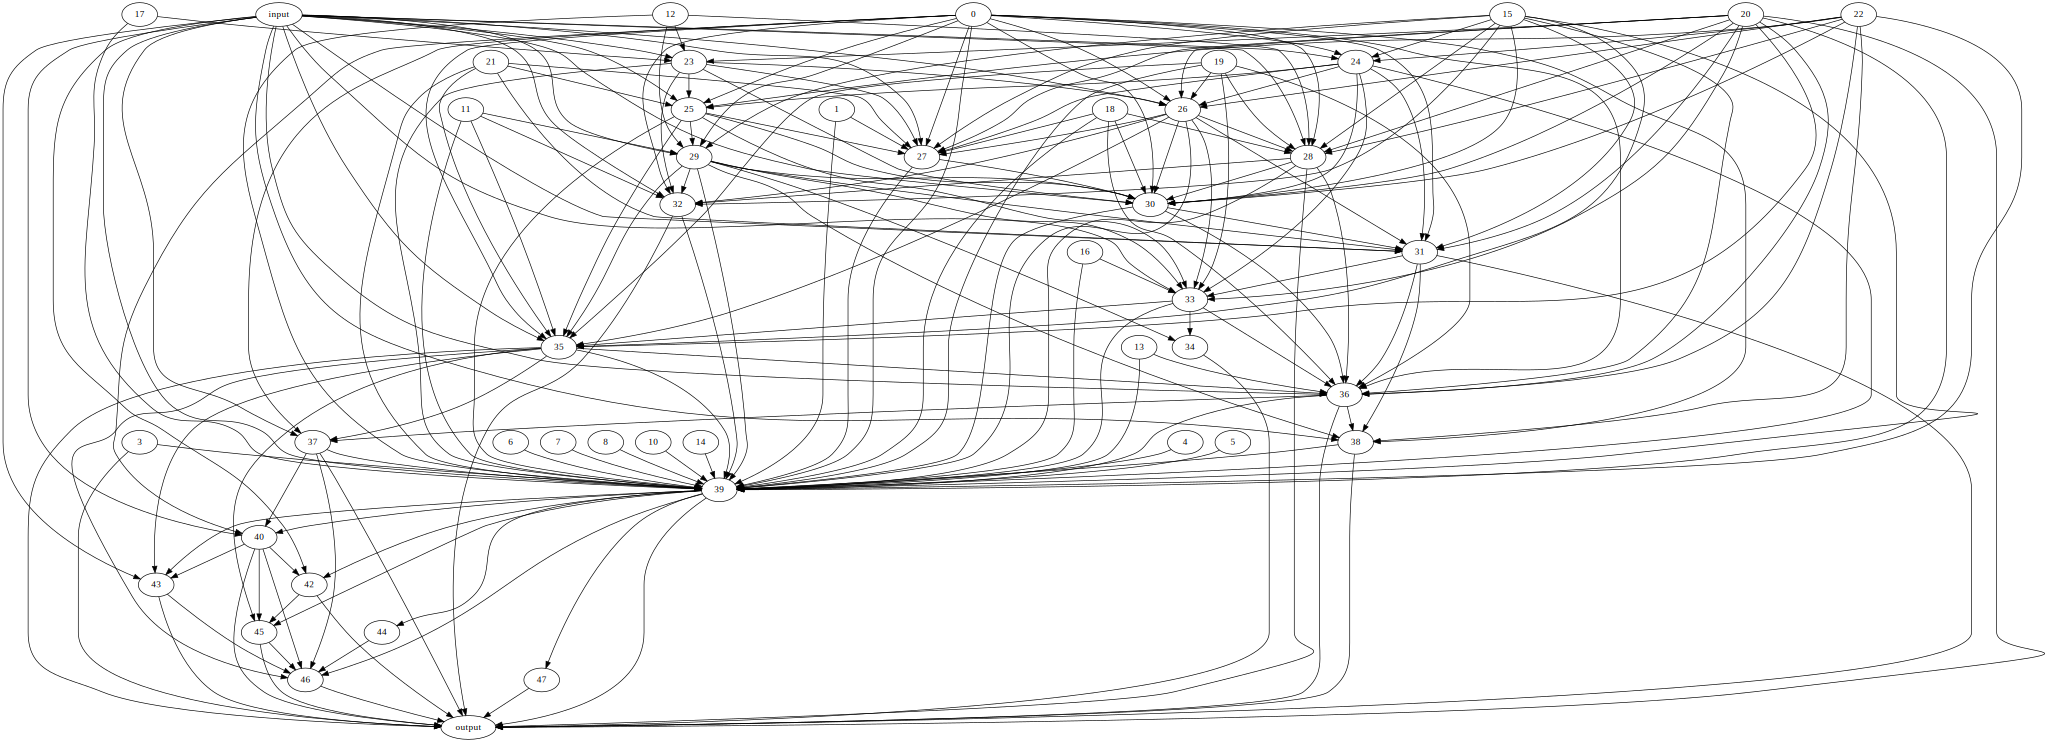

saved to checkpoint qxd30tuf/checkpoint 14.pkl
patching 951 edges, keeping 199 edges, 75 remain
patching 951 edges, keeping 199 edges, 75 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8493], device='cuda:0')
keeping edge edge  input -> 22 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8493075370788574 which has diff 0.004188716411590576 > 1e-05
patching 951 edges, keeping 200 edges, 74 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8450], device='cuda:0')
keeping edge edge  0 -> 22 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8450297117233276 which has diff 0.008466541767120361 > 1e-05
patching 951 edges, keeping 201 edges, 73 remain


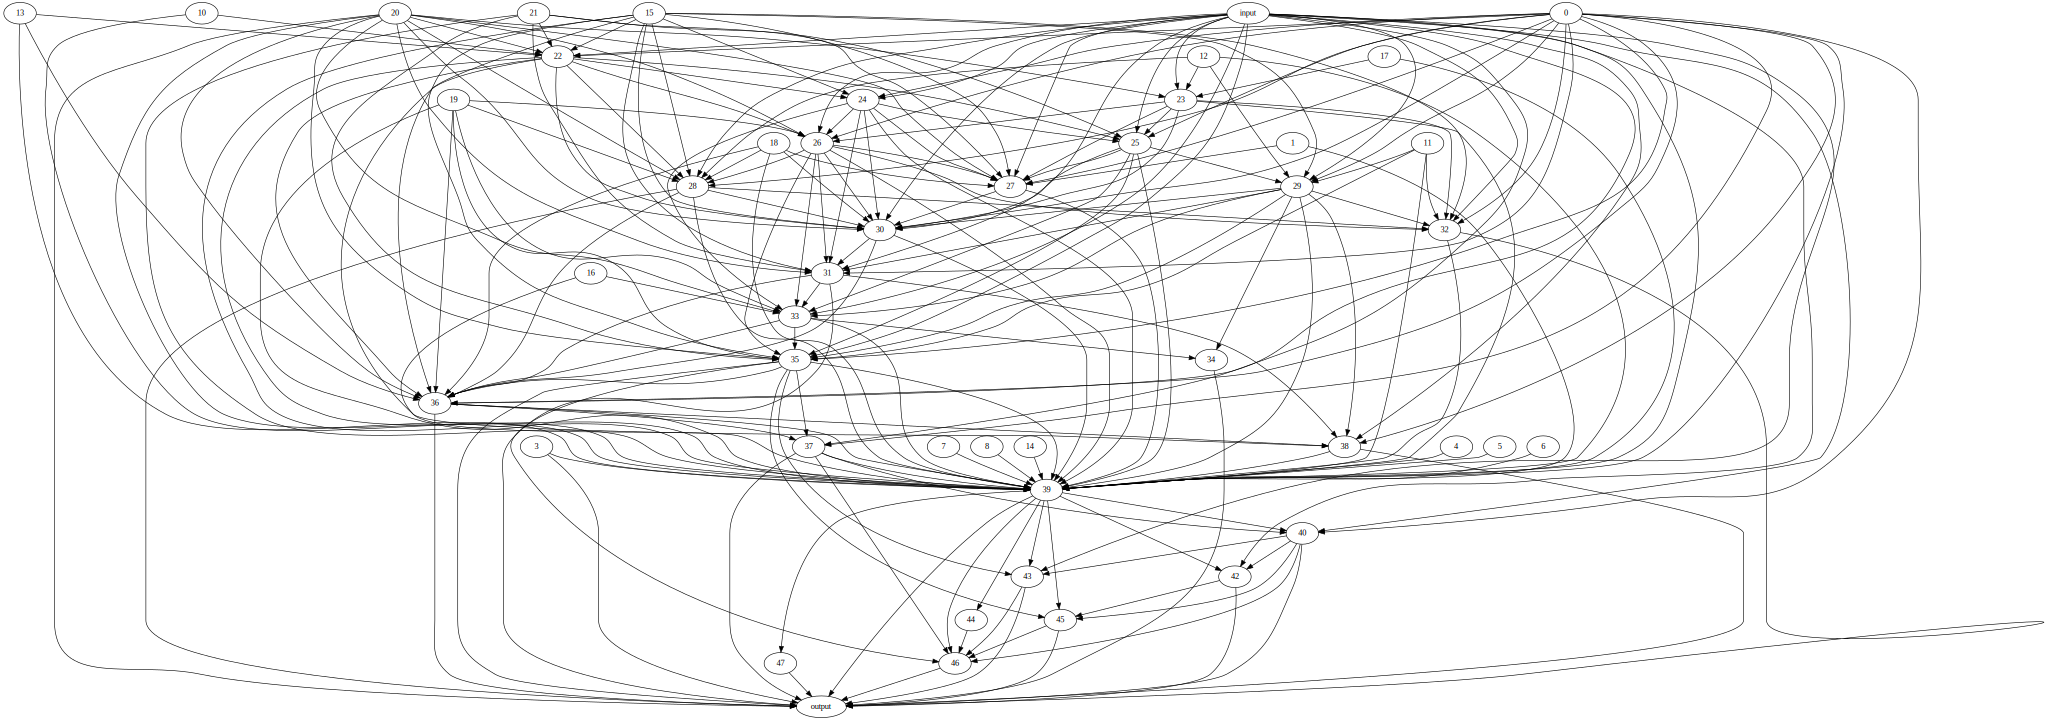

saved to checkpoint qxd30tuf/checkpoint 15.pkl
patching 951 edges, keeping 206 edges, 68 remain
patching 951 edges, keeping 206 edges, 68 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8456], device='cuda:0')
keeping edge edge  input -> 19 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8455649614334106 which has diff 0.007931292057037354 > 1e-05
patching 951 edges, keeping 207 edges, 67 remain
baseline score 0.853496253490448
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8303], device='cuda:0')
keeping edge edge  0 -> 19 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8302904963493347 which has diff 0.02320575714111328 > 1e

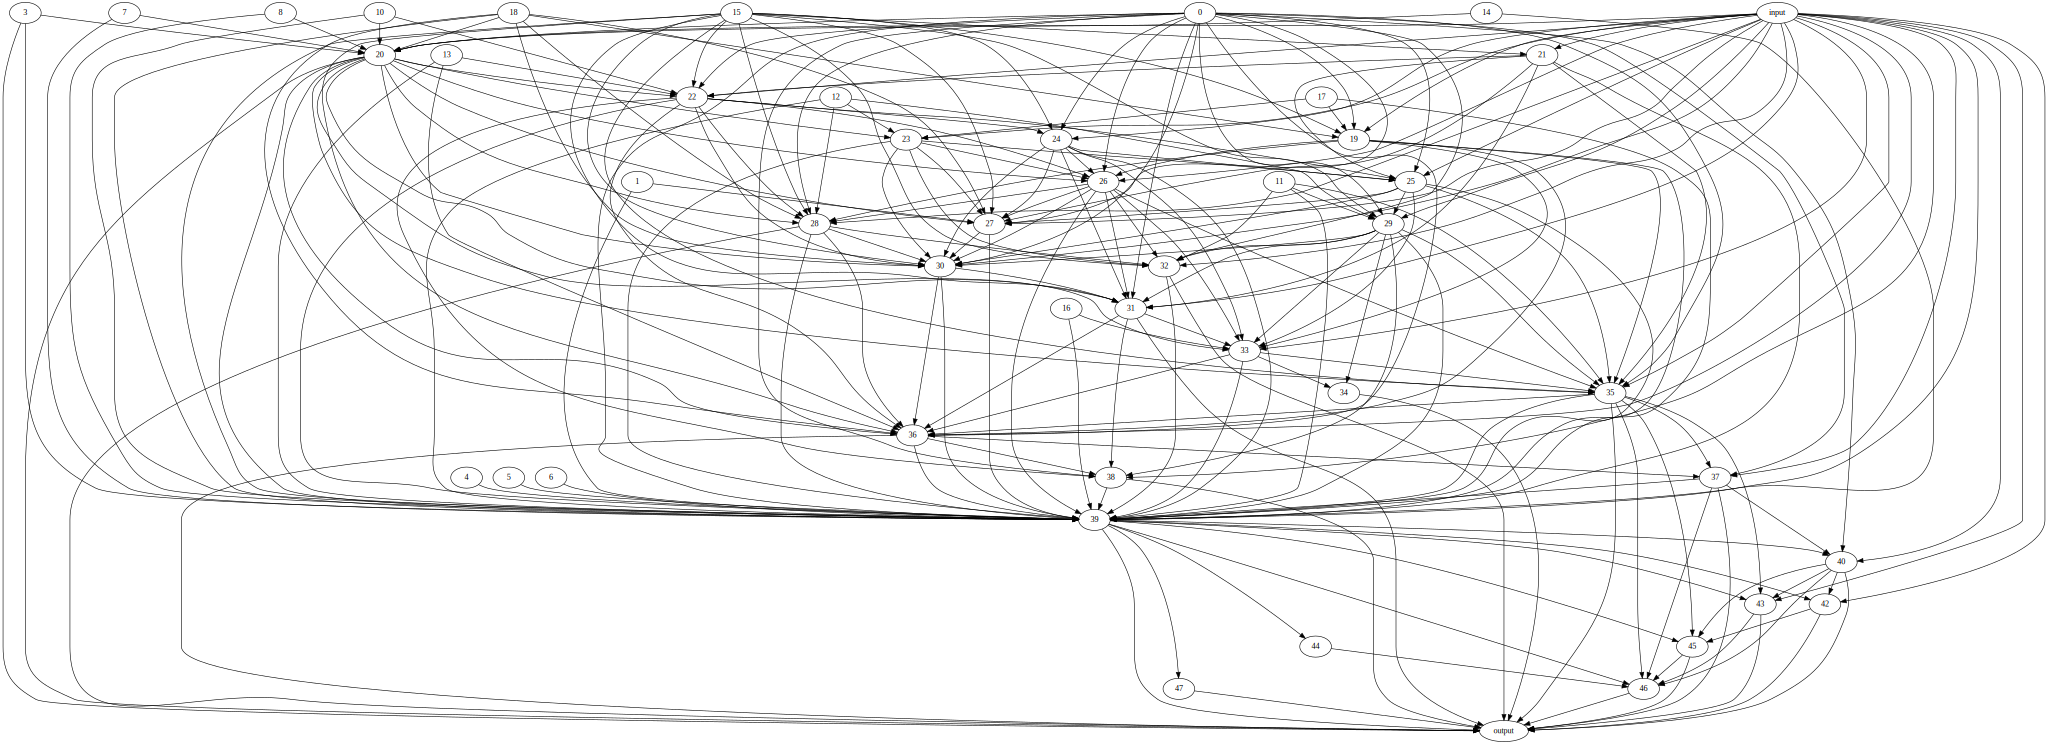

saved to checkpoint qxd30tuf/checkpoint 16.pkl
patching 952 edges, keeping 221 edges, 52 remain
patching 952 edges, keeping 221 edges, 52 remain
baseline score 0.8537763953208923
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8514], device='cuda:0')
keeping edge edge  input -> 17 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8513938188552856 which has diff 0.0023825764656066895 > 1e-05
patching 952 edges, keeping 222 edges, 51 remain
baseline score 0.8537763953208923
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8479], device='cuda:0')
keeping edge edge  0 -> 17 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8479130864143372 which has diff 0.005863308906555176 > 1e-05
patching 9

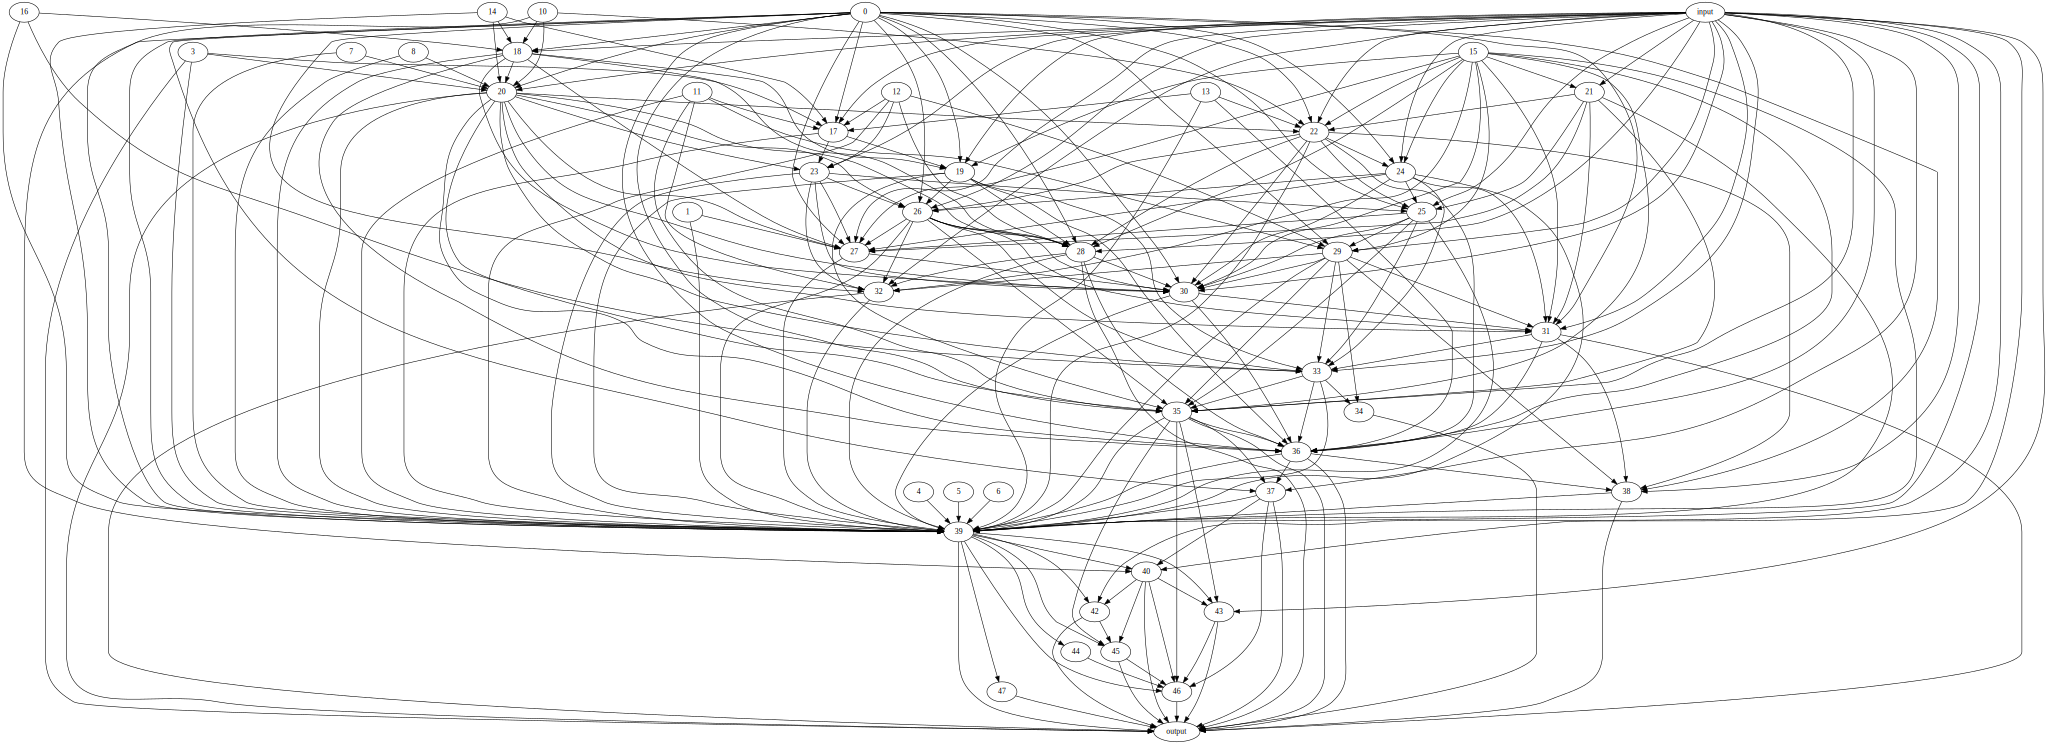

saved to checkpoint qxd30tuf/checkpoint 17.pkl
patching 953 edges, keeping 233 edges, 39 remain
patching 953 edges, keeping 233 edges, 39 remain
baseline score 0.853825569152832
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8398], device='cuda:0')
keeping edge edge  input -> 15 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8397976756095886 which has diff 0.014027893543243408 > 1e-05
patching 953 edges, keeping 234 edges, 38 remain
baseline score 0.853825569152832
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8215], device='cuda:0')
keeping edge edge  0 -> 15 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8214572072029114 which has diff 0.032368361949920654 > 1e-05
patching 953 edges, keeping 235 edges

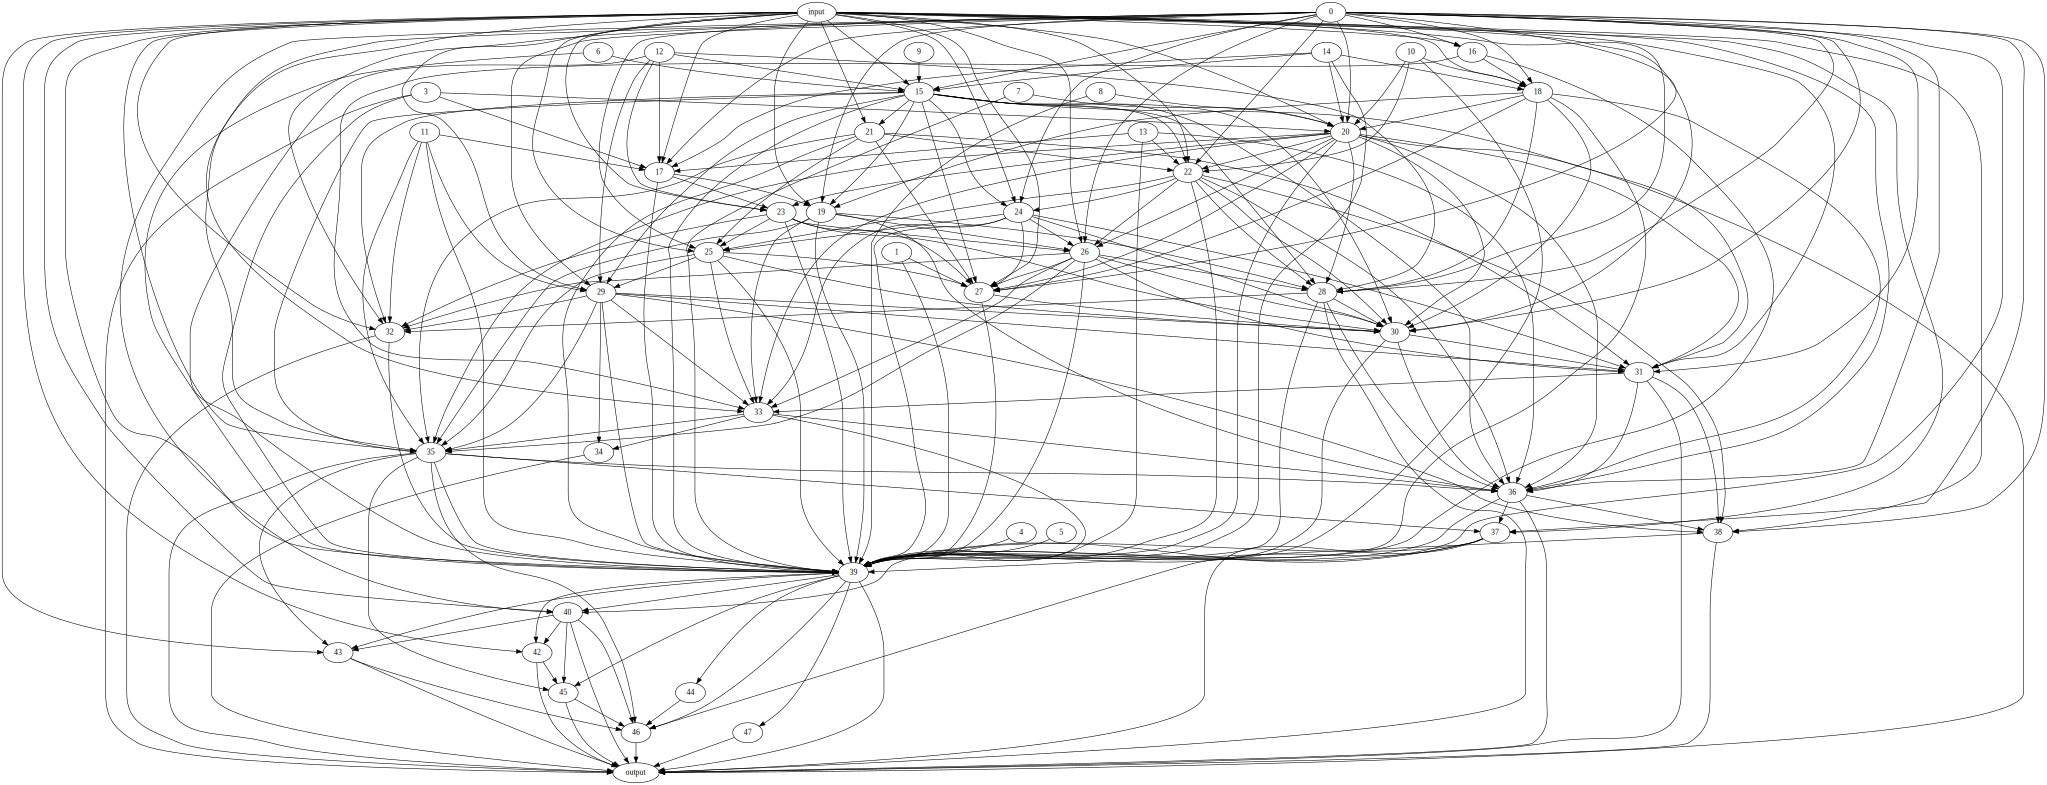

saved to checkpoint qxd30tuf/checkpoint 18.pkl
patching 954 edges, keeping 241 edges, 30 remain
patching 954 edges, keeping 241 edges, 30 remain
baseline score 0.8540849089622498
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8497], device='cuda:0')
keeping edge edge  input -> 13 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.849747896194458 which has diff 0.004337012767791748 > 1e-05
patching 954 edges, keeping 242 edges, 29 remain
baseline score 0.8540849089622498
[1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8492], device='cuda:0')
keeping edge edge  0 -> 13 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8492135405540466 which has diff 0.004871368408203125 > 1e-05
patching 954 edges, keeping 243 edges, 28 remain
basel

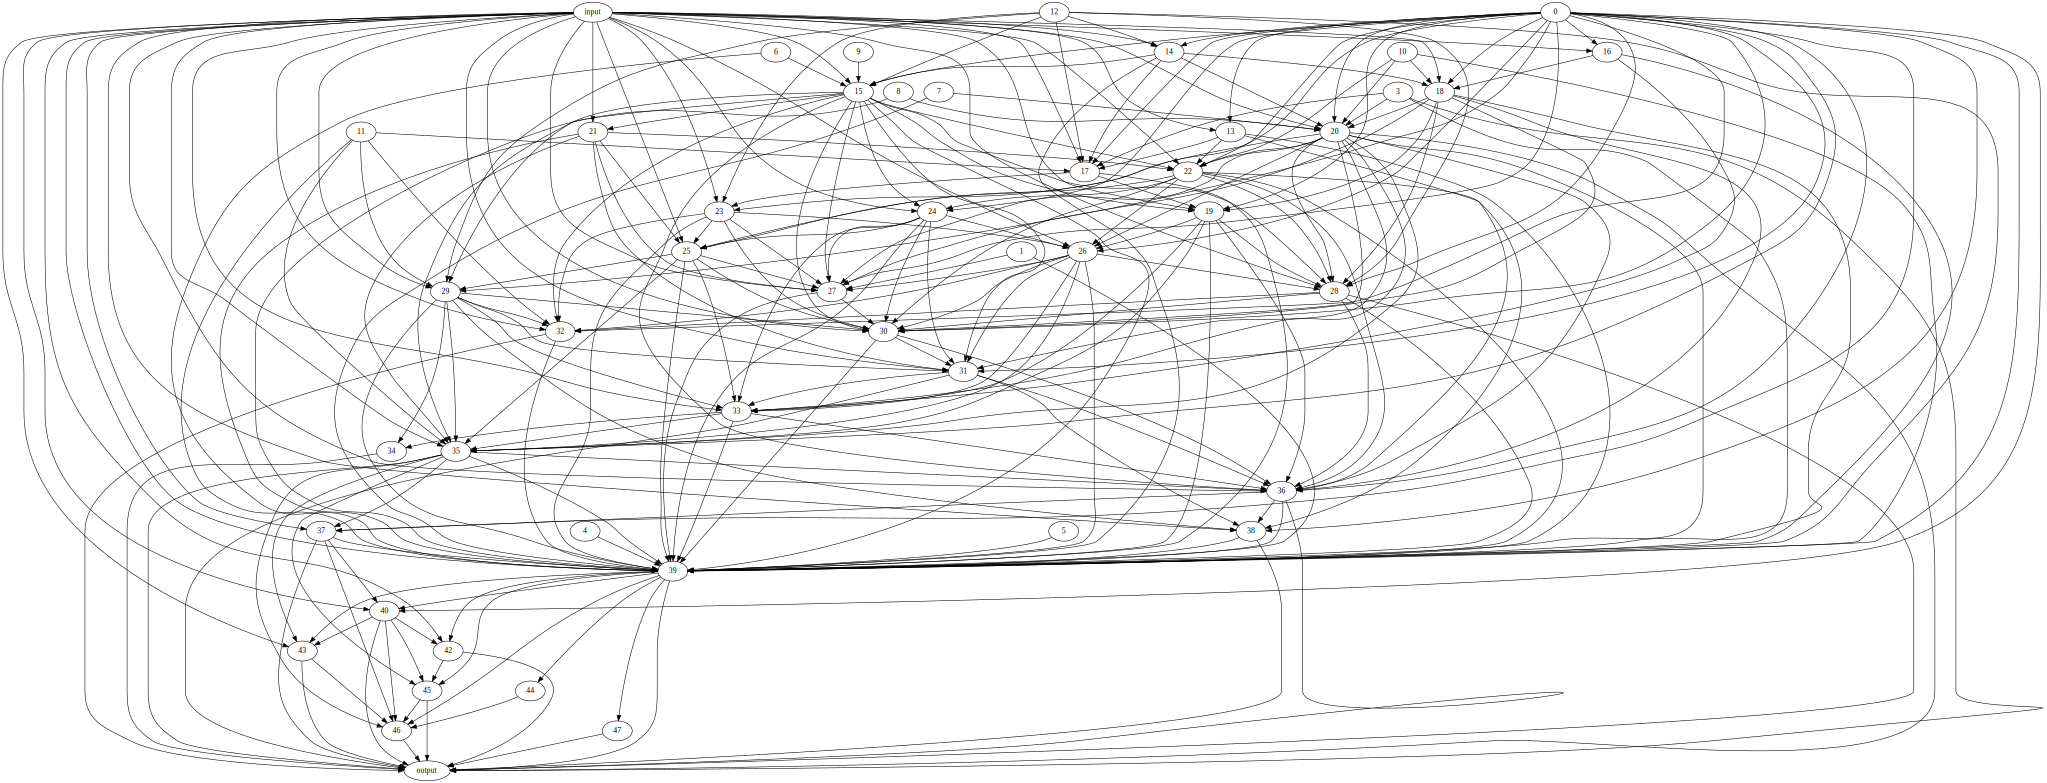

saved to checkpoint qxd30tuf/checkpoint 19.pkl
patching 955 edges, keeping 246 edges, 24 remain
patching 955 edges, keeping 246 edges, 24 remain
baseline score 0.8541296124458313
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8496], device='cuda:0')
keeping edge edge  input -> 12 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8496072292327881 which has diff 0.004522383213043213 > 1e-05
patching 955 edges, keeping 247 edges, 23 remain
baseline score 0.8541296124458313
[1, 1] sized edge sets remaining
got scores tensor([0.8483], device='cuda:0')
keeping edge edge  0 -> 12 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.848294198513031 which has diff 0.005835413932800293 > 1e-05
patching 955 edges, keeping 248 edges, 22 remain
baseline score 0.854129

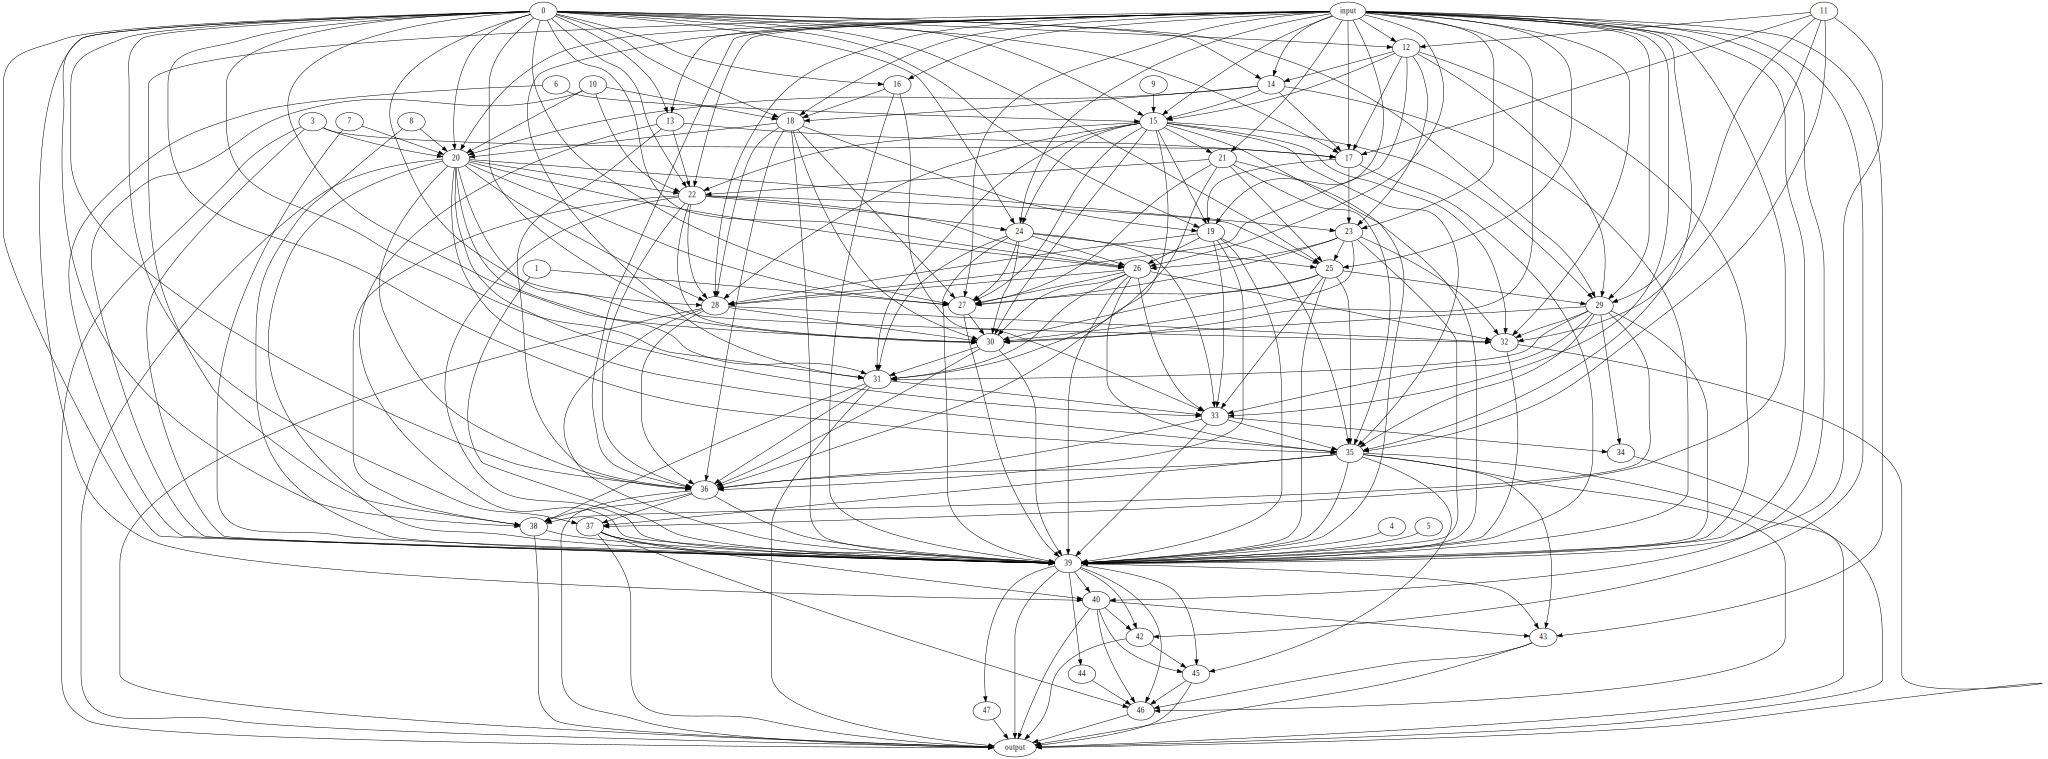

saved to checkpoint qxd30tuf/checkpoint 20.pkl
patching 955 edges, keeping 249 edges, 21 remain
patching 955 edges, keeping 249 edges, 21 remain
baseline score 0.8541296124458313
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8473], device='cuda:0')
keeping edge edge  input -> 11 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.11.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8473272323608398 which has diff 0.006802380084991455 > 1e-05
patching 955 edges, keeping 250 edges, 20 remain
baseline score 0.8541296124458313
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8467], device='cuda:0')
keeping edge edge  0 -> 11 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.11.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.846721351146698 which has diff 0.007408261299133301 > 1e-05
patching 955 edges, keeping 251 edges, 19 remain
baseline score 0.

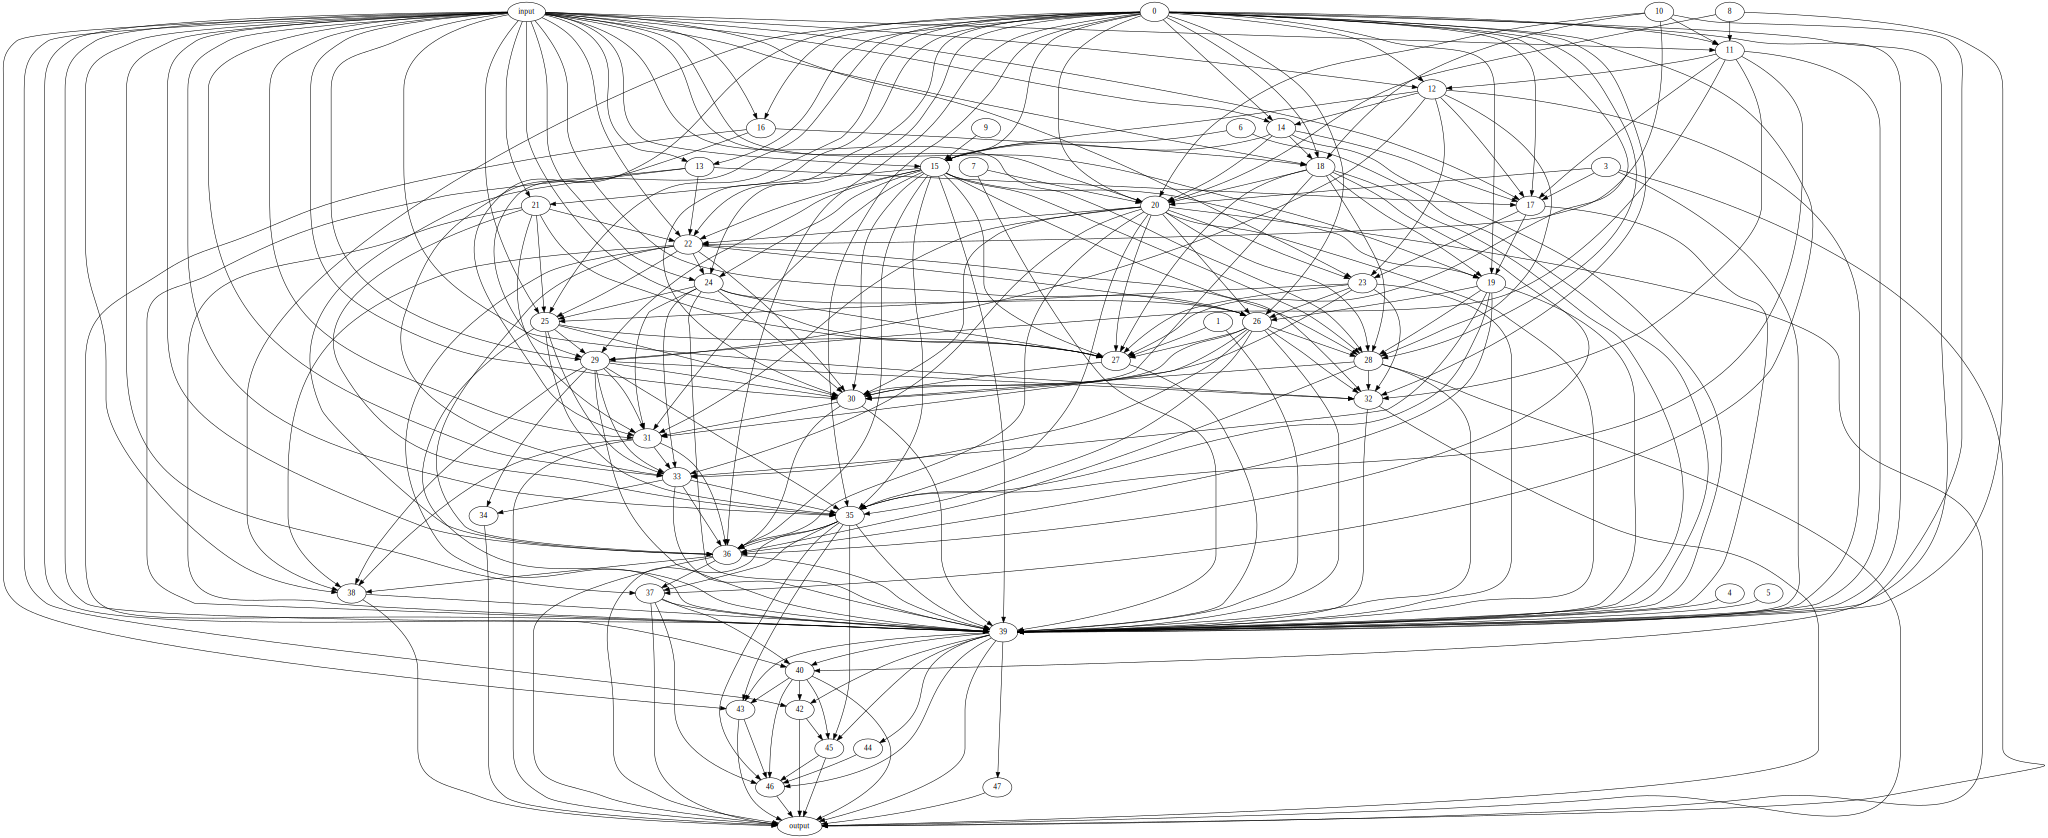

saved to checkpoint qxd30tuf/checkpoint 21.pkl
patching 955 edges, keeping 253 edges, 17 remain
patching 955 edges, keeping 253 edges, 17 remain
baseline score 0.8541296124458313
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8516], device='cuda:0')
keeping edge edge  input -> 3 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.3.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8515810370445251 which has diff 0.0025485754013061523 > 1e-05
patching 955 edges, keeping 254 edges, 16 remain
baseline score 0.8541296124458313
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  0 -> 3 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.3.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8520699143409729 which has diff 0.0020596981048583984 > 1e-05
p

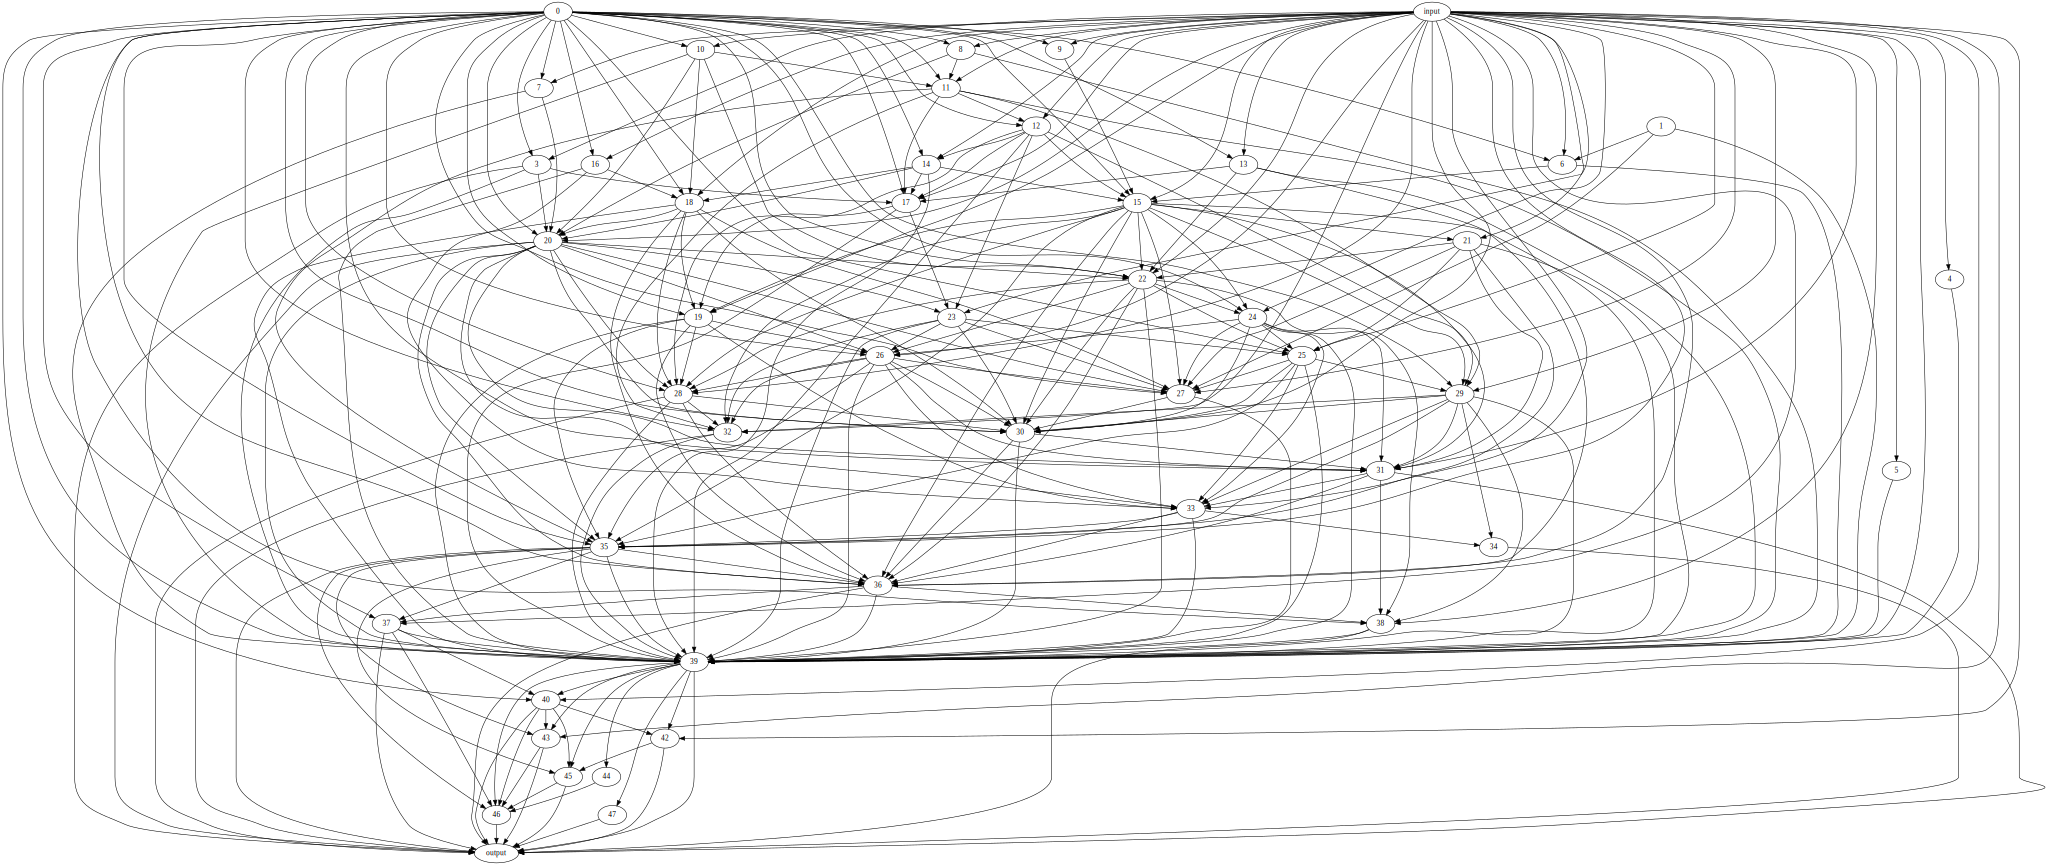

saved to checkpoint qxd30tuf/checkpoint 22.pkl
patching 955 edges, keeping 268 edges, 2 remain
patching 955 edges, keeping 268 edges, 2 remain
baseline score 0.8541296124458313
[1, 1] sized edge sets remaining
got scores tensor([0.2125], device='cuda:0')
keeping edge edge  input -> 0 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.0.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.21248020231723785 which has diff 0.6416494250297546 > 1e-05
patching 955 edges, keeping 269 edges, 1 remain
baseline score 0.8541296124458313
[1] sized edge sets remaining
got scores tensor([0.8514], device='cuda:0')
keeping edge edge  input -> 1 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.1.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8513509035110474 which has diff 0.0027787089347839355 > 1e-05
finished these edge sets
valid score 0.8500205874443054 valid acc 0.8675000071525574


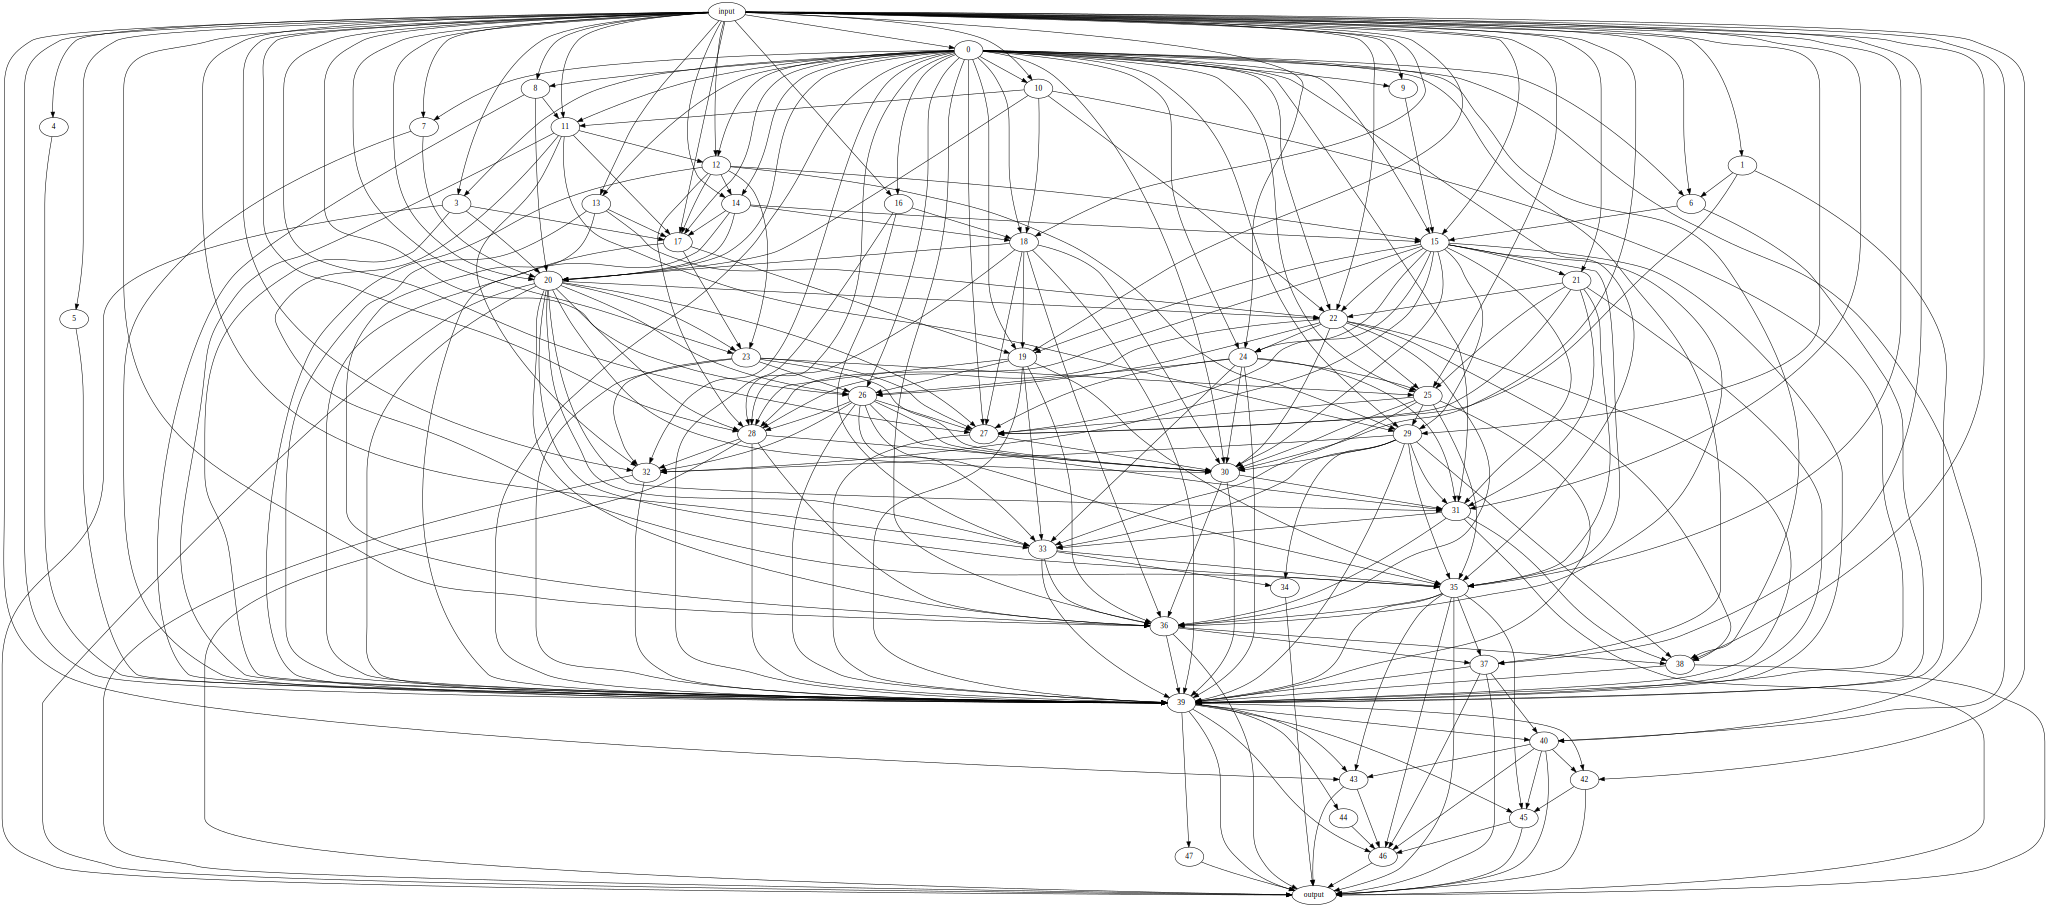

saved to checkpoint qxd30tuf/checkpoint 23.pkl
final output:


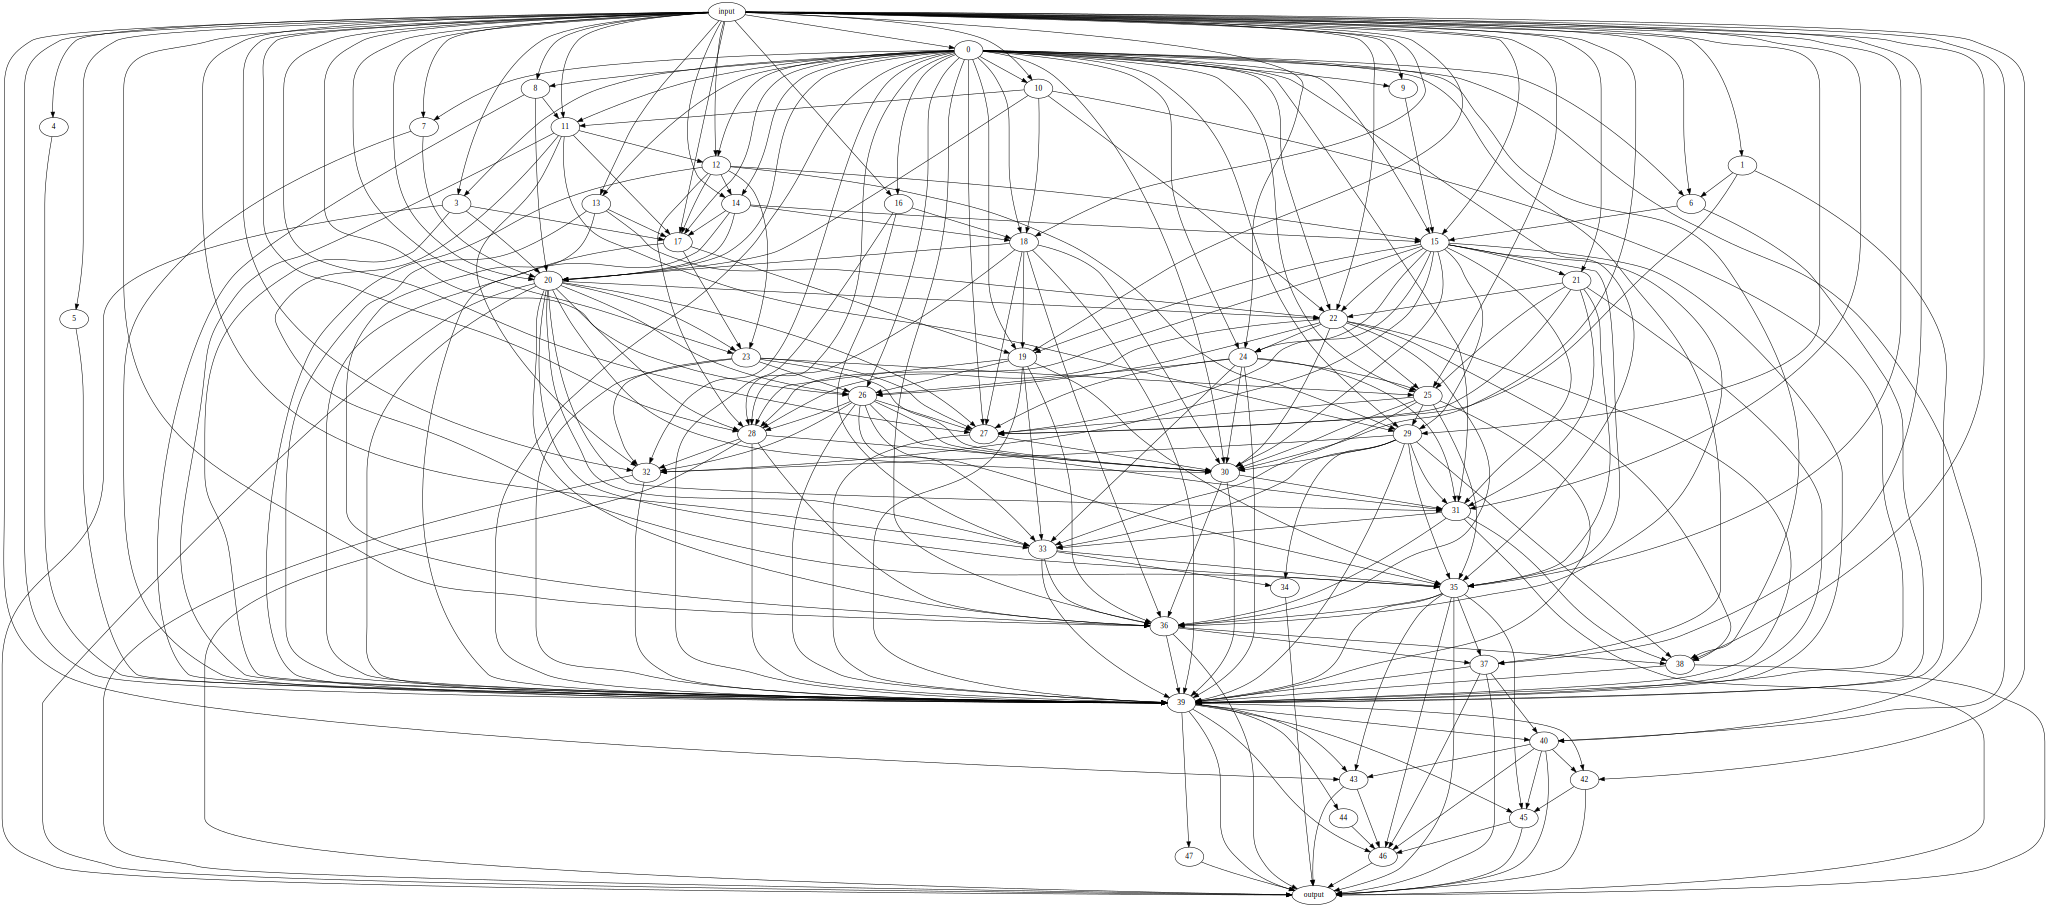

final score 0.8541296124458313
saved to checkpoint qxd30tuf/checkpoint 24 final.pkl


In [49]:


job_name_text = "IOI attr patching phase 2.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False
    
wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")

cfg.ckpt_directory = wandb_id
cfg.iter = 0
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

# reset them for another run
for edge in result_edges:
    if edge.checked and not edge.patching:
        edge.checked = False

result_edges_2 = run_acdc(model=model, data=data, cfg=cfg, edges=result_edges)
wandb.finish()

num edges 270


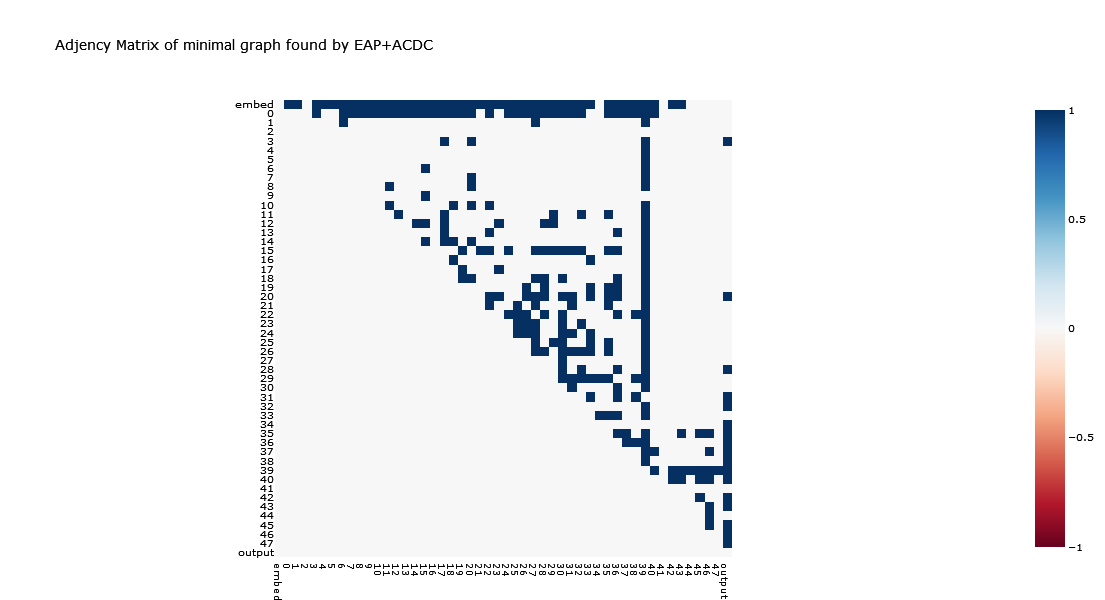

In [50]:
    
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2])
nodes = [INPUT_NODE] + [layer_node(layer) for layer in range(model.cfg.n_layers)] + [OUTPUT_NODE]
layer_names = ['embed'] + [str(i) for i in range(model.cfg.n_layers)] + ['output']
def node_to_i(node):
    return nodes.index(node)

num_edges = 0
for edge in result_edges_2:
    if edge.checked and not edge.patching:
        num_edges += 1
        adjacency_matrix[node_to_i(edge.input_node), node_to_i(edge.output_node)] = 1
print(f"num edges {num_edges}")
imshow(adjacency_matrix, x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='Adjency Matrix of minimal graph found by EAP+ACDC')






starting new run ut2w30i2


all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 959 edges, keeping 1 edges, 265 remain
patching 959 edges, keeping 1 edges, 265 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8524], device='cuda:0')
keeping edge edge  32 -> output (('blocks.32.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8523723483085632 which has diff 0.0015613436698913574 > 0.0001
patching 959 edges, keeping 2 edges, 264 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda

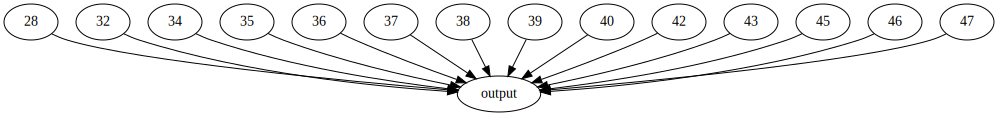

saved to checkpoint ut2w30i2/checkpoint 0.pkl
patching 959 edges, keeping 14 edges, 252 remain
patching 959 edges, keeping 14 edges, 252 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8531], device='cuda:0')
keeping edge edge  35 -> 46 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8530993461608887 which has diff 0.000834345817565918 > 0.0001
patching 959 edges, keeping 15 edges, 251 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8321], device='cuda:0')
keeping edge edge  39 -> 46 (('blocks.39.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8321119546890259 which has diff 0.02182173728942871 > 0.0001
patching 959 edges, keeping 16 edge

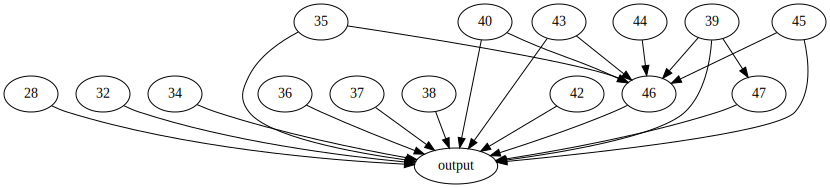

saved to checkpoint ut2w30i2/checkpoint 1.pkl
patching 959 edges, keeping 21 edges, 245 remain
patching 959 edges, keeping 21 edges, 245 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8538], device='cuda:0')
keeping edge edge  input -> 43 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8538326621055603 which has diff 0.00010102987289428711 > 0.0001
patching 959 edges, keeping 22 edges, 244 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8535], device='cuda:0')
keeping edge edge  35 -> 43 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8535189628601074 which has diff 0.00041472911834716797 > 0.0001
patching 959 edges, keeping 

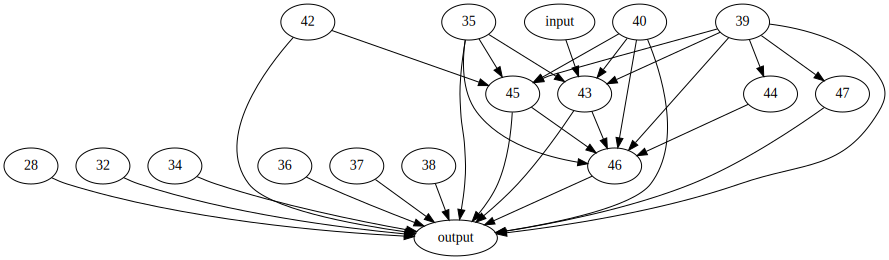

saved to checkpoint ut2w30i2/checkpoint 2.pkl
patching 959 edges, keeping 30 edges, 236 remain
patching 959 edges, keeping 30 edges, 236 remain
baseline score 0.8539336919784546
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8539], device='cuda:0')
patching 1 edges with score 0.8538790941238403 with diff of 5.459785461425781e-05
patching 960 edges, keeping 30 edges, 235 remain
baseline score 0.8538790941238403
[1, 1] sized edge sets remaining
got scores tensor([0.8534], device='cuda:0')
keeping edge edge  39 -> 42 (('blocks.39.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.853421688079834 which has diff 0.00045740604400634766 > 0.0001
patching 960 edges, keeping 31 edges, 234 remain
baseline score 0.8538790941238403
[1] sized edge sets remaining
got scores tensor([0.8536], device='cuda:0')
keeping edge edge  40 -> 42 (('blocks.40.hook_out_proj', <function storage_hoo

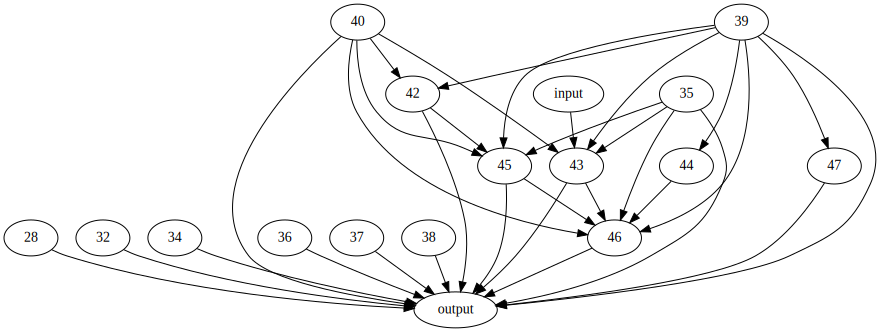

saved to checkpoint ut2w30i2/checkpoint 3.pkl
patching 960 edges, keeping 32 edges, 233 remain
patching 960 edges, keeping 32 edges, 233 remain
baseline score 0.8538790941238403
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8491], device='cuda:0')
keeping edge edge  input -> 40 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8490759134292603 which has diff 0.004803180694580078 > 0.0001
patching 960 edges, keeping 33 edges, 232 remain
baseline score 0.8538790941238403
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8488], device='cuda:0')
keeping edge edge  0 -> 40 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8488306999206543 which has diff 0.005048394203186035 > 0.0001
patching 960 edges, keeping 34 edges, 231 remain
baseline score 

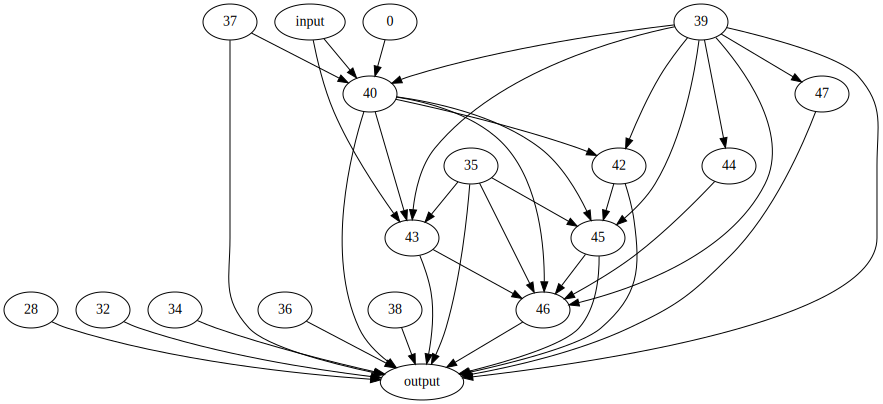

saved to checkpoint ut2w30i2/checkpoint 4.pkl
patching 960 edges, keeping 36 edges, 229 remain
patching 960 edges, keeping 36 edges, 229 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.7453], device='cuda:0')
keeping edge edge  input -> 39 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.7452870011329651 which has diff 0.10859209299087524 > 0.0001
patching 960 edges, keeping 37 edges, 228 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.4928], device='cuda:0')
keeping edge edge  0 -> 39 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', 

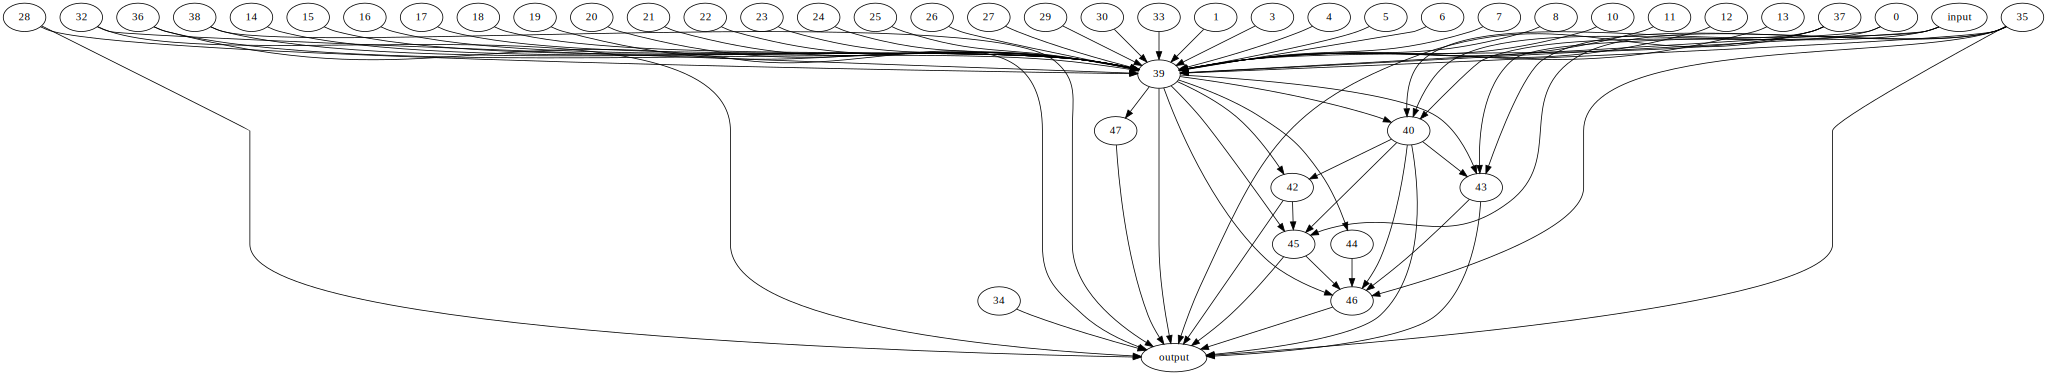

saved to checkpoint ut2w30i2/checkpoint 5.pkl
patching 960 edges, keeping 72 edges, 193 remain
patching 960 edges, keeping 72 edges, 193 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8520], device='cuda:0')
keeping edge edge  input -> 37 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8520107865333557 which has diff 0.0018683075904846191 > 0.0001
patching 960 edges, keeping 73 edges, 192 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8453], device='cuda:0')
keeping edge edge  0 -> 37 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8452807664871216 which has diff 0.00859832763671875 > 0.0001
patching 960 edges, keeping 

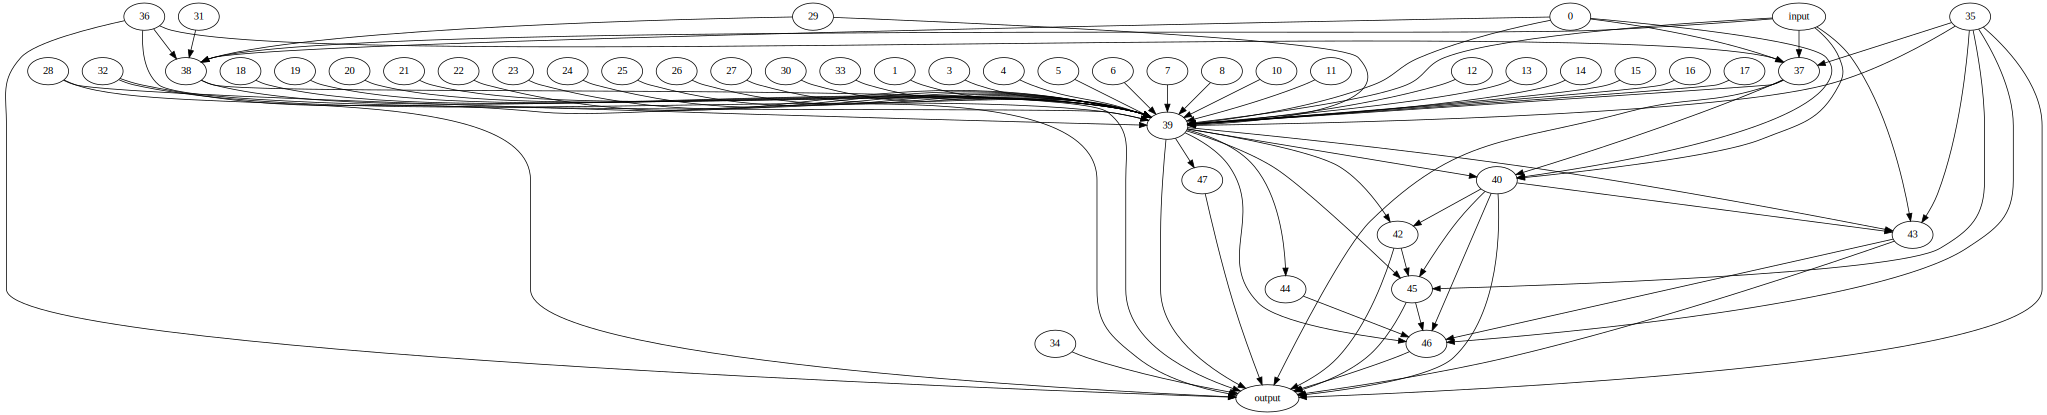

saved to checkpoint ut2w30i2/checkpoint 6.pkl
patching 961 edges, keeping 81 edges, 183 remain
patching 961 edges, keeping 81 edges, 183 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8525], device='cuda:0')
keeping edge edge  input -> 36 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8524729609489441 which has diff 0.0013293623924255371 > 0.0001
patching 961 edges, keeping 82 edges, 182 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8481], device='cuda:0')
keeping edge edge  0 -> 36 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8481469750404358 which has diff 0.005655348300933838 > 0.0001
patching 

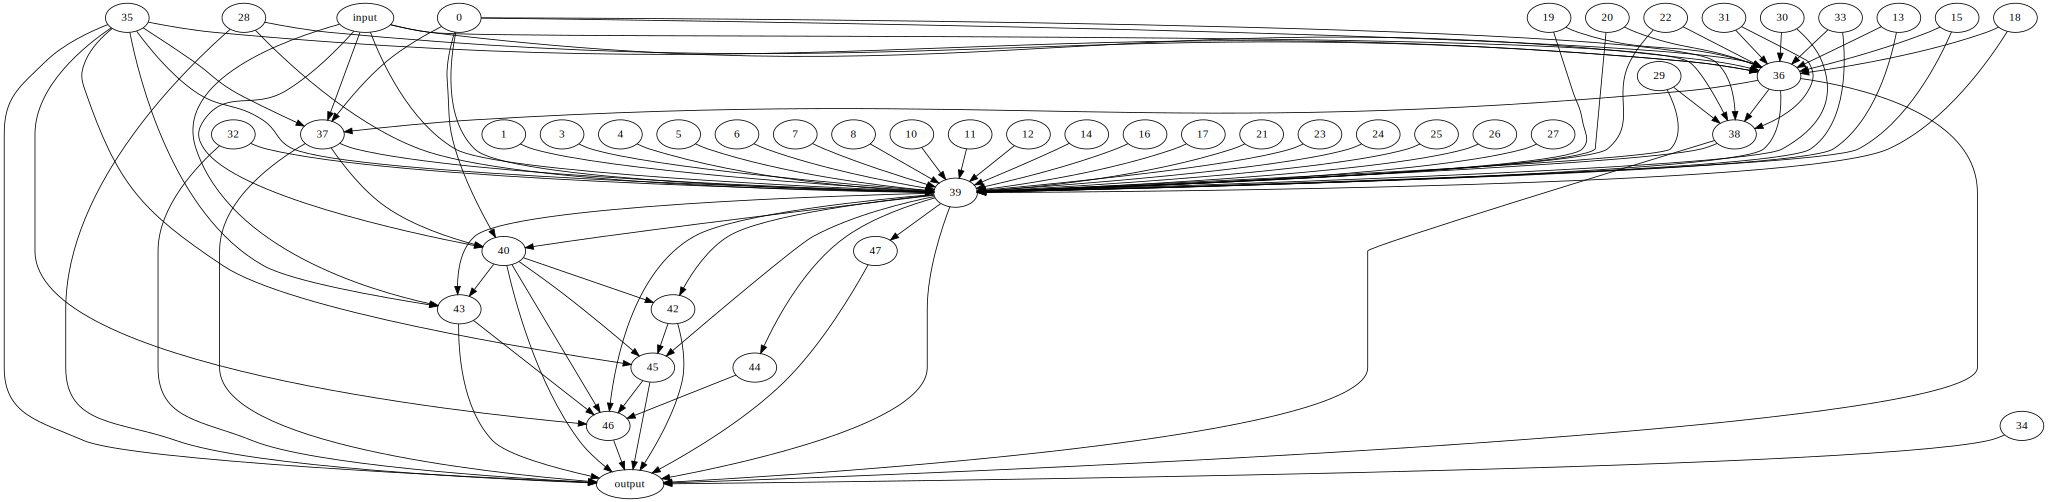

saved to checkpoint ut2w30i2/checkpoint 7.pkl
patching 961 edges, keeping 94 edges, 170 remain
patching 961 edges, keeping 94 edges, 170 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8537], device='cuda:0')
keeping edge edge  29 -> 34 (('blocks.29.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8536565899848938 which has diff 0.00014573335647583008 > 0.0001
patching 961 edges, keeping 95 edges, 169 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda:0')
keeping edge edge  33 -> 34 (('blocks.33.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8528451323509216 which has diff 0.000957190990447998 > 0.0

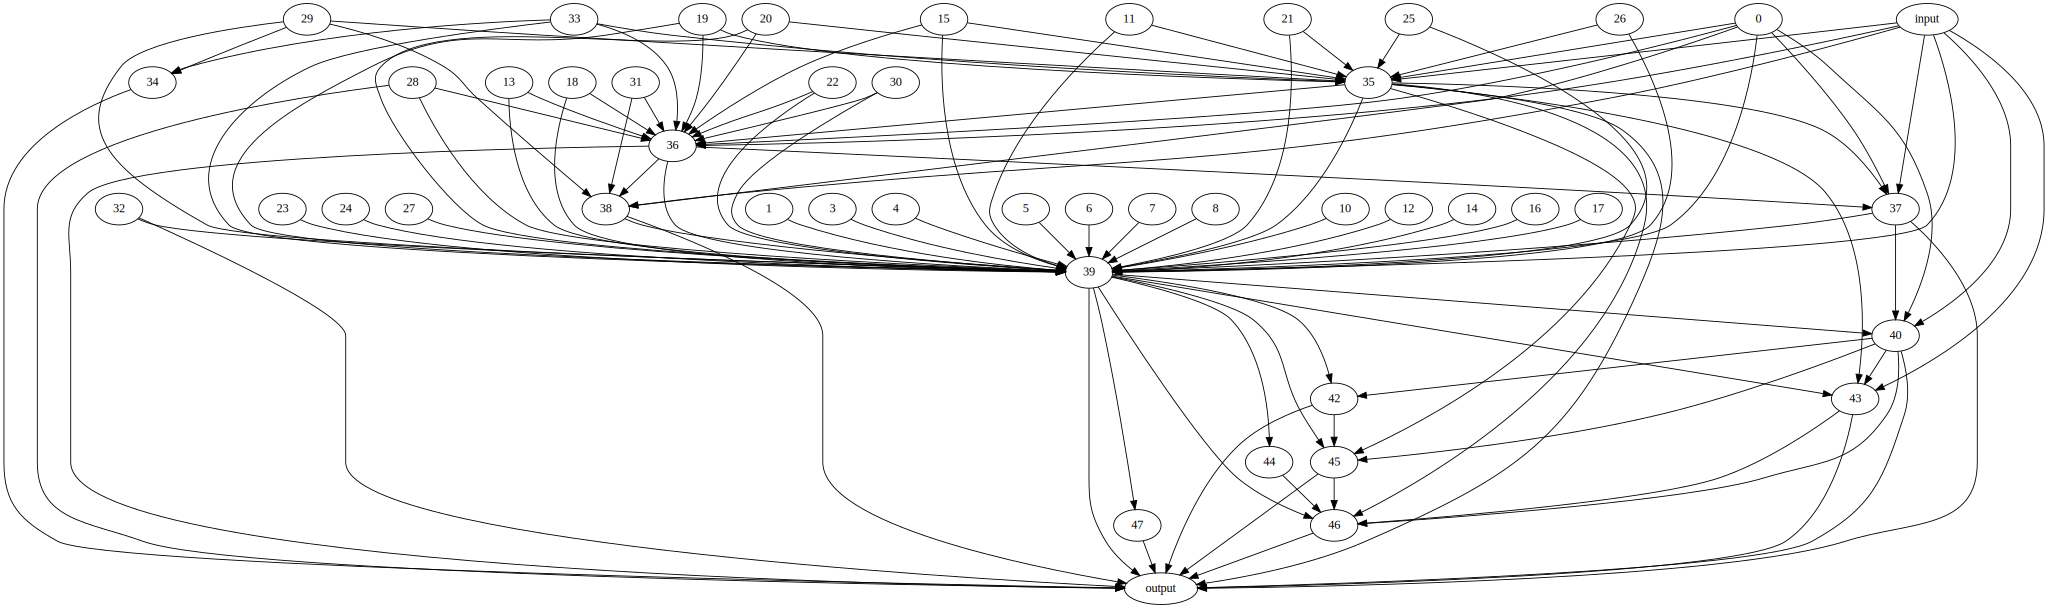

saved to checkpoint ut2w30i2/checkpoint 8.pkl
patching 961 edges, keeping 107 edges, 157 remain
patching 961 edges, keeping 107 edges, 157 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8525], device='cuda:0')
keeping edge edge  input -> 32 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8525335788726807 which has diff 0.0012687444686889648 > 0.0001
patching 961 edges, keeping 108 edges, 156 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8506], device='cuda:0')
keeping edge edge  0 -> 32 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8506377935409546 which has diff 0.0031645298

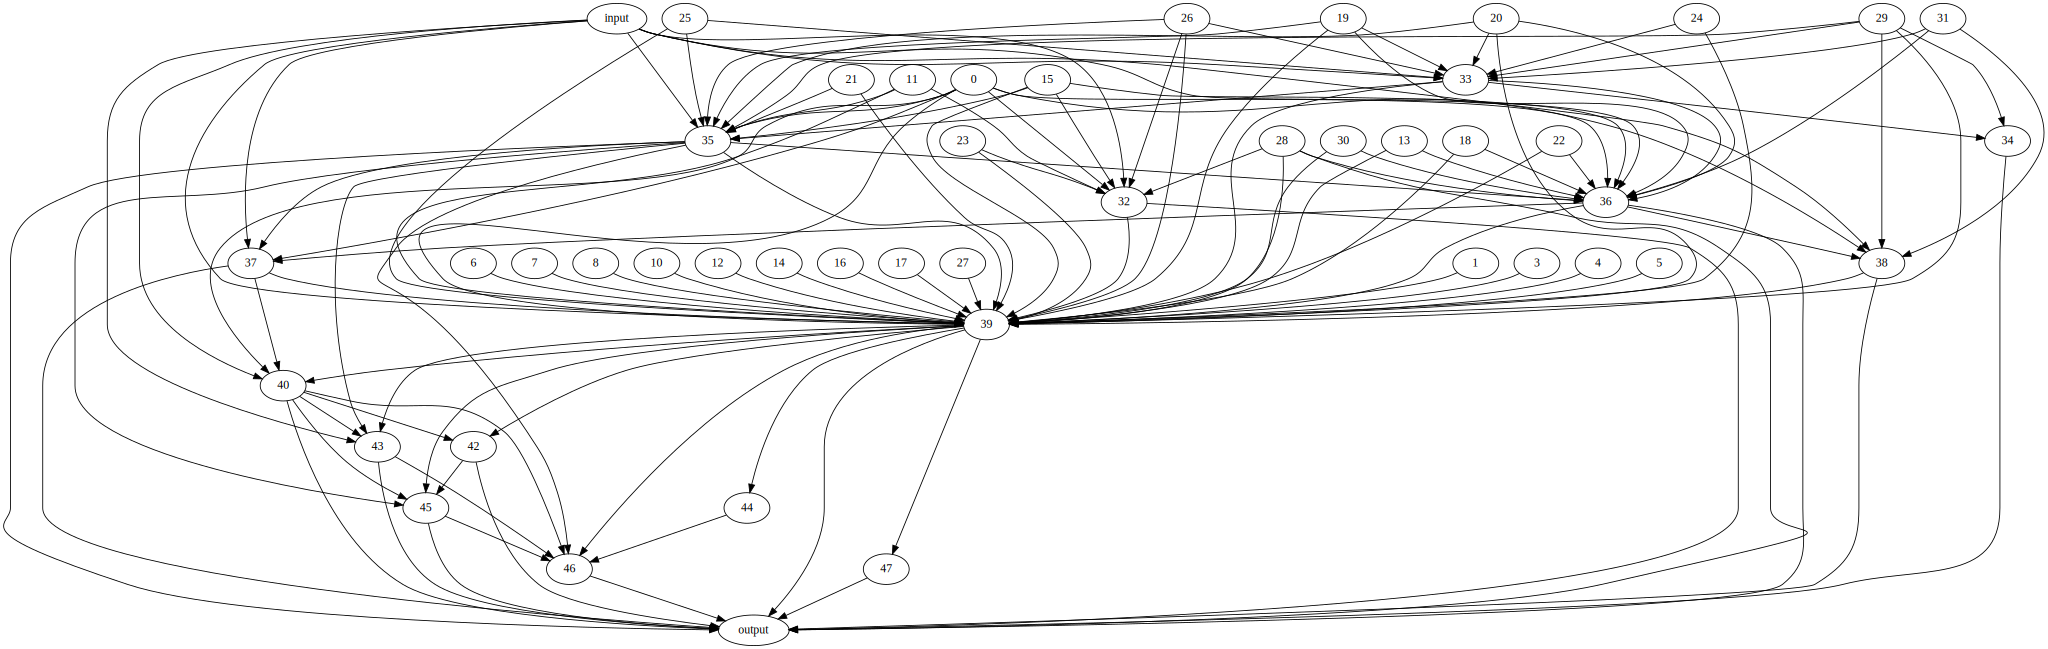

saved to checkpoint ut2w30i2/checkpoint 9.pkl
patching 963 edges, keeping 122 edges, 140 remain
patching 963 edges, keeping 122 edges, 140 remain
baseline score 0.8536489605903625
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8531], device='cuda:0')
keeping edge edge  input -> 31 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8531105518341064 which has diff 0.0005384087562561035 > 0.0001
patching 963 edges, keeping 123 edges, 139 remain
baseline score 0.8536489605903625
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8502], device='cuda:0')
keeping edge edge  0 -> 31 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8501865863800049 which has diff 0.003462374210357666 > 0.0001
patching 963 edges, keeping 12

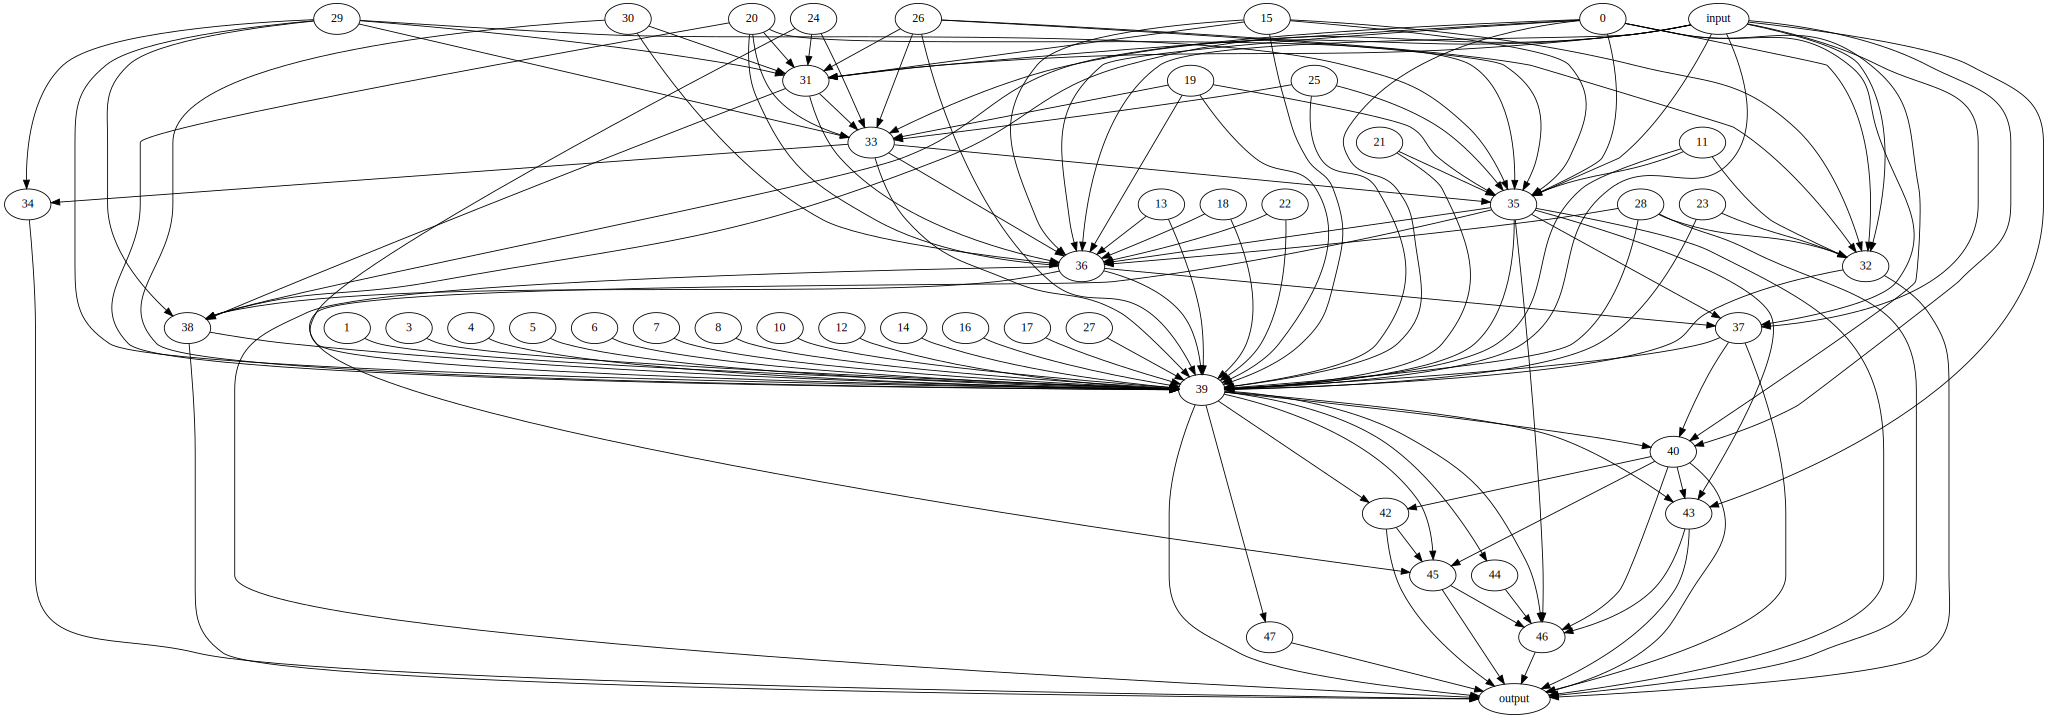

saved to checkpoint ut2w30i2/checkpoint 10.pkl
patching 964 edges, keeping 130 edges, 131 remain
patching 964 edges, keeping 130 edges, 131 remain
baseline score 0.8535865545272827
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 30 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521378040313721 which has diff 0.0014487504959106445 > 0.0001
patching 964 edges, keeping 131 edges, 130 remain
baseline score 0.8535865545272827
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8477], device='cuda:0')
keeping edge edge  0 -> 30 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8476529717445374 which has diff 0.005933582782745361 > 0.0001
patch

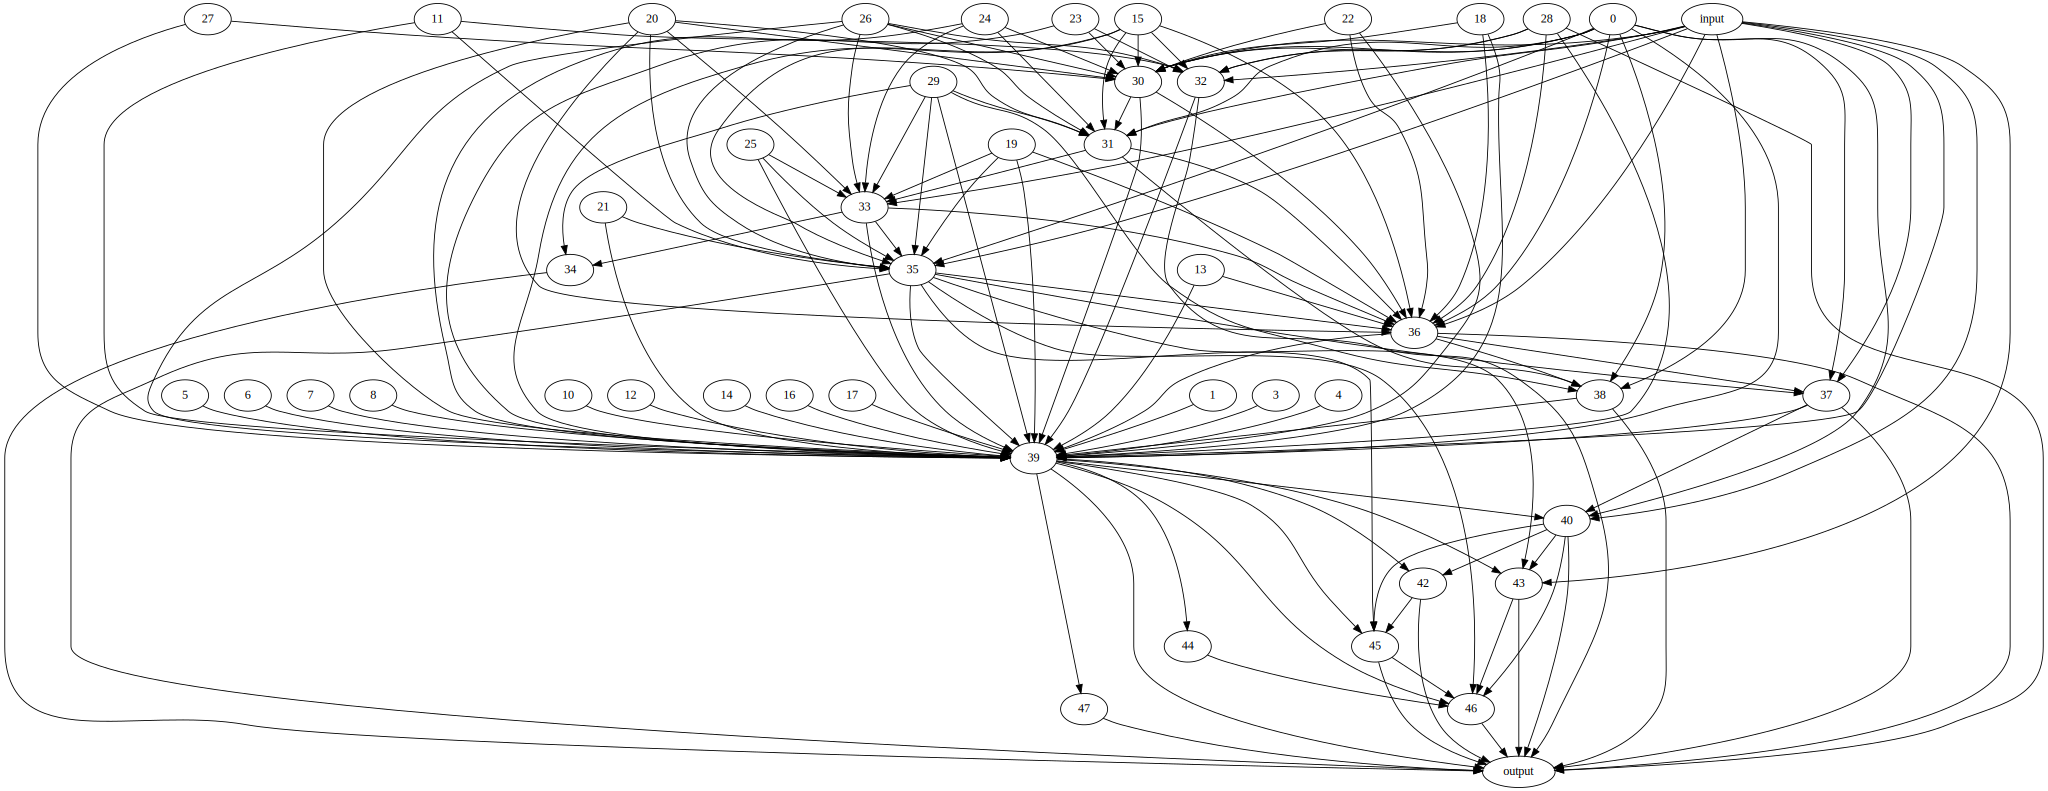

saved to checkpoint ut2w30i2/checkpoint 11.pkl
patching 966 edges, keeping 141 edges, 118 remain
patching 966 edges, keeping 141 edges, 118 remain
baseline score 0.853479266166687
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8515], device='cuda:0')
keeping edge edge  input -> 27 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8515049815177917 which has diff 0.0019742846488952637 > 0.0001
patching 966 edges, keeping 142 edges, 117 remain
baseline score 0.853479266166687
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8458], device='cuda:0')
keeping edge edge  0 -> 27 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with

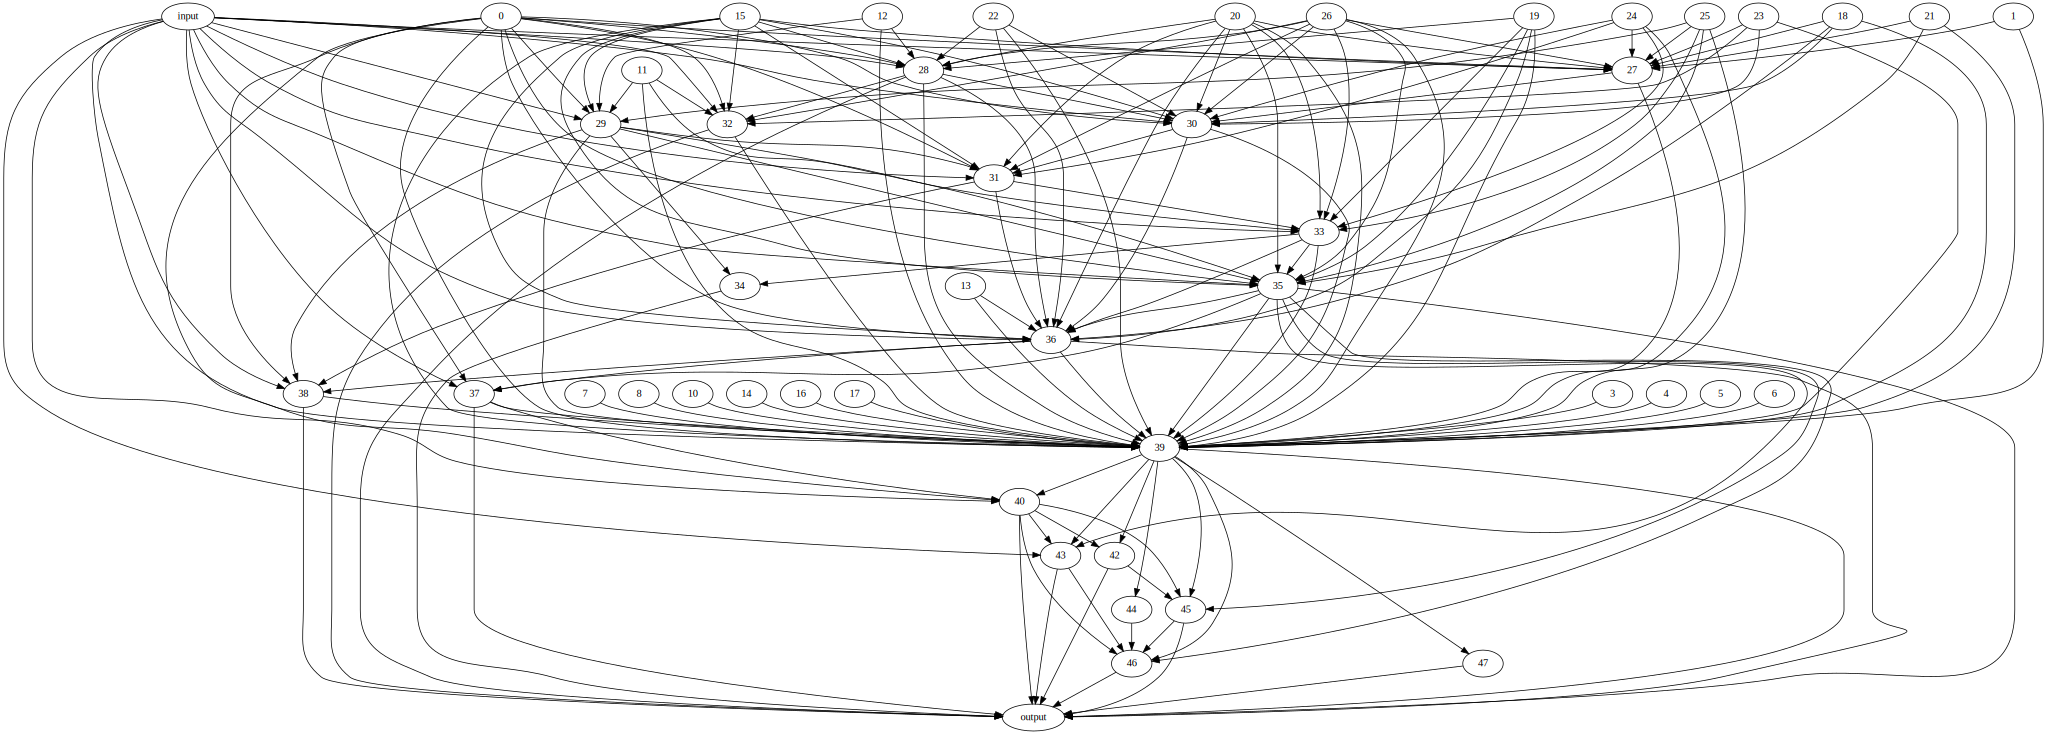

saved to checkpoint ut2w30i2/checkpoint 12.pkl
patching 967 edges, keeping 166 edges, 92 remain
patching 967 edges, keeping 166 edges, 92 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 25 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521310091018677 which has diff 0.0012576580047607422 > 0.0001
patching 967 edges, keeping 167 edges, 91 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8465], device='cuda:0')
keeping edge edge  0 -> 25 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8464881181716919 which has diff 0.0069005489349365234 > 0.0001
patchin

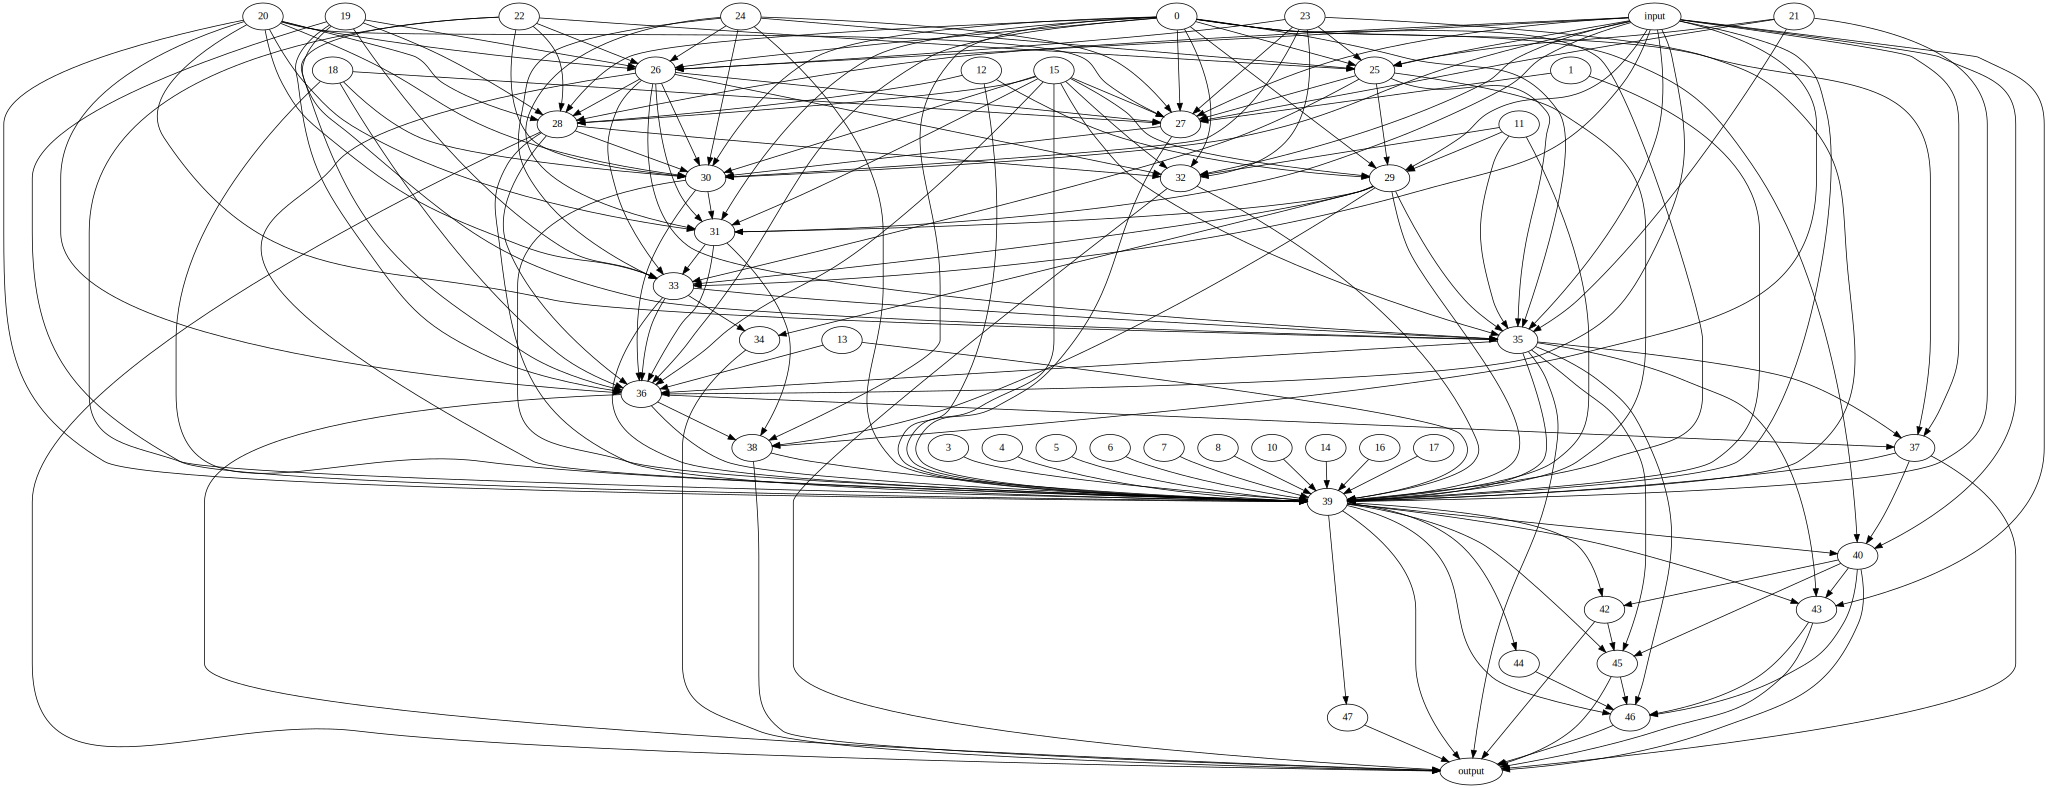

saved to checkpoint ut2w30i2/checkpoint 13.pkl
patching 967 edges, keeping 179 edges, 79 remain
patching 967 edges, keeping 179 edges, 79 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8502], device='cuda:0')
keeping edge edge  input -> 23 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8501508831977844 which has diff 0.003237783908843994 > 0.0001
patching 967 edges, keeping 180 edges, 78 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda:0')
keeping edge edge  12 -> 23 (('blocks.12.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8527839183807373 which has diff 0.0006047487258911133 > 0.0001
patching 967 edges, keeping 181 edge

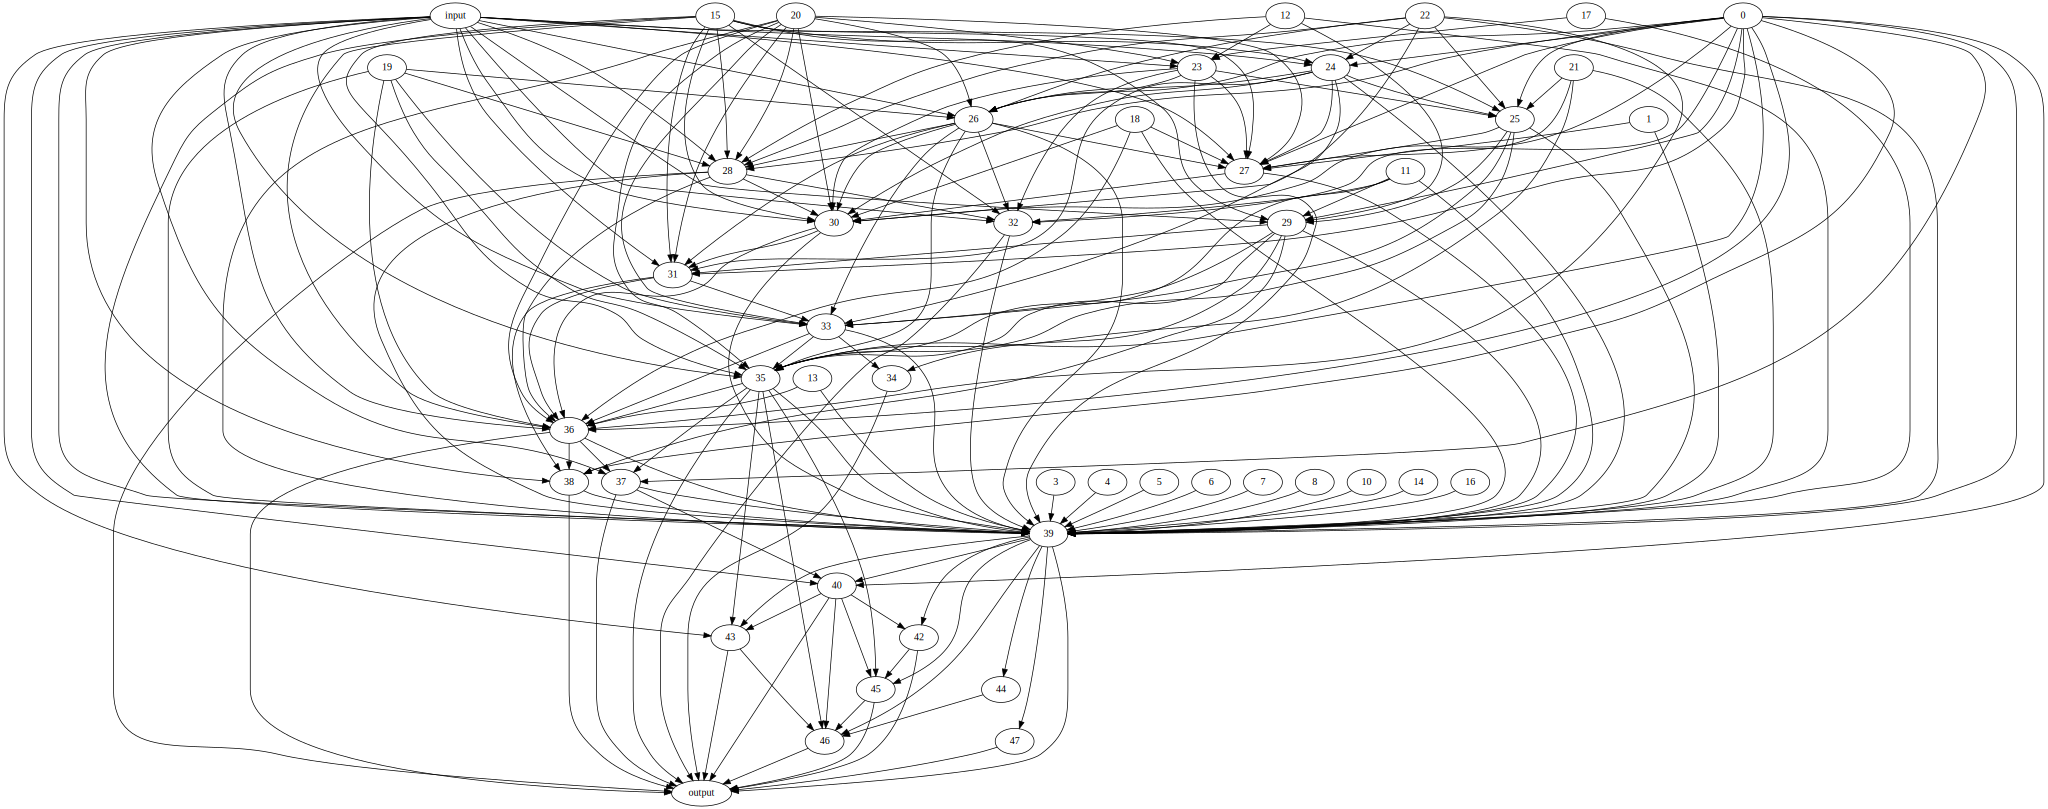

saved to checkpoint ut2w30i2/checkpoint 14.pkl
patching 967 edges, keeping 187 edges, 71 remain
patching 967 edges, keeping 187 edges, 71 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8492], device='cuda:0')
keeping edge edge  input -> 22 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8492206931114197 which has diff 0.00416797399520874 > 0.0001
patching 967 edges, keeping 188 edges, 70 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8448], device='cuda:0')
keeping edge edge  0 -> 22 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8448150157928467 which has diff 0.008573651313781738 > 0.0001
patching 967 edges, keeping 189 edges, 69 rema

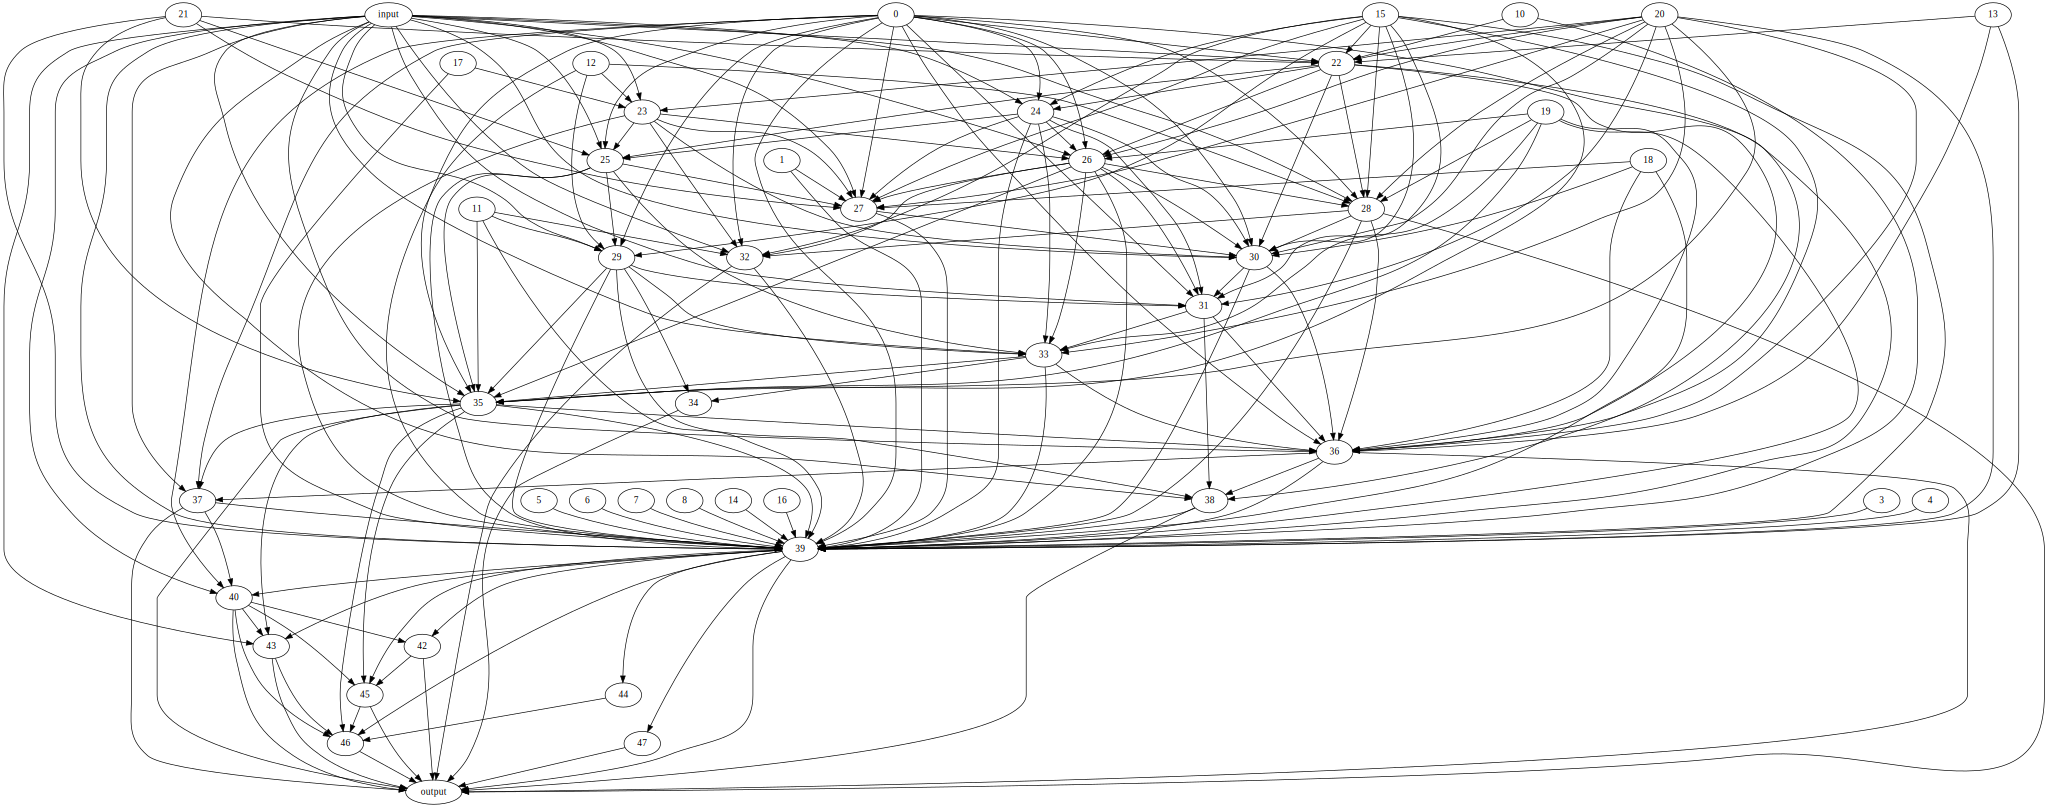

saved to checkpoint ut2w30i2/checkpoint 15.pkl
patching 967 edges, keeping 194 edges, 64 remain
patching 967 edges, keeping 194 edges, 64 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8454], device='cuda:0')
keeping edge edge  input -> 19 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8453577160835266 which has diff 0.008030951023101807 > 0.0001
patching 967 edges, keeping 195 edges, 63 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8299], device='cuda:0')
keeping edge edge  0 -> 19 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8299111127853394 which has diff 0.023477554321289062 > 0.00

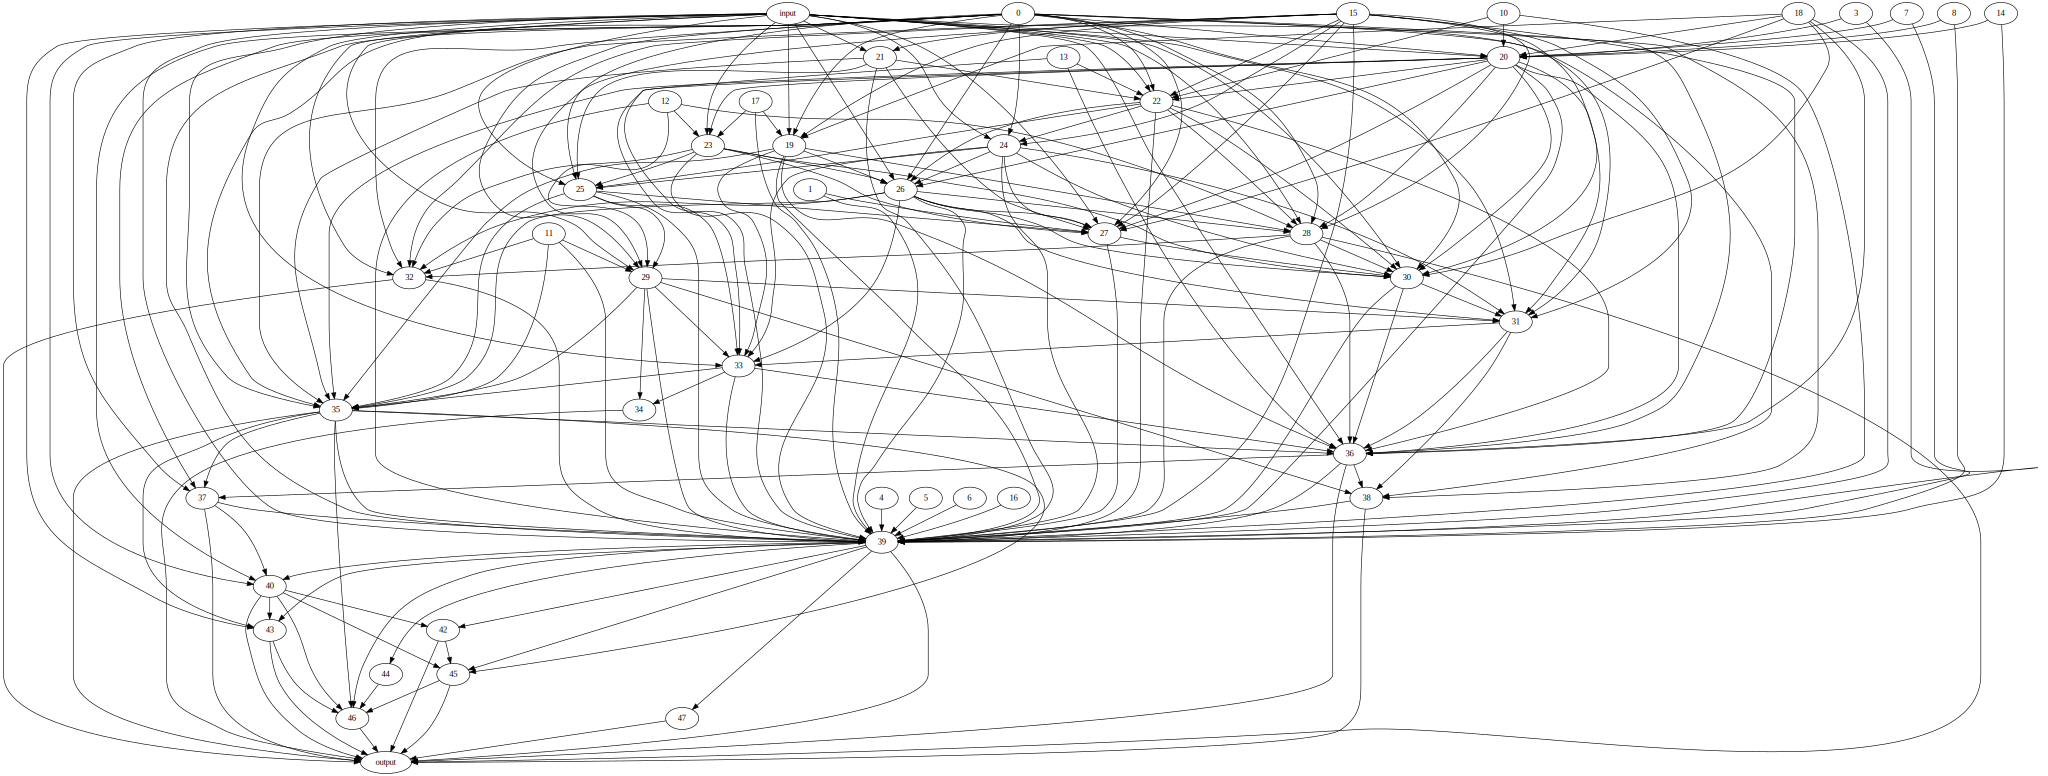

saved to checkpoint ut2w30i2/checkpoint 16.pkl
patching 967 edges, keeping 209 edges, 49 remain
patching 967 edges, keeping 209 edges, 49 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8511], device='cuda:0')
keeping edge edge  input -> 17 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8510920405387878 which has diff 0.002296626567840576 > 0.0001
patching 967 edges, keeping 210 edges, 48 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8474], device='cuda:0')
keeping edge edge  0 -> 17 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8473986387252808 which has diff 0.005990028381347656 > 0.0001
patching 967 ed

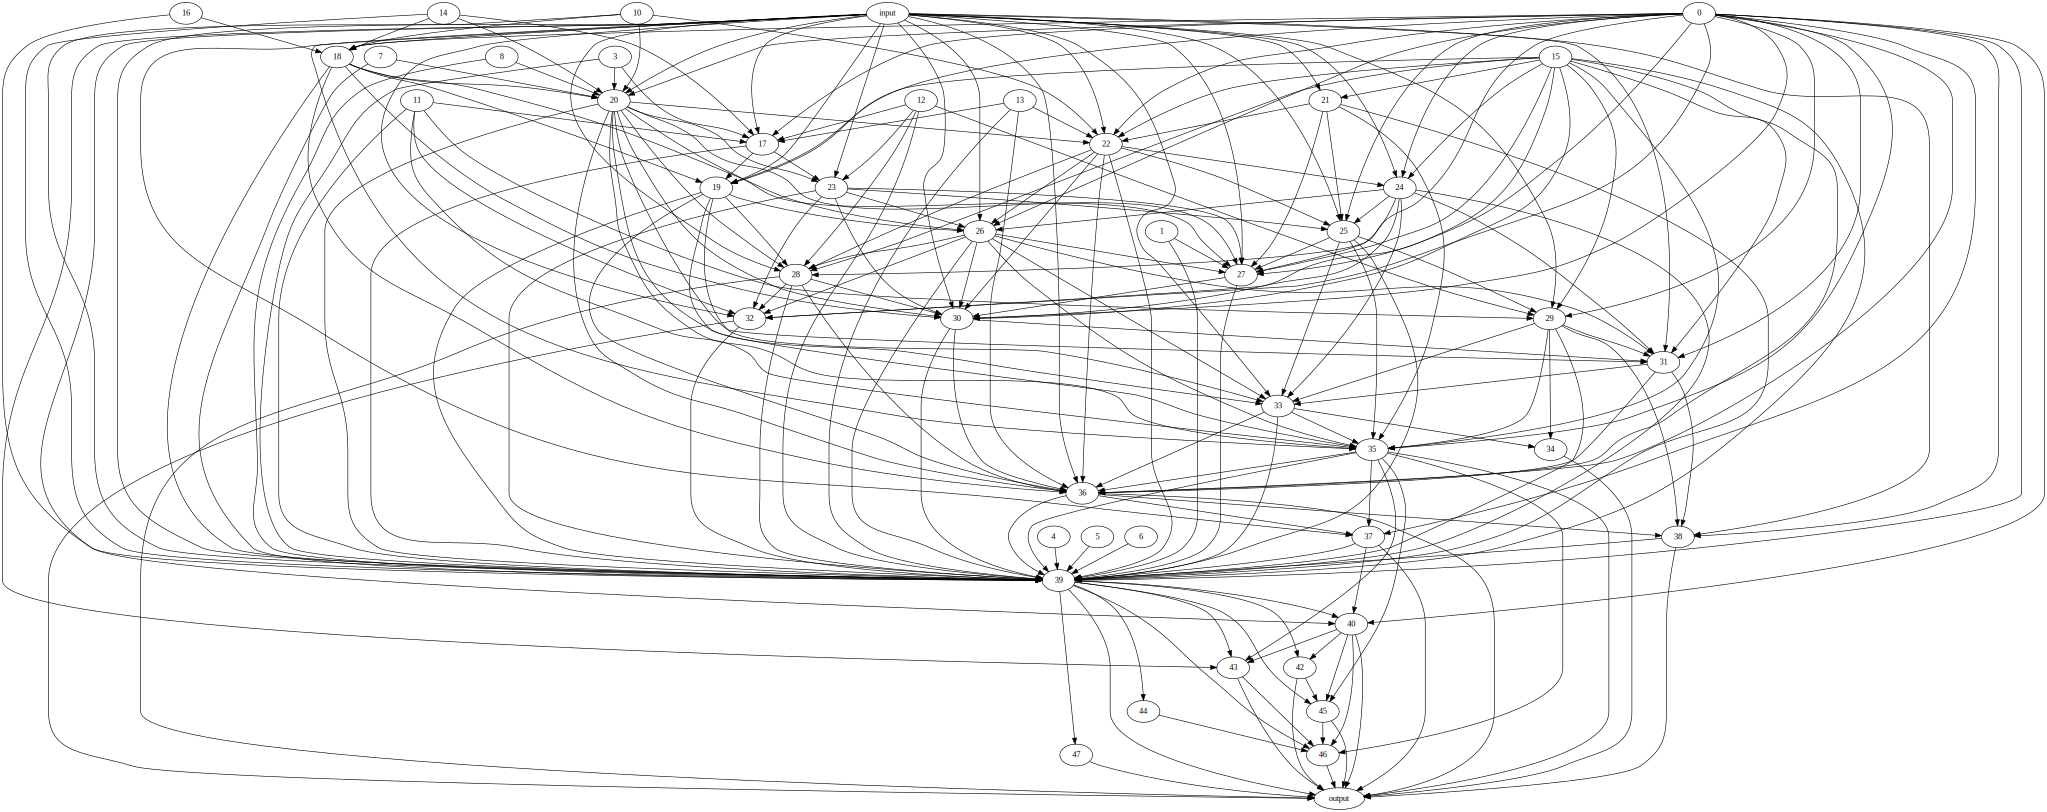

saved to checkpoint ut2w30i2/checkpoint 17.pkl
patching 967 edges, keeping 221 edges, 37 remain
patching 967 edges, keeping 221 edges, 37 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8390], device='cuda:0')
keeping edge edge  input -> 15 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8390284776687622 which has diff 0.014360189437866211 > 0.0001
patching 967 edges, keeping 222 edges, 36 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8199], device='cuda:0')
keeping edge edge  0 -> 15 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8199267387390137 which has diff 0.033461928367614746 > 0.0001
patching 967 edges, keeping 223 edges, 

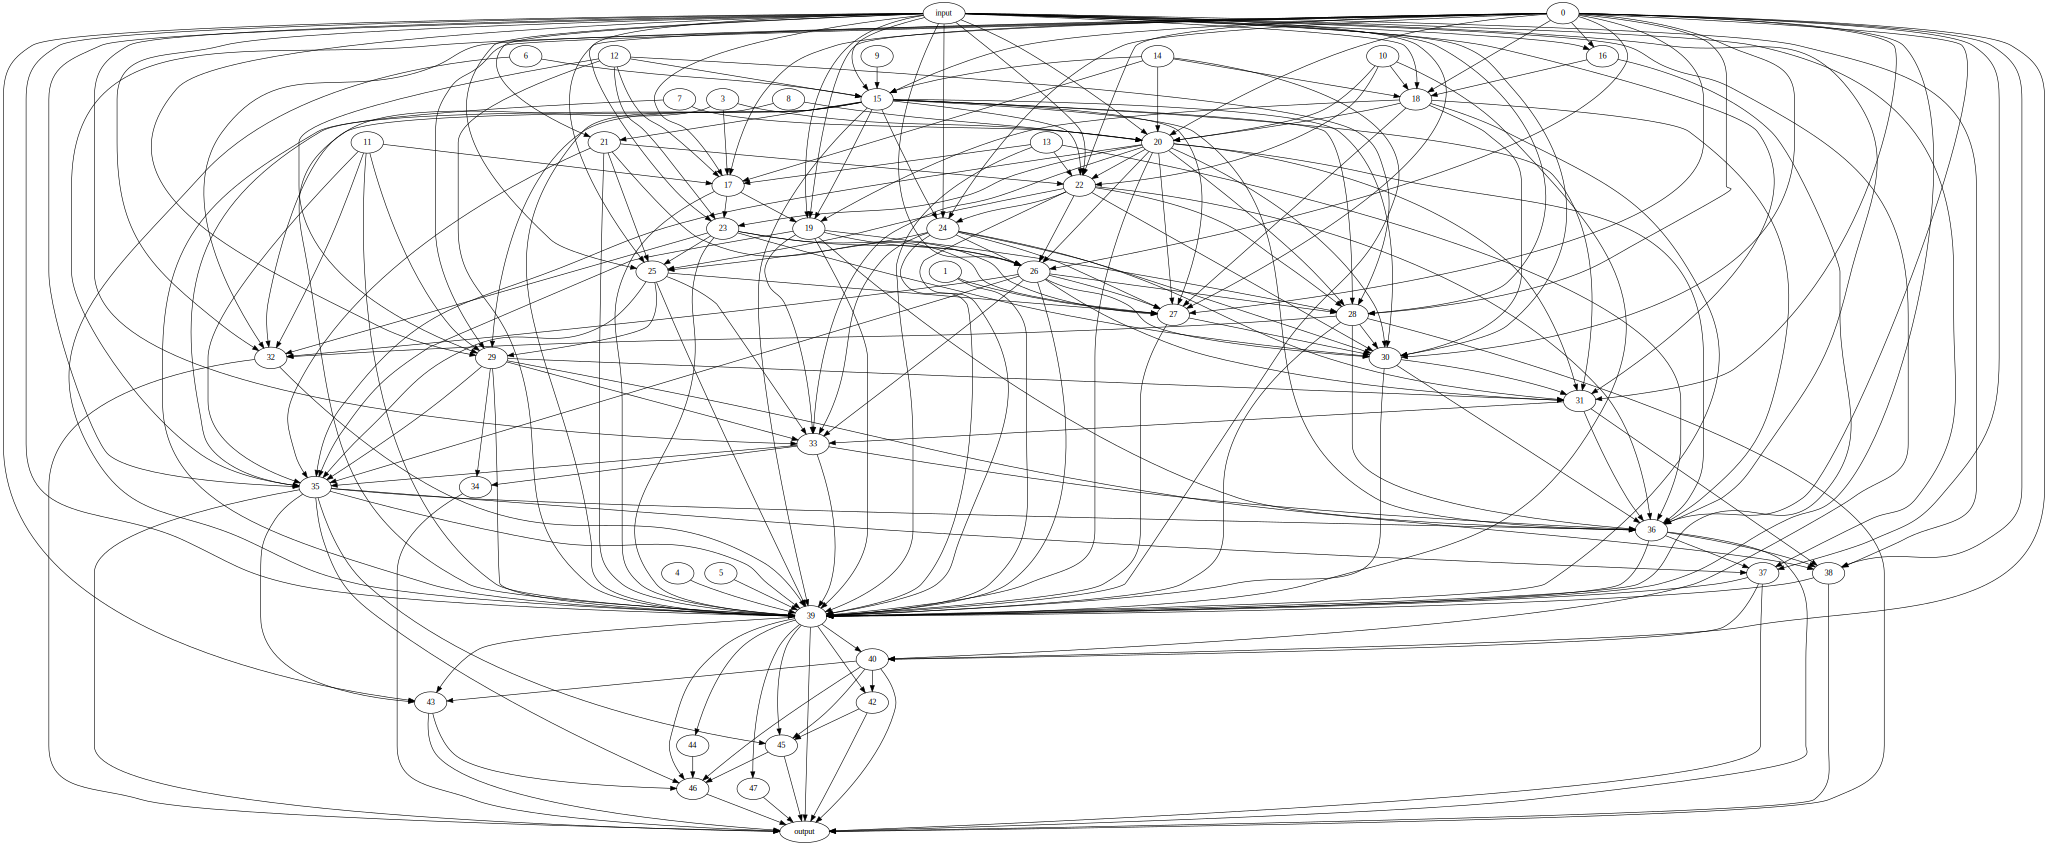

saved to checkpoint ut2w30i2/checkpoint 18.pkl
patching 967 edges, keeping 229 edges, 29 remain
patching 967 edges, keeping 229 edges, 29 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8490], device='cuda:0')
keeping edge edge  input -> 13 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8490012884140015 which has diff 0.004387378692626953 > 0.0001
patching 967 edges, keeping 230 edges, 28 remain
baseline score 0.8533886671066284
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8486], device='cuda:0')
keeping edge edge  0 -> 13 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8486301302909851 which has diff 0.0047585368156433105 > 0.0001
patching 967 edges, keeping 231 edges, 27 remain
baselin

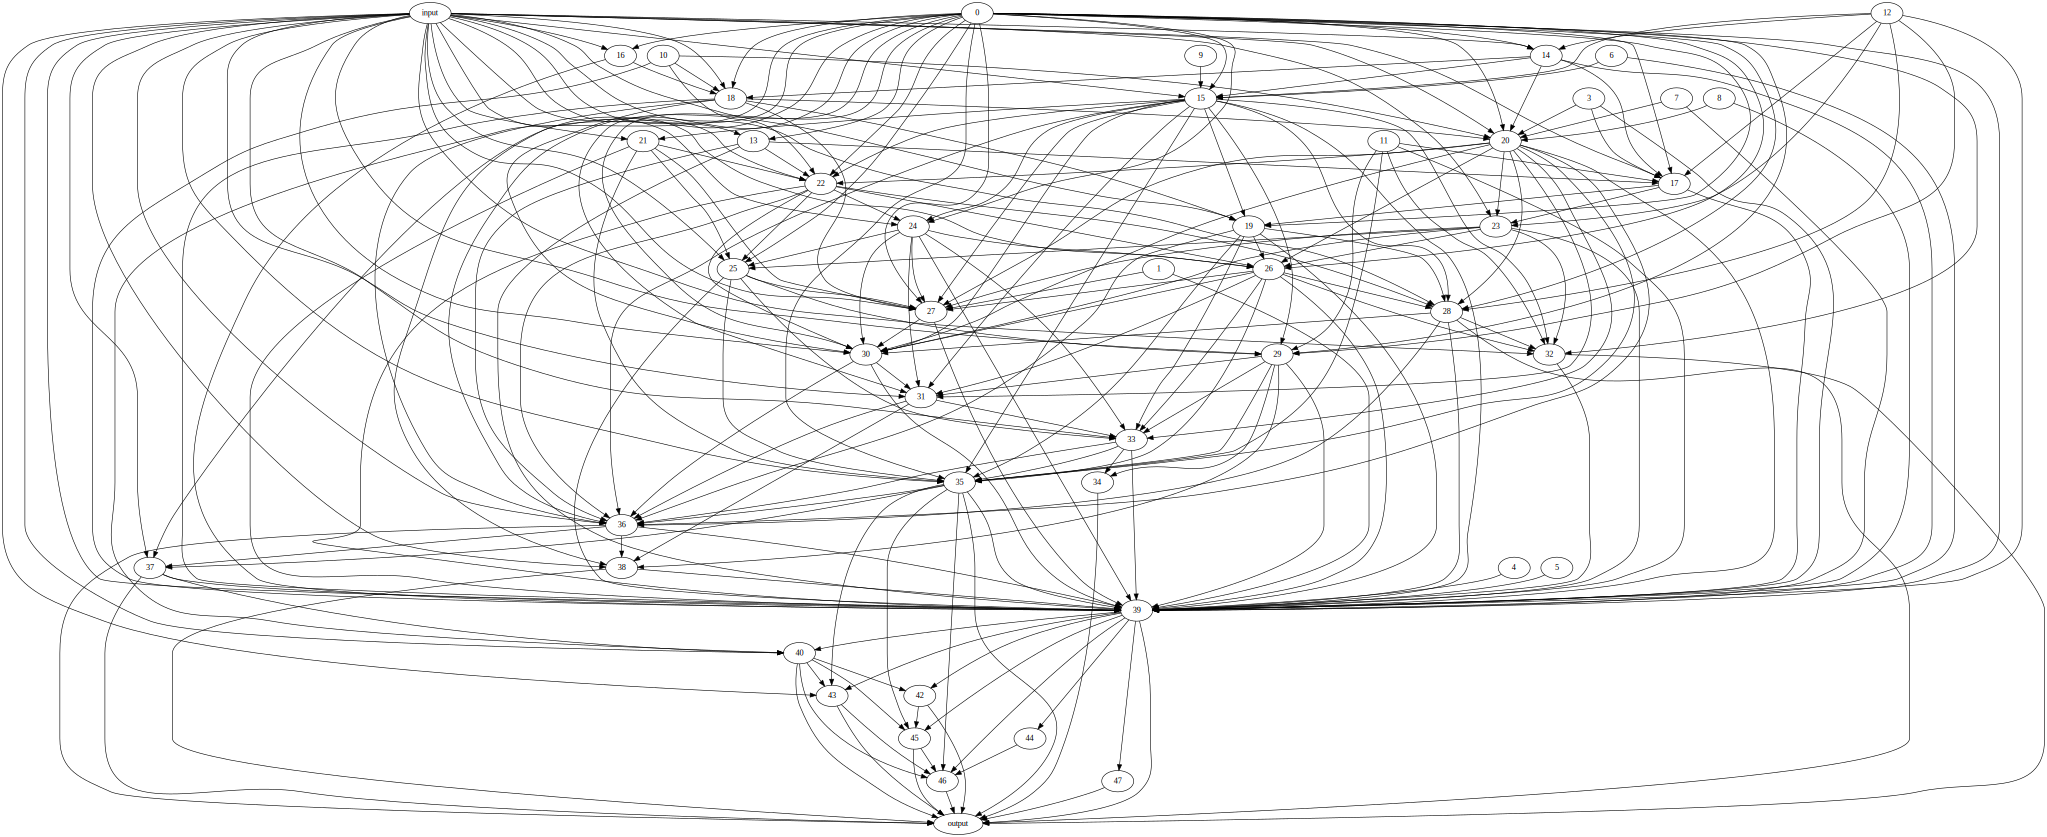

saved to checkpoint ut2w30i2/checkpoint 19.pkl
patching 967 edges, keeping 234 edges, 24 remain
patching 967 edges, keeping 234 edges, 24 remain
baseline score 0.8533886671066284
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8489], device='cuda:0')
keeping edge edge  input -> 12 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8489415049552917 which has diff 0.00444716215133667 > 0.0001
patching 967 edges, keeping 235 edges, 23 remain
baseline score 0.8533886671066284
[1, 1] sized edge sets remaining
got scores tensor([0.8475], device='cuda:0')
keeping edge edge  0 -> 12 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8475301861763 which has diff 0.005858480930328369 > 0.0001
patching 967 edges, keeping 236 edges, 22 remain
baseline score 0.8533886

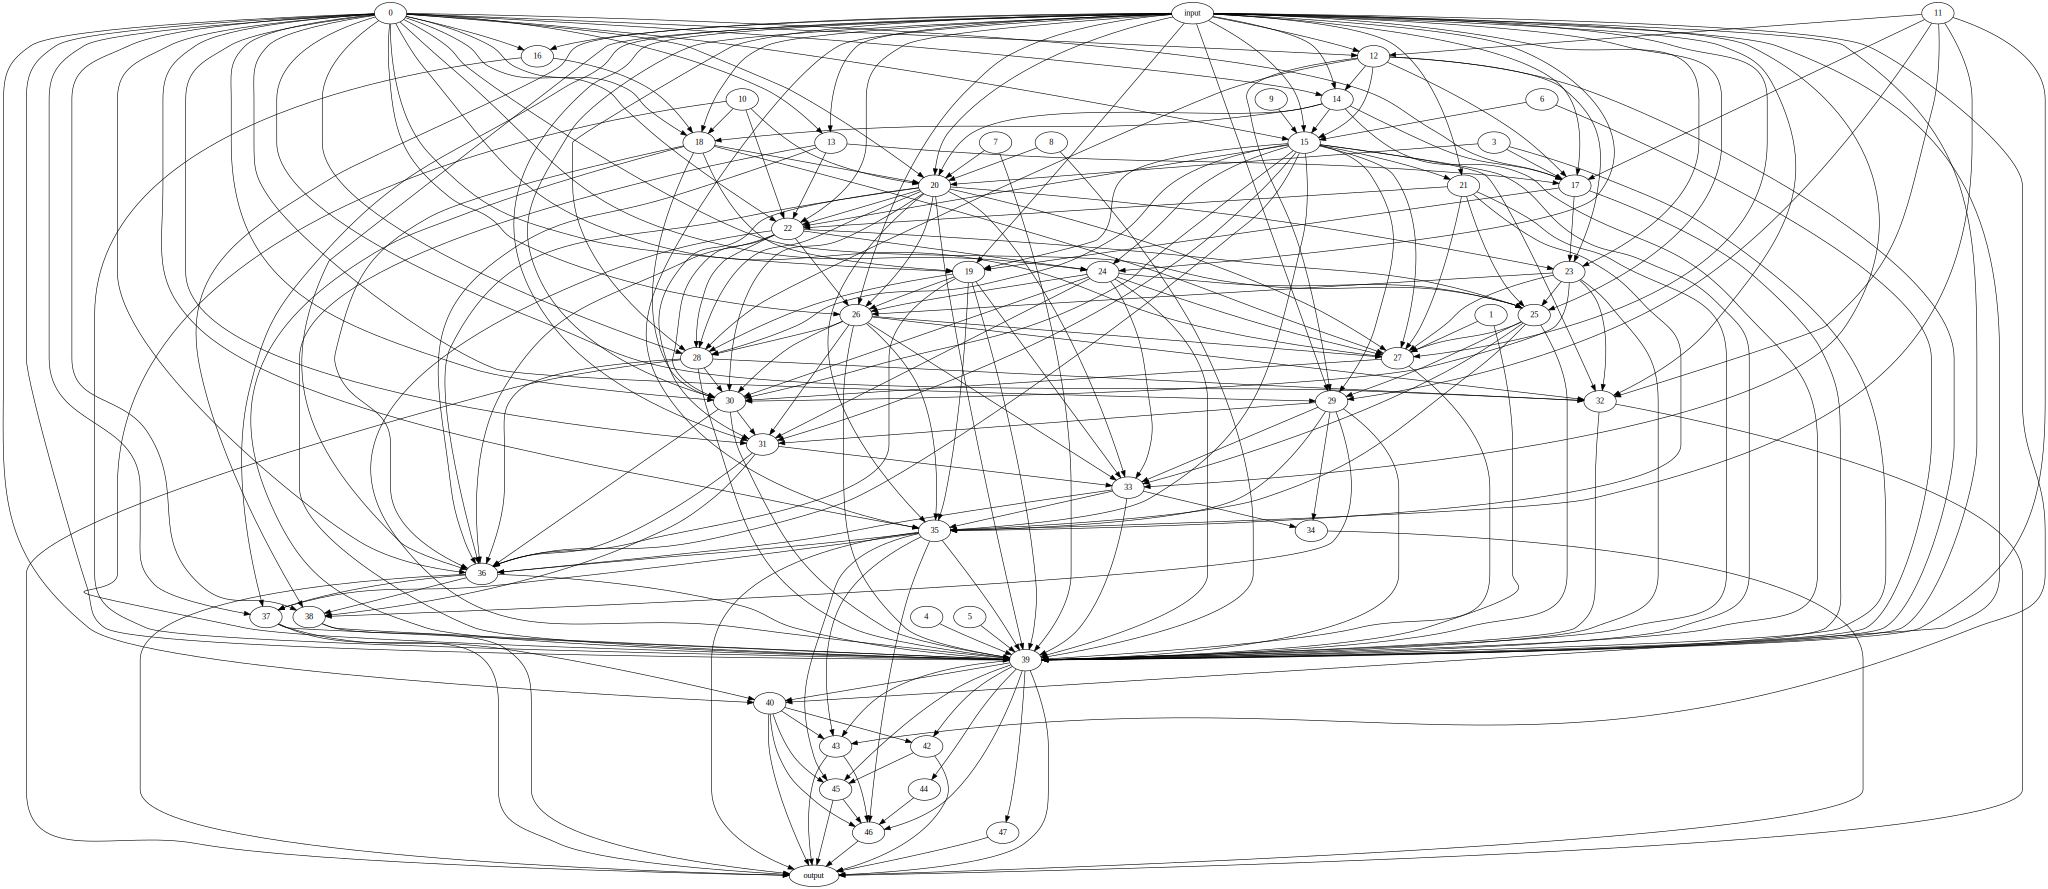

saved to checkpoint ut2w30i2/checkpoint 20.pkl
patching 967 edges, keeping 237 edges, 21 remain
patching 967 edges, keeping 237 edges, 21 remain
baseline score 0.8533886671066284
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8467], device='cuda:0')
keeping edge edge  input -> 11 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.11.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8467483520507812 which has diff 0.006640315055847168 > 0.0001
patching 967 edges, keeping 238 edges, 20 remain
interrupted
all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 967 edges, keeping 0 edges, 258 remain
patching 967 edges, keeping 0 edges, 258 remain
baseline score 0.853

InterruptedException: 

In [53]:


job_name_text = "IOI attr patcfhing phase 3.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False
    
wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")

cfg.ckpt_directory = wandb_id
cfg.iter = 0
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
try:
    wandb.finish()
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

# reset them for another run
for edge in result_edges_2:
    if edge.checked and not edge.patching:
        edge.checked = False


#cfg.thresh = 0.00001,
#cfg.rollback_thresh = 0.00001,
cfg.thresh = 0.0001
cfg.rollback_thresh = 0.0001
result_edges_3 = run_acdc(model=model, data=data, cfg=cfg, edges=result_edges_2)
wandb.finish()